In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re
from collections import Counter
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, BatchNormalization, ReLU, Permute, Concatenate, Input, GRU
from tensorflow.keras.models import Model
from sktime.classification.interval_based import TimeSeriesForestClassifier
from tensorflow.keras.layers import GRU, Dense, Dropout
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.kernel_based import Arsenal
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from pyts.classification import LearningShapelets
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import load_model
import pickle
import os
import json
import csv
from sktime.utils import mlflow_sktime
from tabulate import tabulate
import time
from kafka import KafkaProducer
from sktime.utils import mlflow_sktime
from tabulate import tabulate
from confluent_kafka import Consumer, KafkaException, KafkaError

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
file_path = "/content/drive/MyDrive/REFIT_CLEAN/HOUSES_Labels.txt"

# Read the labels file
labels_df = pd.read_csv(file_path)

# Drop the 'House_id' column
labels_df = labels_df.drop(columns=["House_id"])

# Show DataFrame
labels_df.head()

,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
0,Time,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater,Issues
1,Time,Unix,Aggregate,Fridge-Freezer,Washing Machine,Dishwasher,Television Site,Microwave,Toaster,Hi-Fi,Kettle,Oven Extractor Fan,Issues
2,Time,Unix,Aggregate,Toaster,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine,Television Site,Microwave,Kettle,Issues
3,Time,Unix,Aggregate,Fridge,Freezer,Fridge-Freezer,Washing Machine (1),Washing Machine (2),Computer Site,Television Site,Microwave,Kettle,Issues
4,Time,Unix,Aggregate,Fridge-Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Combination Microwave,Kettle,Toaster,Issues


In [6]:
# Define file paths
file_paths = [
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House1.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House2.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House3.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House4.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House5.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House6.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House7.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House8.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House9.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House10.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House11.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House12.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House13.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House15.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House16.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House17.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House18.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House19.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House20.csv",
    "/content/drive/MyDrive/REFIT_CLEAN/CLEAN_House21.csv"
]

# Iterate over file paths and create DataFrames
for i, file_path in enumerate(file_paths):
    # Read CSV file
    house_df = pd.read_csv(file_path, header=None)

    # Set column names based on labels_df
    specific_row = labels_df.iloc[i].tolist()
    house_df.columns = specific_row

    # Drop the first row
    house_df = house_df.iloc[1:]

    # Add a unique ID column to the DataFrame
    house_df['id'] = range(1, len(house_df) + 1)

    # Drop the ID column
    house_df.drop(columns=['id'], inplace=True)

    globals()[f"house_{i+1}"] = house_df


In [22]:
house_15.head()

,Time,Unix,Aggregate,Fridge-Freezer (1),Fridge-Freezer (2),Electric Heater (1),Electric Heater (2),Washing Machine,Dishwasher,Computer Site,Television Site,Dehumidifier/Heater,Issues
1,2014-01-10 10:58:19,1389351499,1195,5,0,0,0,0,0,82,0,0,0
2,2014-01-10 10:58:24,1389351504,1201,5,0,0,0,0,0,82,0,0,0
3,2014-01-10 10:58:29,1389351509,1201,5,0,0,0,0,0,85,0,0,0
4,2014-01-10 10:58:35,1389351515,1201,5,0,0,0,0,0,89,0,0,0
5,2014-01-10 10:58:39,1389351519,901,5,0,0,0,0,0,89,0,0,0


In [7]:
import re

def transform_column_name(name):
    # Remove any special characters and replace spaces with '_'
    name = re.sub(r'[^a-zA-Z0-9\s]', '', name).replace(' ', '_')

    # Split the name into words and check for words like WashingMachine
    words = re.findall(r'[A-Z][a-z]*', name)
    if len(words) > 1:
        # Add '_' between words with more than one capital letter
        name = '_'.join(words)

    return name

# Function to append a numerical suffix to duplicate column names
def append_suffix(col_names):
    col_counts = {}
    new_col_names = []
    for col_name in col_names:
        if col_name in col_counts:
            col_counts[col_name] += 1
            col_name = f"{col_name}_{col_counts[col_name]}"
        else:
            col_counts[col_name] = 1
        new_col_names.append(col_name)
    return new_col_names

# Iterate through each DataFrame and update column names
for i in range(1, 21):
    df = globals()[f"house_{i}"]
    new_columns = [transform_column_name(col) for col in df.columns]
    new_columns = append_suffix(new_columns)
    df.columns = new_columns


In [8]:
# Iterate through each DataFrame
for i in range(1, 21):
    # Drop unwanted columns
    globals()[f"house_{i}"] = globals()[f"house_{i}"].drop(columns=["Issues"])
    globals()[f"house_{i}"] = globals()[f"house_{i}"].apply(pd.to_numeric, errors='ignore')

In [9]:
# Iterate through each DataFrame
for i in range(1, 21):
    df = globals()[f"house_{i}"]

    # Sum columns ending with "_2" to corresponding base columns
    for col_name in df.columns:
        if col_name.endswith("_2"):
            base_col_name = col_name[:-2]
            if base_col_name in df.columns:
                df[base_col_name] += df[col_name]

    # Drop columns ending with "_2"
    df = df.loc[:, ~df.columns.str.endswith("_2")]

    # Update the global variable with the modified DataFrame
    globals()[f"house_{i}"] = df

In [10]:
# Iterate through each DataFrame
for i in range(1, 21):
    df = globals()[f"house_{i}"]

    # Filter out columns starting with 'Not_Used'
    not_used_cols = [col_name for col_name in df.columns if col_name.startswith('Not_Used')]

    # Drop the 'Not_Used' columns
    df.drop(columns=not_used_cols, inplace=True)

    # Update the global variable with the modified DataFrame
    globals()[f"house_{i}"] = df

In [11]:
# Assuming all house_1, house_2, ..., house_20 are pandas DataFrames
house_dataframes = {
    "house_1": house_1,
    "house_2": house_2,
    "house_3": house_3,
    "house_4": house_4,
    "house_5": house_5,
    "house_6": house_6,
    "house_7": house_7,
    "house_8": house_8,
    "house_9": house_9,
    "house_10": house_10,
    "house_11": house_11,
    "house_12": house_12,
    "house_13": house_13,
    "house_14": house_14,
    "house_15": house_15,
    "house_16": house_16,
    "house_17": house_17,
    "house_18": house_18,
    "house_19": house_19,
    "house_20": house_20
}

# Calculate row counts for each dataframe
row_counts = [df.shape[0] for df in house_dataframes.values()]

# Calculate total rows
total_rows = sum(row_counts)

# Create a table to display the information
table = pd.DataFrame({
    "Total Rows": [total_rows]
})

# Print the table
print(table)

   Total Rows
0   119495879


Most Frequently Appearing Columns:
Washing_Machine: 19
Television_Site: 18
Microwave: 15
Dishwasher: 15
Kettle: 15
Fridge_Freezer: 14
Tumble_Dryer: 9
Computer_Site: 9
Toaster: 8
Freezer: 7
Fridge: 6
Hi_Fi: 4
Electric_Heater: 3
Upright_Freezer: 1
Chest_Freezer: 1
Oven_Extractor_Fan: 1
Combination_Microwave: 1
M_J_Y_Computer: 1
P_G_M_Computer: 1
Freezer_garage: 1
Television: 1
Computer: 1
Washer_Dryer: 1
Magimix_Blender: 1
Chest_Freezer_In_Garage: 1
Kenwood_K_Mix: 1
Router: 1
Television_Site_Lounge: 1
Television_Site_Bedroom: 1
Unknown: 1
Dehumidifier_Heater: 1
Freezer_Garage: 1
Tumble_Dryer_Garage: 1
Plug_Site_Bedroom: 1
Fridgegarage: 1
Freezergarage: 1
Washer_Dryergarage: 1
Desktop_Computer: 1
Breadmaker: 1
Lamp_Watts: 1
Food_Mixer: 1
Kettle_Toaster: 1
Vivarium: 1
Pond_Pump: 1


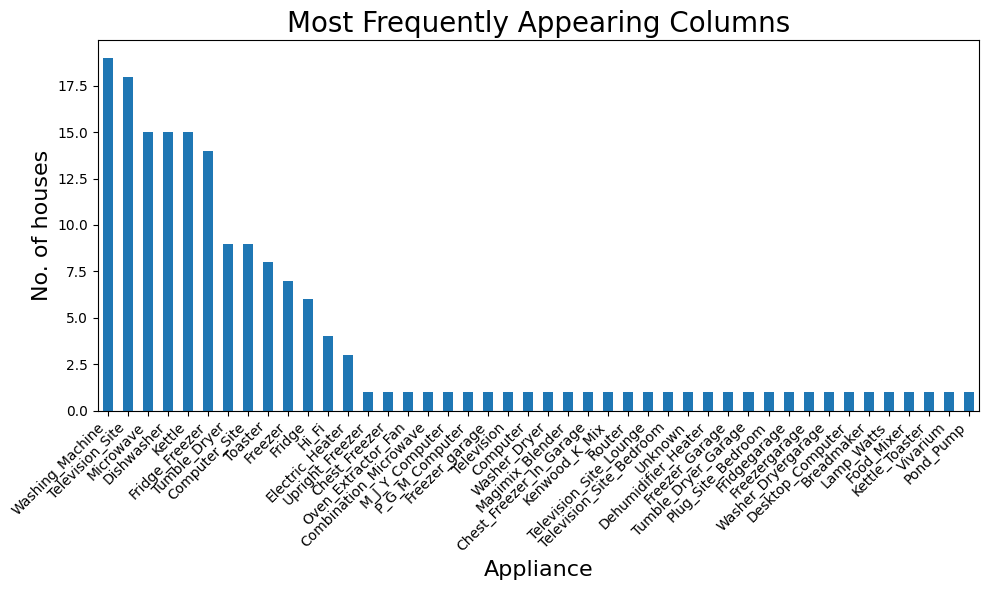

In [32]:
# Dictionary containing dataframes
house_dataframes = {
    "house_1": house_1,
    "house_2": house_2,
    "house_3": house_3,
    "house_4": house_4,
    "house_5": house_5,
    "house_6": house_6,
    "house_7": house_7,
    "house_8": house_8,
    "house_9": house_9,
    "house_10": house_10,
    "house_11": house_11,
    "house_12": house_12,
    "house_13": house_13,
    "house_14": house_14,
    "house_15": house_15,
    "house_16": house_16,
    "house_17": house_17,
    "house_18": house_18,
    "house_19": house_19,
    "house_20": house_20
}

# List to store column names from all dataframes
all_columns = []

# Iterate over each house dataframe
for df in house_dataframes.values():
    # Get the column names of the current dataframe and add them to the list
    all_columns.extend(df.columns)

# Columns to be dropped
columns_to_drop = ['Unix', 'Time', 'Aggregate']
# Remove the columns to be dropped
all_columns = [col for col in all_columns if col not in columns_to_drop]

# Count the frequency of each column name
column_counts = pd.Series(all_columns).value_counts()

# List to store top columns
top_columns_list = column_counts.reset_index().values.tolist()

# Print the top columns and their frequencies
print("Most Frequently Appearing Columns:")
for col, freq in top_columns_list:
    print(f"{col}: {freq}")

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
column_counts.plot(kind='bar')
plt.title('Most Frequently Appearing Columns', fontsize = 20)
plt.xlabel('Appliance', fontsize = 16)
plt.ylabel('No. of houses', fontsize = 16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
from itertools import combinations

# List of all appliances
all_appliances = [
    'Washing_Machine', 'Television_Site', 'Microwave', 'Dishwasher',
    'Kettle', 'Fridge_Freezer', 'Tumble_Dryer', 'Computer_Site',
    'Toaster', 'Freezer', 'Fridge', 'Hi_Fi', 'Electric_Heater'
]

# Dictionary to store the count of houses for each combination
combination_count = {}

# Generate all possible combinations of appliances
for r in range(3, len(all_appliances) + 1):
    for combo in combinations(all_appliances, r):
        combination_count[combo] = 0

# Iterate through each house and update the count for each combination
for df_name, df in house_dataframes.items():
    house_appliances = set(df.columns)
    for combo in combination_count.keys():
        if set(combo).issubset(house_appliances):
            combination_count[combo] += 1
result_list = []

# Print the count for each combination that has more than 2 houses
for combo, count in combination_count.items():
    if count > 2:
      result_list.append((combo, count))
      print(f"Appliances: {combo}, Houses: {count}")


Appliances: ('Washing_Machine', 'Television_Site', 'Microwave'), Houses: 13
Appliances: ('Washing_Machine', 'Television_Site', 'Dishwasher'), Houses: 14
Appliances: ('Washing_Machine', 'Television_Site', 'Kettle'), Houses: 13
Appliances: ('Washing_Machine', 'Television_Site', 'Fridge_Freezer'), Houses: 12
Appliances: ('Washing_Machine', 'Television_Site', 'Tumble_Dryer'), Houses: 9
Appliances: ('Washing_Machine', 'Television_Site', 'Computer_Site'), Houses: 8
Appliances: ('Washing_Machine', 'Television_Site', 'Toaster'), Houses: 7
Appliances: ('Washing_Machine', 'Television_Site', 'Freezer'), Houses: 7
Appliances: ('Washing_Machine', 'Television_Site', 'Fridge'), Houses: 5
Appliances: ('Washing_Machine', 'Television_Site', 'Hi_Fi'), Houses: 3
Appliances: ('Washing_Machine', 'Television_Site', 'Electric_Heater'), Houses: 3
Appliances: ('Washing_Machine', 'Microwave', 'Dishwasher'), Houses: 10
Appliances: ('Washing_Machine', 'Microwave', 'Kettle'), Houses: 12
Appliances: ('Washing_Machin

                                            Appliances  Houses  Num_Appliances
311     (Washing_Machine, Television_Site, Dishwasher)      14               3
398  (Washing_Machine, Television_Site, Microwave, ...      11               4
378  (Washing_Machine, Television_Site, Microwave, ...       7               5
325  (Washing_Machine, Television_Site, Dishwasher,...       4               6
327  (Washing_Machine, Television_Site, Dishwasher,...       3               7


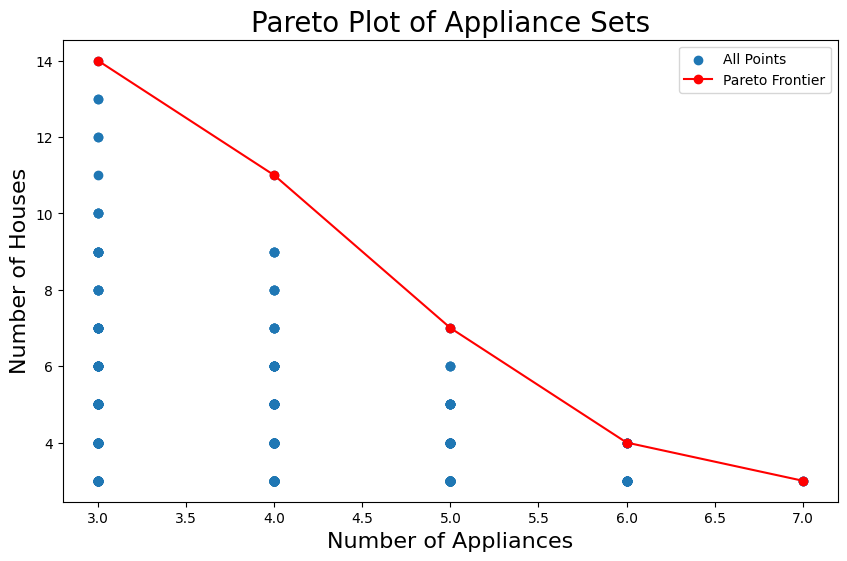

In [35]:
# Convert to DataFrame
df = pd.DataFrame(result_list, columns=['Appliances', 'Houses'])
# Extract the number of appliances in each set
df['Num_Appliances'] = df['Appliances'].apply(len)

# Group by unique sets of appliances and count the number of houses
unique_sets = df.groupby('Appliances').agg({
    'Houses': 'sum',
    'Num_Appliances': 'first'  # Number of appliances is the same within each group
}).reset_index()

def pareto_frontier(data):
    # Sort the data by the number of appliances and then by the number of houses (descending)
    data = data.sort_values(['Num_Appliances','Houses'], ascending=[True, False])
    pareto_points = []

    # Initialize the highest number of houses seen so far
    highest_houses = 0

    # Loop through the data to find the Pareto points
    for index, row in data.iterrows():
        if row['Num_Appliances'] > highest_houses:
            pareto_points.append(row)
            highest_houses = row['Num_Appliances']

    return pd.DataFrame(pareto_points)

# Find the Pareto frontier
pareto_front = pareto_frontier(unique_sets)

# Display the Pareto frontier
print(pareto_front)

# Plot the Pareto frontier
plt.figure(figsize=(10, 6))
plt.scatter(unique_sets['Num_Appliances'], unique_sets['Houses'], label='All Points')
plt.plot(pareto_front['Num_Appliances'], pareto_front['Houses'], color='red', marker='o', linestyle='-', label='Pareto Frontier')
plt.xlabel('Number of Appliances', fontsize = 16)
plt.ylabel('Number of Houses', fontsize = 16)
plt.title('Pareto Plot of Appliance Sets', fontsize = 20)
plt.legend()
plt.show()


In [36]:
desired_combinations = [combo for combo, count in result_list if len(combo) == 5 and count == 7]

# Print the desired combinations
for combo in desired_combinations:
    print(f"Appliances: {combo}, Houses: 7")

Appliances: ('Washing_Machine', 'Television_Site', 'Microwave', 'Dishwasher', 'Kettle'), Houses: 7
Appliances: ('Washing_Machine', 'Television_Site', 'Microwave', 'Kettle', 'Fridge_Freezer'), Houses: 7


In [37]:
common_columns = ['Time','Unix','Aggregate','Washing_Machine', 'Television_Site', 'Microwave', 'Dishwasher', 'Kettle']

# Convert the list of common columns into a set for faster lookup
common_columns_set = set(common_columns)

# List to store dataframes containing common columns
dataframes_with_common_columns = []

# Iterate through each dataframe
for df_name, df in house_dataframes.items():
    # Check if all common columns are present in the dataframe
    if common_columns_set.issubset(set(df.columns)):
        dataframes_with_common_columns.append(df_name)

# Print the names of the dataframes containing all common columns
print("Dataframes containing all common columns as a subset:")
for df_name in dataframes_with_common_columns:
    print(df_name)

Dataframes containing all common columns as a subset:
house_2
house_3
house_6
house_9
house_13
house_14
house_19


In [38]:
# List of the house dataframes to be merged
houses_to_merge = ['house_2', 'house_3', 'house_6', 'house_9', 'house_13', 'house_14', 'house_19']

# Collecting the dataframes to merge
dfs_to_merge = [house_dataframes[house] for house in houses_to_merge]

# Merging the dataframes vertically
merged_df = pd.concat(dfs_to_merge, axis=0)

# Resetting the index (optional, but usually useful after concatenation)
merged_df.reset_index(drop=True, inplace=True)

# Display the merged dataframe
merged_df.head(5)

,Time,Unix,Aggregate,Fridge_Freezer,Washing_Machine,Dishwasher,Television_Site,Microwave,Toaster,Hi_Fi,...,Oven_Extractor_Fan,Freezer,Tumble_Dryer,M_J_Y_Computer,P_G_M_Computer,Washer_Dryer,Electric_Heater,Unknown,Computer_Site,Fridge
0,2013-09-17 22:08:11,1379455691,695,88.00,0,0,0,0,0.00,0.00,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-09-17 22:08:18,1379455698,694,88.00,0,0,0,0,0.00,0.00,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-09-17 22:08:26,1379455706,694,88.00,0,0,0,0,0.00,0.00,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-09-17 22:08:34,1379455714,702,88.00,0,0,0,0,0.00,0.00,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-09-17 22:08:42,1379455722,700,88.00,0,0,0,0,0.00,0.00,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
merged_df = merged_df[common_columns]
merged_df = merged_df.sort_values(by='Unix', ascending=True)
merged_df.head(5)

,Time,Unix,Aggregate,Washing_Machine,Television_Site,Microwave,Dishwasher,Kettle
0,2013-09-17 22:08:11,1379455691,695,0,0,0,0,0
1,2013-09-17 22:08:18,1379455698,694,0,0,0,0,0
2,2013-09-17 22:08:26,1379455706,694,0,0,0,0,0
3,2013-09-17 22:08:34,1379455714,702,0,0,0,0,0
4,2013-09-17 22:08:42,1379455722,700,0,0,0,0,0


In [40]:
sorted_merged_df = merged_df.drop_duplicates(subset=['Unix'])
sorted_merged_df.head(5)

,Time,Unix,Aggregate,Washing_Machine,Television_Site,Microwave,Dishwasher,Kettle
0,2013-09-17 22:08:11,1379455691,695,0,0,0,0,0
1,2013-09-17 22:08:18,1379455698,694,0,0,0,0,0
2,2013-09-17 22:08:26,1379455706,694,0,0,0,0,0
3,2013-09-17 22:08:34,1379455714,702,0,0,0,0,0
4,2013-09-17 22:08:42,1379455722,700,0,0,0,0,0


In [41]:
# Calculate the sum of individual appliances
sorted_merged_df['Appliance_Sum'] = sorted_merged_df[['Washing_Machine', 'Television_Site', 'Microwave', 'Dishwasher', 'Kettle']].sum(axis=1)

# Identify rows where appliance sum is greater than aggregate
discrepancies = sorted_merged_df[sorted_merged_df['Appliance_Sum'] > sorted_merged_df['Aggregate']]

# Print the discrepancies
print(discrepancies)

                         Time        Unix  Aggregate  Washing_Machine  \
5380      2013-09-18 07:25:53  1379489153        913                0   
5382      2013-09-18 07:26:07  1379489167        112                0   
5383      2013-09-18 07:26:10  1379489170        112                0   
5384      2013-09-18 07:26:15  1379489175        112                0   
5386      2013-09-18 07:26:24  1379489184        112                0   
...                       ...         ...        ...              ...   
25138179  2015-07-08 16:08:31  1436371711       2792                0   
25138187  2015-07-08 16:09:26  1436371766       2818                0   
25138337  2015-07-08 16:26:44  1436372804        496                0   
25138680  2015-07-08 17:06:04  1436375164        321                0   
25138681  2015-07-08 17:06:11  1436375171        321                0   

          Television_Site  Microwave  Dishwasher  Kettle  Appliance_Sum  
5380                   29       1218           0 

In [42]:
# Remove rows where appliance sum is greater than aggregate
sorted_merged_df = sorted_merged_df[sorted_merged_df['Appliance_Sum'] <= sorted_merged_df['Aggregate']]

# Drop the Appliance_Sum column as it's no longer needed
sorted_merged_df.drop(columns=['Appliance_Sum'], inplace=True)

# Print the cleaned DataFrame
print(sorted_merged_df.head())

                  Time        Unix  Aggregate  Washing_Machine  \
0  2013-09-17 22:08:11  1379455691        695                0   
1  2013-09-17 22:08:18  1379455698        694                0   
2  2013-09-17 22:08:26  1379455706        694                0   
3  2013-09-17 22:08:34  1379455714        702                0   
4  2013-09-17 22:08:42  1379455722        700                0   

   Television_Site  Microwave  Dishwasher  Kettle  
0                0          0           0       0  
1                0          0           0       0  
2                0          0           0       0  
3                0          0           0       0  
4                0          0           0       0  


In [43]:
# Set datetime as index
sorted_merged_df['Time'] = pd.to_datetime(sorted_merged_df['Time'])
sorted_merged_df.set_index('Time', inplace=True)

In [44]:
sorted_merged_df.head()

,Unix,Aggregate,Washing_Machine,Television_Site,Microwave,Dishwasher,Kettle
Time,,,,,,,
2013-09-17 22:08:11,1379455691,695,0,0,0,0,0
2013-09-17 22:08:18,1379455698,694,0,0,0,0,0
2013-09-17 22:08:26,1379455706,694,0,0,0,0,0
2013-09-17 22:08:34,1379455714,702,0,0,0,0,0
2013-09-17 22:08:42,1379455722,700,0,0,0,0,0


In [ ]:
sorted_merged_df.describe()

,Unix,Aggregate,Washing_Machine,Television_Site,Microwave,Dishwasher,Kettle
count,2.478030e+07,2.478030e+07,2.478030e+07,2.478030e+07,2.478030e+07,2.478030e+07,2.478030e+07
mean,1.411972e+09,4.959831e+02,1.599159e+01,3.174029e+01,3.804379e+00,2.894668e+01,1.683612e+01
std,1.438945e+07,8.036648e+02,1.629402e+02,5.279783e+01,6.303748e+01,2.407620e+02,2.067626e+02
min,1.379456e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.401331e+09,1.770000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.413775e+09,2.640000e+02,0.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.423721e+09,4.560000e+02,0.000000e+00,2.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00
max,1.436382e+09,6.583600e+04,2.746000e+03,2.603000e+03,2.560000e+03,2.720000e+03,3.047000e+03


In [11]:
# Function to perform stratified sampling based on monthly, daily, and hourly segments
def stratified_sampling(df, sample_frac=0.1):
    # Add 'Month', 'Day', and 'Hour' columns to facilitate stratified sampling
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour

    # Perform stratified sampling within each month-day-hour segment
    sampled_dfs = []

    for month in df['Month'].unique():
        for day in df[df['Month'] == month]['Day'].unique():
            for hour in df[(df['Month'] == month) & (df['Day'] == day)]['Hour'].unique():
                hourly_data = df[(df['Month'] == month) & (df['Day'] == day) & (df['Hour'] == hour)]
                if not hourly_data.empty:
                    sampled_hourly_data = hourly_data.sample(frac=sample_frac, random_state=42)
                    sampled_dfs.append(sampled_hourly_data)

    # Combine the sampled data from each hour
    sampled_df = pd.concat(sampled_dfs)

    # Drop the 'Month', 'Day', and 'Hour' columns as they are no longer needed
    sampled_df.drop(columns=['Month', 'Day', 'Hour'], inplace=True)

    return sampled_df

# Assuming sorted_merged_df is your original DataFrame with 'Time' as index
Perform stratified sampling
sample_frac = 0.1  # Fraction of data to sample within each hour
sampled_df = stratified_sampling(sorted_merged_df, sample_frac)
sampled_df = sampled_df.sort_values(by='Unix', ascending=True)
# # Print the sizes of the original and sampled dataframes
print("Original data size:", sorted_merged_df.shape)
print("Sampled data size:", sampled_df.shape)

sampled_df.head()

In [3]:
sampled_df = pd.read_csv('C:/Users/91787/Documents/Dissertation_Materials/sorted_merged_df.csv')
sampled_df['Time'] = pd.to_datetime(sampled_df['Time'])
sampled_df.set_index('Time', inplace=True)

In [4]:
sorted_merged_df = pd.read_csv('C:/Users/91787/Documents/Dissertation_Materials/original_sorted_merged_df.csv')
sorted_merged_df['Time'] = pd.to_datetime(sorted_merged_df['Time'])
sorted_merged_df.set_index('Time', inplace=True)

In [4]:
sampled_df.head()

,Unix,Aggregate,Washing_Machine,Television_Site,Microwave,Dishwasher,Kettle
Time,,,,,,,
2013-09-17 22:11:15,1379455875,815,0,0,0,0,0
2013-09-17 22:13:54,1379456034,686,0,0,0,0,0
2013-09-17 22:14:17,1379456057,694,0,0,0,0,0
2013-09-17 22:15:14,1379456114,690,0,0,0,0,0
2013-09-17 22:15:23,1379456123,697,0,0,0,0,0


In [9]:
description = sorted_merged_df[['Aggregate', 'Washing_Machine', 'Television_Site', 'Microwave', 'Dishwasher', 'Kettle']].describe().loc[['count', 'std', 'min', 'max']]
# Set pandas display option to disable scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print(description)

        Aggregate  Washing_Machine  Television_Site   Microwave  Dishwasher  \
count 24780296.00      24780296.00      24780296.00 24780296.00 24780296.00   
std        803.66           162.94            52.80       63.04      240.76   
min          0.00             0.00             0.00        0.00        0.00   
max      65836.00          2746.00          2603.00     2560.00     2720.00   

           Kettle  
count 24780296.00  
std        206.76  
min          0.00  
max       3047.00  


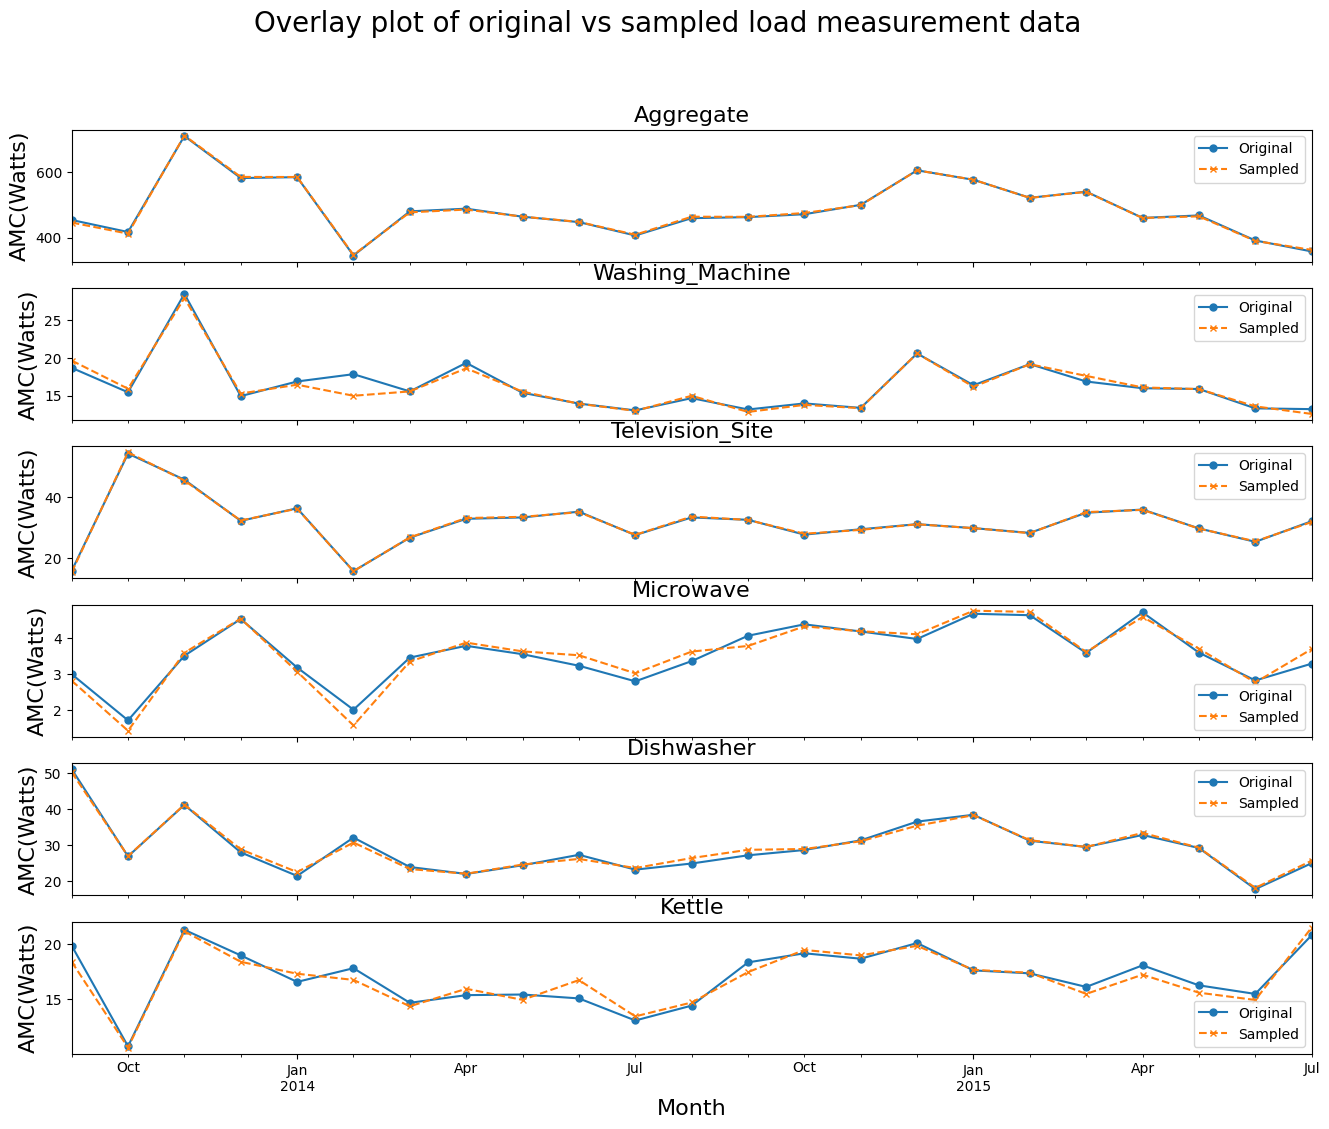

In [20]:
# Define the columns to plot
cols_plot = ['Aggregate', 'Washing_Machine', 'Television_Site', 'Microwave', 'Dishwasher', 'Kettle']

# Resample both dataframes to monthly data and calculate the mean
original_monthly_df = sorted_merged_df.resample('M').mean()
sampled_monthly_df = sampled_df.resample('M').mean()

# Create subplots
fig, axes = plt.subplots(nrows=len(cols_plot), ncols=1, figsize=(16, 12), sharex=True)
fig.suptitle('Overlay plot of original vs sampled load measurement data ', fontsize=20)

# Plot both the original and sampled data on the same axes
for i, col in enumerate(cols_plot):
    ax = axes[i]
    original_monthly_df[col].plot(ax=ax, marker='o', markersize=5, linestyle='-', label='Original')
    sampled_monthly_df[col].plot(ax=ax, marker='x', markersize=5, linestyle='--', label='Sampled')
    ax.set_ylabel('AMC(Watts)', fontsize=16)
    ax.legend()
    ax.set_title(col, fontsize=16)
    ax.set_xlabel('Month', fontsize = 16)

# Add the description to the bottom of the plot
plt.show()

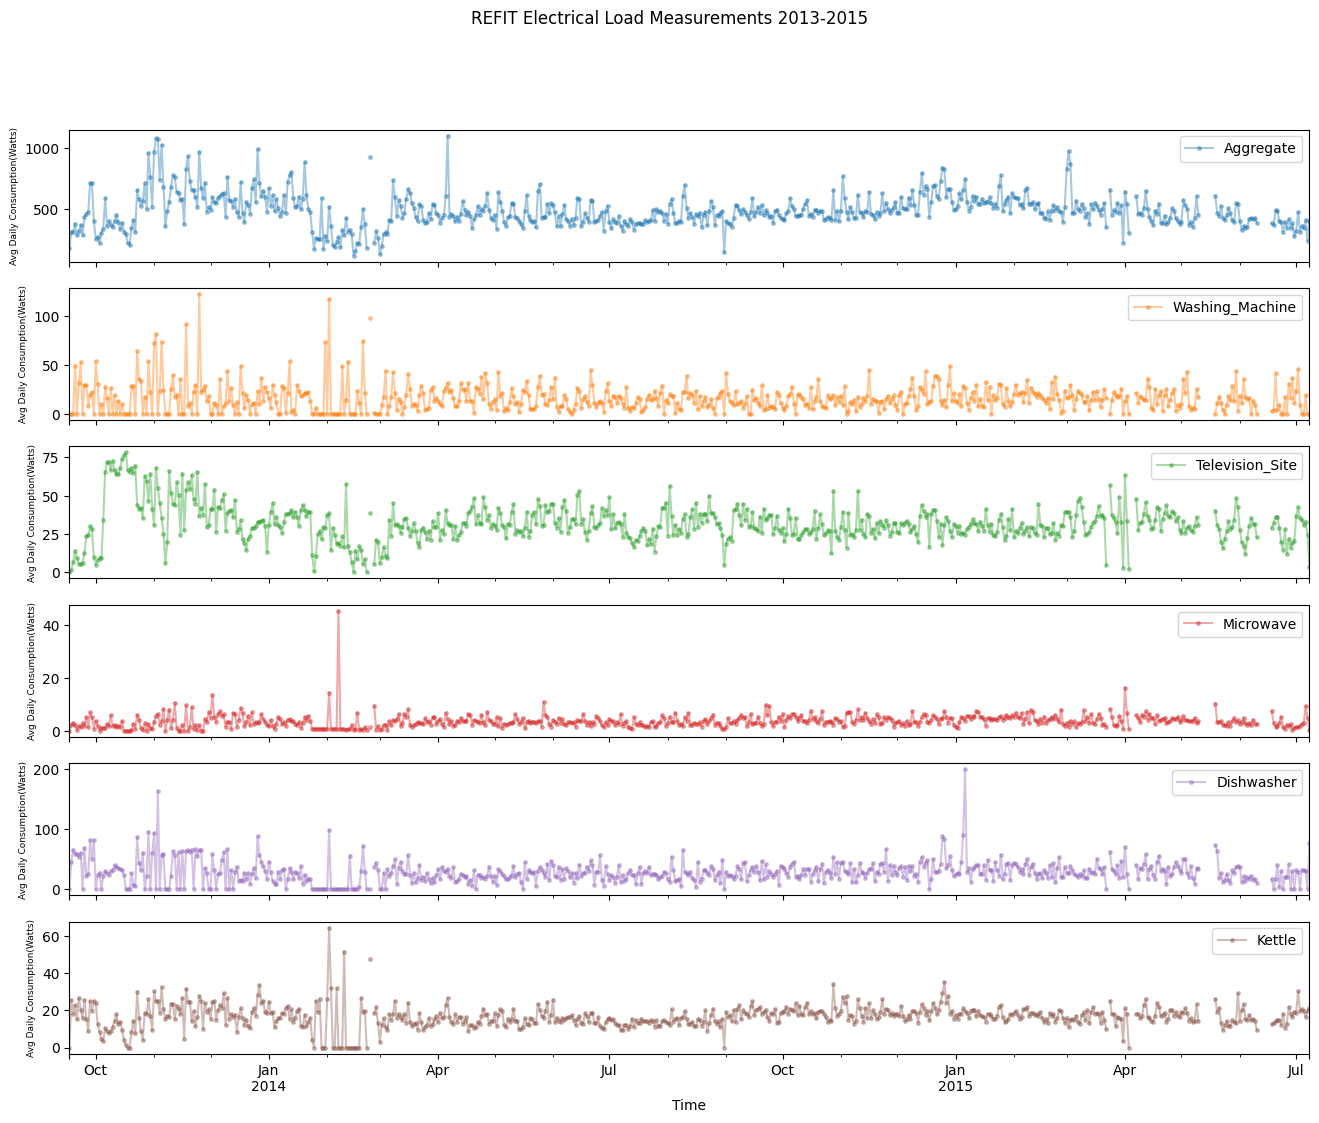

In [ ]:
cols_plot = ['Aggregate', 'Washing_Machine', 'Television_Site',	'Microwave', 'Dishwasher', 'Kettle']
daily_df = sorted_merged_df.resample('D').mean()  # Resample to daily and take the mean
axes = daily_df[cols_plot].plot(marker='.', alpha=0.4, linestyle='-', markersize=5,
        figsize=(16, 12), subplots=True, title='REFIT Electrical Load Measurements 2013-2015')
for ax in axes:
    ax.set_ylabel('Avg Daily Consumption(Watts)', fontsize = 6.5)

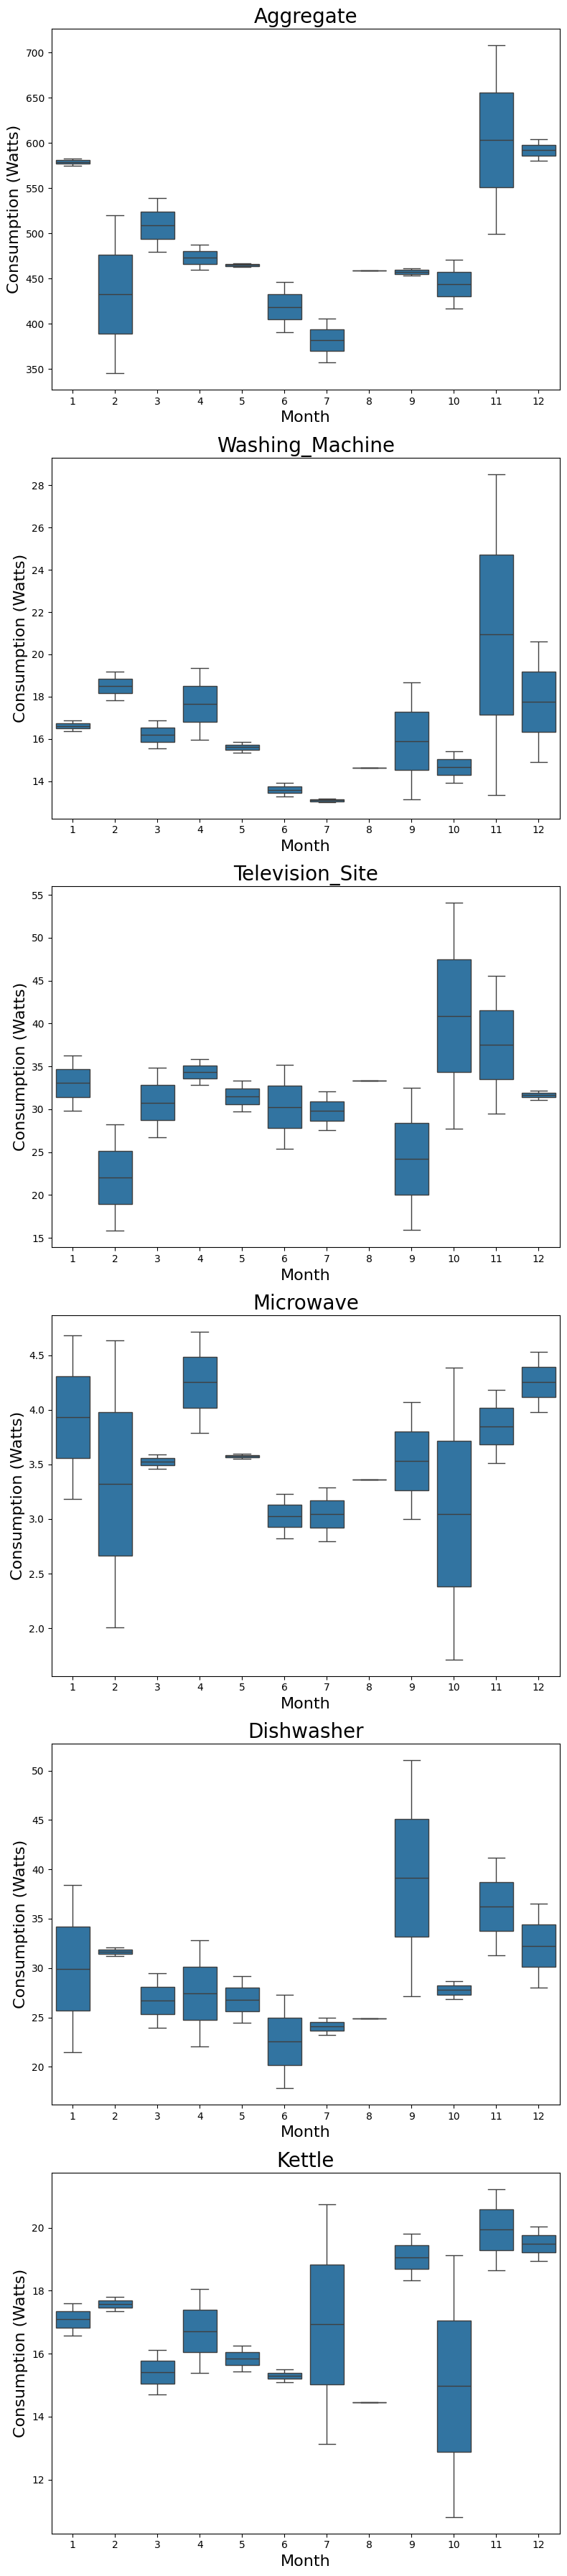

In [47]:

# Define the columns to plot
cols_plot = ['Aggregate', 'Washing_Machine', 'Television_Site', 'Microwave', 'Dishwasher', 'Kettle']

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(nrows=len(cols_plot), ncols=1, figsize=(8, 36))
monthly_df = sorted_merged_df.resample('M').mean()
# Iterate over the columns and create a boxplot for each
for i, col in enumerate(cols_plot):
    ax = sns.boxplot(data=monthly_df, x=monthly_df.index.month, y=col, ax=axes[i])
    ax.set_ylabel('Consumption (Watts)', fontsize = 16)
    ax.set_xlabel('Month', fontsize = 16)
    ax.set_title(f'{col}', fontsize = 20)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Washing Machine

In [5]:
washing_machine_df = sorted_merged_df

In [7]:
washing_machine_df['Washing_Machine'] = washing_machine_df['Washing_Machine'].apply(lambda x: 1 if x != 0 else 0)

# Display the updated dataframe
washing_machine_df.head(5)

,Unix,Aggregate,Washing_Machine,Television_Site,Microwave,Dishwasher,Kettle
Time,,,,,,,
2013-09-17 22:08:11,1379455691,695,0,0,0,0,0
2013-09-17 22:08:18,1379455698,694,0,0,0,0,0
2013-09-17 22:08:26,1379455706,694,0,0,0,0,0
2013-09-17 22:08:34,1379455714,702,0,0,0,0,0
2013-09-17 22:08:42,1379455722,700,0,0,0,0,0


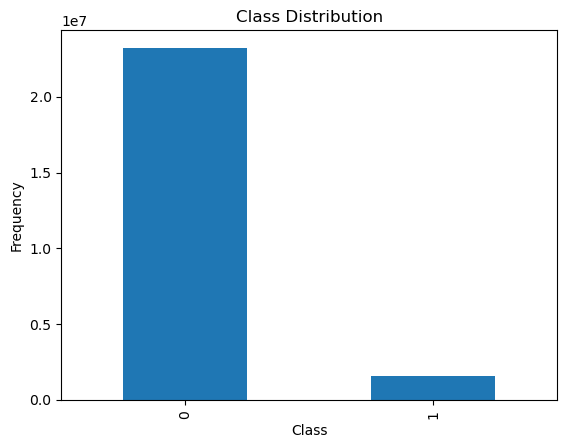

Imbalance Ratio: 14.95
Consider using oversampling or undersampling techniques.


In [8]:
from collections import Counter

# Check class distribution
class_distribution = washing_machine_df['Washing_Machine'].value_counts()

# Visualize class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Determine if sampling is needed
majority_class = class_distribution.idxmax()
minority_class = class_distribution.idxmin()
wm_imbalance_ratio = class_distribution[majority_class] / class_distribution[minority_class]
print(f'Imbalance Ratio: {wm_imbalance_ratio:.2f}')

# Generally, if the imbalance ratio is greater than 1.5 or 2, consider sampling techniques
if wm_imbalance_ratio > 2:
    print("Consider using oversampling or undersampling techniques.")
else:
    print("Class distribution is relatively balanced. No need for sampling techniques.")


In [9]:
# Separate features and target
X = washing_machine_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y = washing_machine_df['Washing_Machine']

total_rows = X.shape[0]  # total rows

# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)

# Create the training set (first 60%)
X_train = X[:rows_80_percent]
y_train = y[:rows_80_percent]

# Create the test set (last 20%)
X_test = X[-rows_20_percent:]
y_test = y[-rows_20_percent:]

# Identify the minority and majority classes
minority_class = y_train.value_counts().idxmin()
majority_class = y_train.value_counts().idxmax()

# Separate the data by class
minority_class_indices = y_train[y_train == minority_class].index
majority_class_indices = y_train[y_train == majority_class].index

# Define the desired number of samples from the majority class to balance the dataset
num_minority_samples = len(minority_class_indices)

# Function to under-sample the majority class while maintaining order
def under_sample_majority_class(df, majority_indices, num_samples):
    stride = len(majority_indices) // num_samples
    sampled_indices = majority_indices[::stride][:num_samples]
    return df.loc[sampled_indices]

# Under-sample the majority class
under_sampled_majority_df = under_sample_majority_class(X_train, majority_class_indices, num_minority_samples)
under_sampled_majority_labels = y_train[majority_class_indices][::(len(majority_class_indices) // num_minority_samples)][:num_minority_samples]

# Combine the minority class and under-sampled majority class
X_train_resampled = pd.concat([X_train.loc[minority_class_indices], under_sampled_majority_df])
y_train_resampled = pd.concat([y_train.loc[minority_class_indices], under_sampled_majority_labels])

# Sort the combined data to maintain the time order
X_train_resampled.sort_index(inplace=True)
y_train_resampled.sort_index(inplace=True)

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the resampled training features
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
# Transform the testing features
X_test_normalized = scaler.transform(X_test)

# Convert back to DataFrame for convenience
X_train_resampled_normalized_df = pd.DataFrame(X_train_resampled_normalized, columns=X.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X.columns)

In [ ]:
# Define the sequence length
sequence_length = 10

# Function to create sequences
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# Prepare the sequences for training data
X_train_sequences, y_train_sequences = create_sequences(X_train_resampled_normalized_df.values, y_train_resampled.values, sequence_length)

# Prepare the sequences for testing data
X_test_sequences, y_test_sequences = create_sequences(X_test_normalized_df.values, y_test.values, sequence_length)

In [ ]:
# Flatten the 3D array while preserving the order
X_train_sequences_2d = X_train_sequences.reshape(-1, X_train_sequences.shape[1])
# Print the shape of the 2D array
X_test_sequences_2d = X_test_sequences.reshape(-1, X_test_sequences.shape[1])

In [ ]:
#Hyperparameter tuning
# Downsample the data
wm_df = sampled_df
wm_df['Washing_Machine'] = wm_df['Washing_Machine'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_wm = wm_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_wm = wm_df['Washing_Machine']
total_rows = X_wm.shape[0]  # total rows
# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)
# Create the training set (first 60%)
X_wm_train = X_wm[:rows_60_percent]
y_wm_train = y_wm[:rows_60_percent]
X_wm_val = X_wm[-rows_20_percent:]
y_wm_val = y_wm[-rows_20_percent:]
# Identify the minority and majority classes
minority_class = y_wm_train.value_counts().idxmin()
majority_class = y_wm_train.value_counts().idxmax()
# Separate the data by class
minority_class_indices = y_wm_train[y_wm_train == minority_class].index
majority_class_indices = y_wm_train[y_wm_train == majority_class].index
# Define the desired number of samples from the majority class to balance the dataset
num_minority_samples = len(minority_class_indices)
# Under-sample the majority class
under_sampled_majority_df = under_sample_majority_class(X_wm_train, majority_class_indices, num_minority_samples)
under_sampled_majority_labels = y_wm_train[majority_class_indices][::(len(majority_class_indices) // num_minority_samples)][:num_minority_samples]
# Combine the minority class and under-sampled majority class
X_wm_train_resampled = pd.concat([X_wm_train.loc[minority_class_indices], under_sampled_majority_df])
y_wm_train_resampled = pd.concat([y_wm_train.loc[minority_class_indices], under_sampled_majority_labels])
# Sort the combined data to maintain the time order
X_wm_train_resampled.sort_index(inplace=True)
y_wm_train_resampled.sort_index(inplace=True)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_wm_train_resampled_normalized = scaler.fit_transform(X_wm_train_resampled)
X_wm_val_normalized = scaler.fit_transform(X_wm_val)
# Convert back to DataFrame for convenience
X_wm_train_resampled_normalized_df = pd.DataFrame(X_wm_train_resampled_normalized, columns=X.columns)
X_wm_val_normalized_df = pd.DataFrame(X_wm_val_normalized, columns=X.columns)
# Prepare the sequences for training data
X_wm_train_sequences, y_wm_train_sequences = create_sequences(X_wm_train_resampled_normalized_df.values, y_wm_train_resampled.values, sequence_length)
X_wm_val_sequences, y_wm_val_sequences = create_sequences(X_wm_val_normalized_df.values, y_wm_val.values, sequence_length)
# Flatten the 3D array while preserving the order
X_wm_train_sequences_2d = X_wm_train_sequences.reshape(-1, X_wm_train_sequences.shape[1])
X_wm_val_sequences_2d = X_wm_val_sequences.reshape(-1, X_wm_val_sequences.shape[1])

In [ ]:
# Downsample the data to 30-minute intervals and take the first appearing value
downsampled_wm_30m_df = sorted_merged_df.resample('30T').first()
# Drop rows with NaN values resulting from downsampling
downsampled_wm_30m_df.dropna(inplace=True)
wm_30m_df = downsampled_wm_30m_df.sort_values(by='Unix', ascending=True)
wm_30m_df['Washing_Machine'] = wm_30m_df['Washing_Machine'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_wm_30m = wm_30m_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_wm_30m = wm_30m_df['Washing_Machine']
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_wm_30m_normalized = scaler.fit_transform(X_wm_30m)
# Convert back to DataFrame for convenience
X_wm_30m_normalized_df = pd.DataFrame(X_wm_30m_normalized, columns=X_wm_30m.columns)
# Prepare the sequences for training data
X_wm_30m_sequences, y_wm_30m_sequences = create_sequences(X_wm_30m_normalized_df.values, y_wm_30m.values, sequence_length)
# Flatten the 3D array while preserving the order
X_wm_30m_sequences_2d = X_wm_30m_sequences.reshape(-1, X_wm_30m_sequences.shape[1])

LSTM

In [ ]:
def create_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_wm_train_sequences.shape[1], X_wm_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
      for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
          # Create and compile the model
          model = create_model(units, dropout_rate)
          # Train the model
          model.fit(X_wm_train_sequences, y_wm_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)
          print('Model training successful')

          # Evaluate the model on the validation set
          val_loss = model.evaluate(X_wm_val_sequences, y_wm_val_sequences, verbose=0)
          val_loss = val_loss[0] if isinstance(val_loss, list) else val_loss
          # Check if this is the best score so far
          if val_loss < best_score:
            best_score = val_loss
            best_params = {
                'units': units,
                'dropout_rate': dropout_rate,
                'batch_size': batch_size,
                'epochs': epochs
            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'units': 100, 'dropout_rate': 0.4, 'batch_size': 32, 'epochs': 30}
Best validation loss: 0.18476977944374084


In [ ]:
# Train the best model on the full training data and evaluate on the test set
lstm_model_wm = create_model(best_params['units'], best_params['dropout_rate'])
lstm_model_wm.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
lstm_model_wm.save('/content/drive/MyDrive/Saved_Models/lstm_model_wm_5a7h.h5')

In [ ]:
lstm_model_wm = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_wm_5a7h.h5') #load the model
y_pred = lstm_model_wm.predict(X_test_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_wm = accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_wm:.2f}')
# Print classification report
print(classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_test_sequences, y_pred_binary))

15488/15488 [==============================] - 47s 3ms/step
Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.94      0.80      0.87    465176
           1       0.08      0.26      0.12     30419

    accuracy                           0.77    495595
   macro avg       0.51      0.53      0.49    495595
weighted avg       0.89      0.77      0.82    495595

[[372029  93147]
 [ 22649   7770]]


In [ ]:
lstm_model_wm_30m = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_wm_5a7h.h5') #load the model
y_pred = lstm_model_wm_30m.predict(X_wm_30m_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_wm_30m = accuracy_score(y_wm_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_wm_30m:.2f}')
# Print classification report
print(classification_report(y_wm_30m_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_wm_30m_sequences, y_pred_binary))

918/918 [==============================] - 3s 3ms/step
Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     27720
           1       0.07      0.36      0.12      1631

    accuracy                           0.71     29351
   macro avg       0.51      0.55      0.47     29351
weighted avg       0.90      0.71      0.79     29351

[[20303  7417]
 [ 1046   585]]


RNN

Hyperparameter Tuning

In [ ]:
def create_rnn_model(units, dropout_rate, optimizer, activation):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30],
    'activation': ['tanh', 'relu']
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for optimizer in param_grid['optimizer']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    for activation in param_grid['activation']:
                        # Create and compile the model
                        model = create_rnn_model(units, dropout_rate, optimizer, activation)

                        # Train the model
                        model.fit(X_wm_train_sequences, y_wm_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                        # Evaluate the model on the validation set
                        val_loss = model.evaluate(X_wm_val_sequences, y_wm_val_sequences, verbose=0)

                        # Extract the loss value if necessary
                        if isinstance(val_loss, list):
                            val_loss = val_loss[0]

                        # Check if this is the best score so far
                        if val_loss < best_score:
                            best_score = val_loss
                            best_params = {
                                'units': units,
                                'dropout_rate': dropout_rate,
                                'optimizer': optimizer,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'activation': activation
                            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Best parameters: {'units': 150, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'batch_size': 32, 'epochs': 20, 'activation': 'relu'}
Best validation loss: 0.17054076492786407


In [ ]:
# Train the best model on the full training data and evaluate on the test set
rnn_model_wm = create_rnn_model(best_params['units'], best_params['dropout_rate'], best_params['optimizer'], best_params['activation'])
rnn_model_wm.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
rnn_model_wm.save('/content/drive/MyDrive/Saved_Models/rnn_model_wm_5a7h.h5')

In [ ]:
rnn_model_wm = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_wm_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_wm.predict(X_test_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_wm = balanced_accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_wm:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred_binary))

15488/15488 [==============================] - 26s 2ms/step
Accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92    465176
           1       0.09      0.16      0.12     30419

    accuracy                           0.85    495595
   macro avg       0.52      0.53      0.52    495595
weighted avg       0.89      0.85      0.87    495595

Confusion Matrix:
 [[418057  47119]
 [ 25660   4759]]


In [ ]:
rnn_model_wm_30m = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_wm_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_wm_30m.predict(X_wm_30m_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_wm_30m = balanced_accuracy_score(y_wm_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_wm_30m:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_wm_30m_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_wm_30m_sequences, y_pred_binary))

918/918 [==============================] - 2s 2ms/step
Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     27720
           1       0.09      0.22      0.13      1631

    accuracy                           0.83     29351
   macro avg       0.52      0.54      0.52     29351
weighted avg       0.90      0.83      0.86     29351

Confusion Matrix:
 [[24015  3705]
 [ 1272   359]]


FCN

Hyperparameter Tuning

In [ ]:
def create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer):
    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(GlobalAveragePooling1D())

    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'dropout_rate': [0.3, 0.4],  # Note: dropout isn't used in the base architecture, but you might want to test it
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for dropout_rate in param_grid['dropout_rate']:
                for optimizer_name in param_grid['optimizer']:
                    for batch_size in param_grid['batch_size']:
                        for epochs in param_grid['epochs']:
                            # Create optimizer instance
                            if optimizer_name == 'adam':
                                optimizer = Adam()
                            elif optimizer_name == 'rmsprop':
                                optimizer = RMSprop()

                            # Create and compile the model
                            model = create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer)

                            # Train the model
                            model.fit(X_wm_train_sequences, y_wm_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)
                            print('Model training successful')

                            # Evaluate the model on the validation set
                            val_loss, _ = model.evaluate(X_wm_val_sequences, y_wm_val_sequences, verbose=0)

                            # Check if this is the best score so far
                            if val_loss < best_score:
                                best_score = val_loss
                                best_params = {
                                    'filters1': filters1,
                                    'filters2': filters2,
                                    'filters3': filters3,
                                    'dropout_rate': dropout_rate,
                                    'optimizer': optimizer_name,
                                    'batch_size': batch_size,
                                    'epochs': epochs
                                }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best validation loss: 0.9363152384757996


In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
fcn_model_wm = create_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['dropout_rate'], best_optimizer)
fcn_model_wm.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
fcn_model_wm.save('/content/drive/MyDrive/Saved_Models/fcn_model_wm_5a7h.h5')

In [ ]:
fcn_model_wm = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_wm_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_wm.predict(X_test_sequences) > 0.5).astype(int)
accuracy_fcn_wm = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_wm:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

15488/15488 [==============================] - 42s 3ms/step
Accuracy: 0.06
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    465176
           1       0.06      1.00      0.12     30419

    accuracy                           0.06    495595
   macro avg       0.03      0.50      0.06    495595
weighted avg       0.00      0.06      0.01    495595

Confusion Matrix:
 [[     0 465176]
 [     0  30419]]


In [ ]:
fcn_model_wm_30m = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_wm_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_wm_30m.predict(X_wm_30m_sequences) > 0.5).astype(int)
accuracy_fcn_wm_30m = accuracy_score(y_wm_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_wm_30m:.2f}')
print("Classification Report:\n", classification_report(y_wm_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_wm_30m_sequences, y_pred))

918/918 [==============================] - 3s 3ms/step
Accuracy: 0.06
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     27720
           1       0.06      1.00      0.11      1631

    accuracy                           0.06     29351
   macro avg       0.03      0.50      0.05     29351
weighted avg       0.00      0.06      0.01     29351

Confusion Matrix:
 [[    0 27720]
 [    0  1631]]


GRU-FCN

Hyperparameter Tuning

In [ ]:
input_shape = (X_train_sequences.shape[1], X_train_sequences.shape[2])

def create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Permute layer
    permute_layer = Permute((2, 1))(input_layer)

    # FCN branch
    conv1 = Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1)(permute_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    # GRU branch
    gru = GRU(units=gru_units)(input_layer)
    gru = Dropout(dropout_rate)(gru)

    # Concatenate branches
    concat = Concatenate()([gap, gru])

    # Output layer
    output_layer = Dense(1, activation='softmax')(concat)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'gru_units': [8, 10],
    'dropout_rate': [0.3, 0.8],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for gru_units in param_grid['gru_units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for optimizer_name in param_grid['optimizer']:
                        for batch_size in param_grid['batch_size']:
                            for epochs in param_grid['epochs']:
                                # Create optimizer instance
                                if optimizer_name == 'adam':
                                    optimizer = Adam()
                                elif optimizer_name == 'rmsprop':
                                    optimizer = RMSprop()

                                # Create and compile the model
                                model = create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape)

                                # Train the model
                                model.fit(X_wm_train_sequences, y_wm_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                                # Evaluate the model on the validation set
                                val_loss, _ = model.evaluate(X_wm_val_sequences, y_wm_val_sequences, verbose=0)

                                # Check if this is the best score so far
                                if val_loss < best_score:
                                    best_score = val_loss
                                    best_params = {
                                        'filters1': filters1,
                                        'filters2': filters2,
                                        'filters3': filters3,
                                        'gru_units': gru_units,
                                        'dropout_rate': dropout_rate,
                                        'optimizer': optimizer_name,
                                        'batch_size': batch_size,
                                        'epochs': epochs
                                    }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'gru_units': 8, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best validation loss: 0.9329202771186829


In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
gru_fcn_model_wm = create_gru_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['gru_units'], best_params['dropout_rate'], best_optimizer, input_shape)
gru_fcn_model_wm.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
gru_fcn_model_wm.save('/content/drive/MyDrive/Saved_Models/gru_fcn_model_wm_5a7h.h5')

In [ ]:
gru_fcn_model_wm = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_wm_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_wm.predict(X_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_wm = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_wm:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

15488/15488 [==============================] - 31s 2ms/step
Accuracy: 0.06
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    465176
           1       0.06      1.00      0.12     30419

    accuracy                           0.06    495595
   macro avg       0.03      0.50      0.06    495595
weighted avg       0.00      0.06      0.01    495595

Confusion Matrix:
 [[     0 465176]
 [     0  30419]]


In [ ]:
gru_fcn_model_wm_30m = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_wm_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_wm_30m.predict(X_wm_30m_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_wm_30m = accuracy_score(y_wm_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_wm_30m:.2f}')
print("Classification Report:\n", classification_report(y_wm_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_wm_30m_sequences, y_pred))

918/918 [==============================] - 3s 2ms/step
Accuracy: 0.06
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     27720
           1       0.06      1.00      0.11      1631

    accuracy                           0.06     29351
   macro avg       0.03      0.50      0.05     29351
weighted avg       0.00      0.06      0.01     29351

Confusion Matrix:
 [[    0 27720]
 [    0  1631]]


Learning Shapelets

In [ ]:
param_grid = {
    'n_shapelets_per_size': [0.2, 0.3],  # Fraction of the number of timestamps
    'min_shapelet_length': [0.1, 0.2],  # Fraction of the number of timestamps
    'shapelet_scale': [2, 4],              # Different scales for the lengths of the shapelets
    'penalty': ['l2', 'l1'],                  # Norm used in the penalization
    'tol': [0.001, 0.1],                     # Tolerance for stopping criterion
    'C': [100, 1000]                      # Scaling term in the softmin function
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    shapelet_clf = LearningShapelets(
        n_shapelets_per_size=params['n_shapelets_per_size'],
        min_shapelet_length=params['min_shapelet_length'],
        shapelet_scale=params['shapelet_scale'],
        penalty=params['penalty'],
        tol=params['tol'],
        C=params['C']
    )

    # Train the model on the training data
    shapelet_clf.fit(X_wm_train_sequences_2d, y_wm_train_sequences)
    print("Model training successful")
    # Predict on the validation set
    y_val_pred = shapelet_clf.predict(X_wm_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_wm_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model traini

In [ ]:
learning_shapelets_wm = LearningShapelets(
        n_shapelets_per_size=best_params['n_shapelets_per_size'],
        min_shapelet_length=best_params['min_shapelet_length'],
        shapelet_scale=best_params['shapelet_scale'],
        penalty=best_params['penalty'],
        tol=best_params['tol'],
        C=best_params['C']
    )
learning_shapelets_wm.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_wm_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(learning_shapelets_wm, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_wm_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_wm = pickle.load(file)
y_pred = learning_shapelets_wm.predict(X_test_sequences_2d)
accuracy_ls_wm = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_wm:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.06
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     32481
           1       0.06      1.00      0.11      2060

    accuracy                           0.06     34541
   macro avg       0.03      0.50      0.06     34541
weighted avg       0.00      0.06      0.01     34541

Confusion Matrix:
 [[    0 32481]
 [    0  2060]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_wm_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_wm_30m = pickle.load(file)
y_pred = learning_shapelets_wm_30m.predict(X_wm_30m_sequences_2d)
accuracy_ls_wm_30m = accuracy_score(y_wm_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_wm_30m:.2f}')
print("Classification Report:\n", classification_report(y_wm_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_wm_30m_sequences, y_pred))

Accuracy: 0.06
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     27720
           1       0.06      1.00      0.11      1631

    accuracy                           0.06     29351
   macro avg       0.03      0.50      0.05     29351
weighted avg       0.00      0.06      0.01     29351

Confusion Matrix:
 [[    0 27720]
 [    0  1631]]


Time Series Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'min_interval': [3, 5],
    'n_jobs': [-1]
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    tsf_clf = TimeSeriesForestClassifier(
        n_estimators=params['n_estimators'],
        min_interval=params['min_interval'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    tsf_clf.fit(X_wm_train_sequences_2d, y_wm_train_sequences)

    # Predict on the validation set
    y_val_pred = tsf_clf.predict(X_wm_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_wm_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'n_estimators': 100, 'min_interval': 3, 'n_jobs': -1}
Validation accuracy with best parameters: 0.6823774644625228


In [ ]:
tsf_wm = TimeSeriesForestClassifier(
        n_estimators=best_params['n_estimators'],
        min_interval=best_params['min_interval'],
        n_jobs=best_params['n_jobs']
    )

tsf_wm.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_wm_5a7h"
mlflow_sktime.save_model(
    sktime_model=tsf_wm,
    path=model_path)

In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_wm_5a7h"
# Load the model from the specified file path
tsf_wm = mlflow_sktime.load_model(model_uri=model_path)
# Predict on the test set
y_pred = tsf_wm.predict(X_test_sequences_2d)
accuracy_tsf_wm = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_wm:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87    465176
           1       0.08      0.27      0.13     30419

    accuracy                           0.78    495595
   macro avg       0.51      0.54      0.50    495595
weighted avg       0.89      0.78      0.83    495595

Confusion Matrix:
 [[377188  87988]
 [ 22259   8160]]


In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_wm_5a7h"
# Load the model from the specified file path
tsf_wm_30m = mlflow_sktime.load_model(model_uri=model_path)
# Predict on the test set
y_pred = tsf_wm_30m.predict(X_wm_30m_sequences_2d)
accuracy_tsf_wm_30m = accuracy_score(y_wm_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_wm_30m:.2f}')
print("Classification Report:\n", classification_report(y_wm_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_wm_30m_sequences, y_pred))

Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.76      0.84     27720
           1       0.07      0.29      0.11      1631

    accuracy                           0.74     29351
   macro avg       0.51      0.53      0.48     29351
weighted avg       0.90      0.74      0.80     29351

Confusion Matrix:
 [[21102  6618]
 [ 1159   472]]


Rocket

In [ ]:
param_grid = {
    'num_kernels': [10000,15000],  # Number of kernels for the Rocket transform
    'rocket_transform': ['rocket'],
#    'rocket_transform': ['rocket', 'minirocket', 'multirocket'],  # Type of Rocket transformer to use
    'max_dilations_per_kernel': [32,64],  # Max number of dilations per kernel (MiniRocket and MultiRocket only)
    'n_features_per_kernel': [4,8],  # Number of features per kernel (MultiRocket only)
    'use_multivariate': ['no'],  # Whether to use multivariate Rocket transforms or univariate ones
    'n_jobs': [-1]  # Number of jobs to run in parallel for both fit and predict
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    rocket_clf = RocketClassifier(
        num_kernels=params['num_kernels'],
        rocket_transform=params['rocket_transform'],
        max_dilations_per_kernel=params['max_dilations_per_kernel'],  # Default to 32 if not provided
        n_features_per_kernel=params['n_features_per_kernel'],  # Default to 4 if not provided
        use_multivariate=params['use_multivariate'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    rocket_clf.fit(X_wm_train_sequences_2d, y_wm_train_sequences)

    # Predict on the validation set
    y_val_pred = rocket_clf.predict(X_wm_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_wm_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'num_kernels': 15000, 'rocket_transform': 'rocket', 'max_dilations_per_kernel': 32, 'n_features_per_kernel': 8, 'use_multivariate': 'no', 'n_jobs': -1}
Validation accuracy with best parameters: 0.5268810978257723


In [ ]:
rocket_wm = RocketClassifier(
        num_kernels=best_params['num_kernels'],
        rocket_transform=best_params['rocket_transform'],
        max_dilations_per_kernel=best_params['max_dilations_per_kernel'],
        n_features_per_kernel=best_params['n_features_per_kernel'],
        use_multivariate=best_params['use_multivariate'],
        n_jobs=best_params['n_jobs']
    )
rocket_wm.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/sktime_models/rocket_model_wm_5a7h"
mlflow_sktime.save_model(
    sktime_model=rocket_wm,
    path=model_path)

In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/rocket_model_wm_5a7h"
# Load the model from the specified file path
rocket_wm = mlflow_sktime.load_model(model_uri=model_path)
# Predict on the test set
y_pred = rocket_wm.predict(X_test_sequences_2d)
accuracy_rocket_wm = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_wm:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.52
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.52      0.67     32481
           1       0.06      0.47      0.10      2060

    accuracy                           0.52     34541
   macro avg       0.50      0.49      0.39     34541
weighted avg       0.89      0.52      0.64     34541

Confusion Matrix:
 [[16927 15554]
 [ 1095   965]]


In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/rocket_model_wm_5a7h"
# Load the model from the specified file path
rocket_wm_30m = mlflow_sktime.load_model(model_uri=model_path)
# Predict on the test set
y_pred = rocket_wm_30m.predict(X_wm_30m_sequences_2d)
accuracy_rocket_wm_30m = accuracy_score(y_wm_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_wm_30m:.2f}')
print("Classification Report:\n", classification_report(y_wm_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_wm_30m_sequences, y_pred))

Accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.54      0.68     27720
           1       0.06      0.49      0.11      1631

    accuracy                           0.53     29351
   macro avg       0.50      0.52      0.40     29351
weighted avg       0.90      0.53      0.65     29351

Confusion Matrix:
 [[14860 12860]
 [  824   807]]


BOSS

In [ ]:
param_grid = {
    'alphabet_size': [2, 4],  # Number of possible letters (values) for each word
    'n_jobs': [-1],  # Number of jobs to run in parallel for both fit and predict
    'feature_selection': ['chi2', 'none', 'random']  # Sets the feature selections strategy to be used
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    boss_clf = BOSSEnsemble(
        alphabet_size=params['alphabet_size'],
        n_jobs=params['n_jobs'],
        feature_selection=params['feature_selection']
    )

    # Train the model on the training data
    boss_clf.fit(X_wm_train_sequences_2d, y_wm_train_sequences)
    print("Model training successful")
    # Predict on the validation set
    y_val_pred = boss_clf.predict(X_wm_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_wm_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'alphabet_size': 4, 'n_jobs': -1, 'feature_selection': 'chi2'}
Validation accuracy with best parameters: 0.9264062997597059


In [ ]:
boss_wm = BOSSEnsemble(
        alphabet_size=best_params['alphabet_size'],
        n_jobs=best_params['n_jobs'],
        feature_selection=best_params['feature_selection']
    )
boss_wm.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_wm_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(boss_wm, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_wm_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_wm = pickle.load(file)
# Predict on the test set
y_pred = boss_wm.predict(X_test_sequences_2d)
accuracy_boss_wm = balanced_accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_wm:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     32481
           1       0.11      0.02      0.03      2060

    accuracy                           0.93     34541
   macro avg       0.53      0.50      0.50     34541
weighted avg       0.89      0.93      0.91     34541

Confusion Matrix:
 [[32173   308]
 [ 2022    38]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_wm_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_wm_30m = pickle.load(file)
# Predict on the test set
y_pred = boss_wm_30m.predict(X_wm_30m_sequences_2d)
accuracy_boss_wm_30m = balanced_accuracy_score(y_wm_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_wm_30m:.2f}')
print("Classification Report:\n", classification_report(y_wm_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_wm_30m_sequences, y_pred))

Accuracy: 0.51
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     27720
           1       0.15      0.03      0.04      1631

    accuracy                           0.94     29351
   macro avg       0.55      0.51      0.51     29351
weighted avg       0.90      0.94      0.92     29351

Confusion Matrix:
 [[27473   247]
 [ 1589    42]]


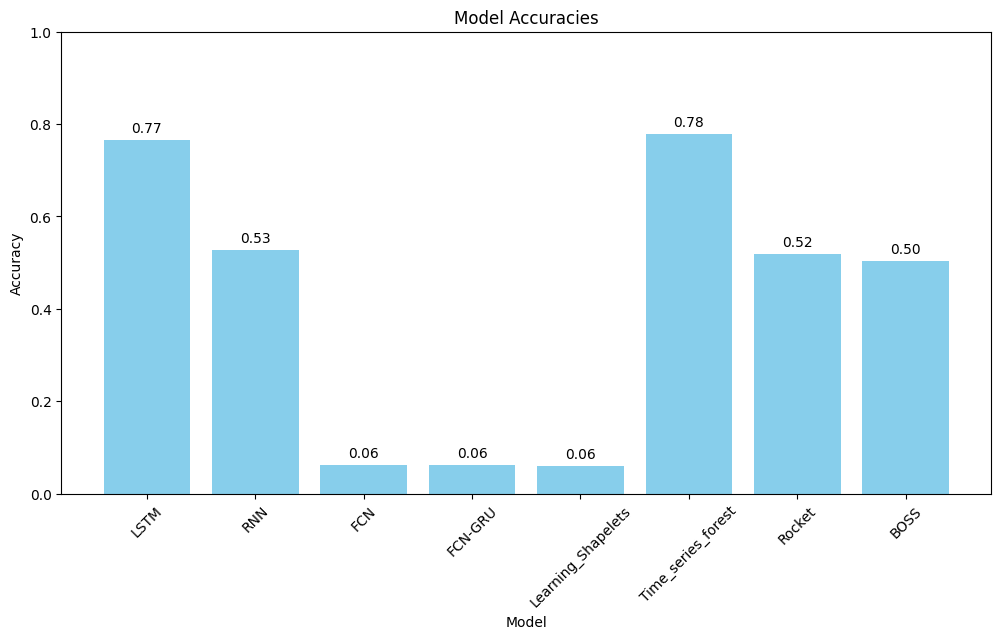

In [ ]:
accuracies = [accuracy_lstm_wm, accuracy_rnn_wm, accuracy_fcn_wm, accuracy_gru_fcn_wm, accuracy_ls_wm, accuracy_tsf_wm, accuracy_rocket_wm, accuracy_boss_wm]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

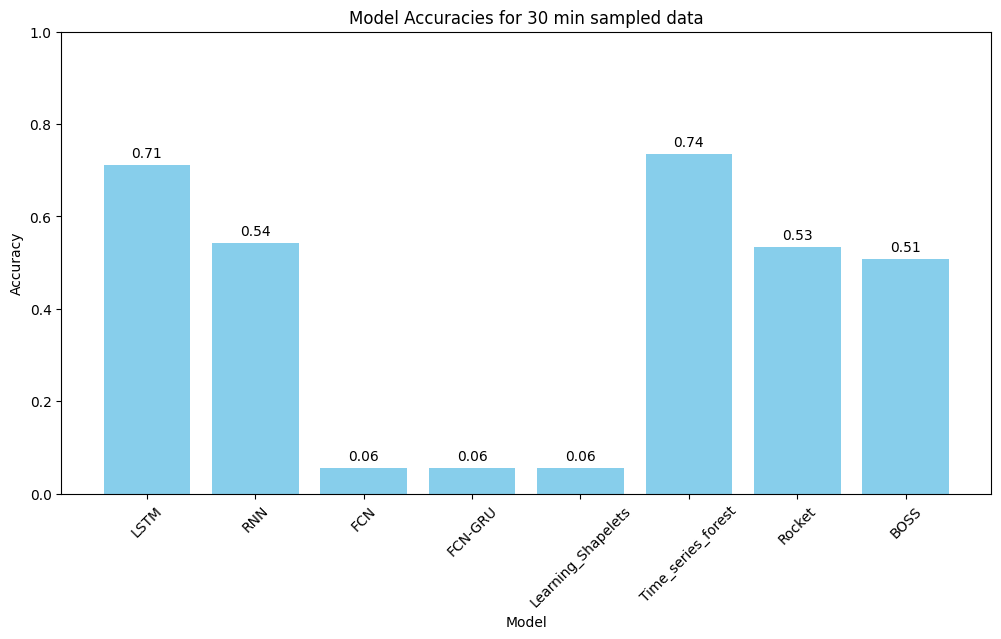

In [ ]:
accuracies = [accuracy_lstm_wm_30m, accuracy_rnn_wm_30m, accuracy_fcn_wm_30m, accuracy_gru_fcn_wm_30m, accuracy_ls_wm_30m, accuracy_tsf_wm_30m, accuracy_rocket_wm_30m, accuracy_boss_wm_30m]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies for 30 min sampled data')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

Television Site

In [10]:
television_site_df = sorted_merged_df

In [11]:
television_site_df['Television_Site'] = television_site_df['Television_Site'].apply(lambda x: 1 if x != 0 else 0)

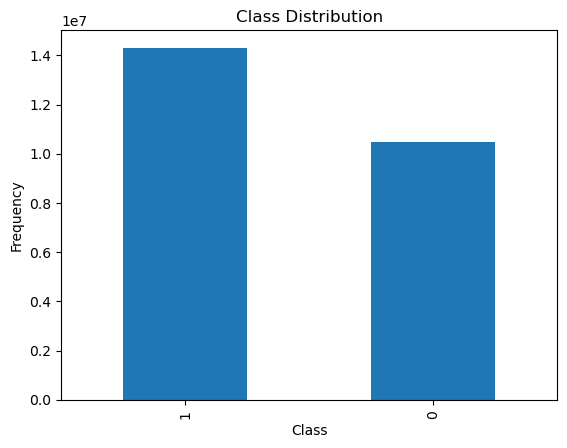

Imbalance Ratio: 1.37
Class distribution is relatively balanced. No need for sampling techniques.


In [12]:
# Check class distribution
class_distribution = television_site_df['Television_Site'].value_counts()

# Visualize class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Determine if sampling is needed
majority_class = class_distribution.idxmax()
minority_class = class_distribution.idxmin()
ts_imbalance_ratio = class_distribution[majority_class] / class_distribution[minority_class]
print(f'Imbalance Ratio: {ts_imbalance_ratio:.2f}')

# Generally, if the imbalance ratio is greater than 1.5 or 2, consider sampling techniques
if ts_imbalance_ratio > 2:
    print("Consider using oversampling or undersampling techniques.")
else:
    print("Class distribution is relatively balanced. No need for sampling techniques.")


In [ ]:
# Separate features and target
X = television_site_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y = television_site_df['Television_Site']

total_rows = X.shape[0]  # total rows

# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)

# Create the training set (first 80%)
X_train = X[:rows_80_percent]
y_train = y[:rows_80_percent]

# Create the test set (last 20%)
X_test = X[-rows_20_percent:]
y_test = y[-rows_20_percent:]


In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the resampled training features
X_train_normalized = scaler.fit_transform(X_train)
# Transform the testing features
X_test_normalized = scaler.transform(X_test)

# Convert back to DataFrame for convenience
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X.columns)

In [ ]:
# Define the sequence length
sequence_length = 10

# Function to create sequences
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# Prepare the sequences for training data
X_train_sequences, y_train_sequences = create_sequences(X_train_normalized_df.values, y_train.values, sequence_length)
# Prepare the sequences for testing data
X_test_sequences, y_test_sequences = create_sequences(X_test_normalized_df.values, y_test.values, sequence_length)

In [ ]:
# Flatten the 3D array while preserving the order
X_train_sequences_2d = X_train_sequences.reshape(-1, X_train_sequences.shape[1])
X_test_sequences_2d = X_test_sequences.reshape(-1, X_test_sequences.shape[1])

In [ ]:
ts_df = sampled_df
ts_df['Television_Site'] = ts_df['Television_Site'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_ts = ts_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_ts = ts_df['Television_Site']
total_rows = X_ts.shape[0]  # total rows
# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)
# Create the training set (first 80%)
X_ts_train = X_ts[:rows_80_percent]
y_ts_train = y_ts[:rows_80_percent]
# Create the validation set (next 20%)
X_ts_val = X_ts[-rows_20_percent:]
y_ts_val = y_ts[-rows_20_percent:]
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_ts_train_resampled_normalized = scaler.fit_transform(X_ts_train)
X_ts_val_normalized = scaler.fit_transform(X_ts_val)
# Convert back to DataFrame for convenience
X_ts_train_resampled_normalized_df = pd.DataFrame(X_ts_train_resampled_normalized, columns=X.columns)
X_ts_val_normalized_df = pd.DataFrame(X_ts_val_normalized, columns=X.columns)
# Prepare the sequences for training data
X_ts_train_sequences, y_ts_train_sequences = create_sequences(X_ts_train_resampled_normalized_df.values, y_ts_train.values, sequence_length)
X_ts_val_sequences, y_ts_val_sequences = create_sequences(X_ts_val_normalized_df.values, y_ts_val.values, sequence_length)
# Flatten the 3D array while preserving the order
X_ts_train_sequences_2d = X_ts_train_sequences.reshape(-1, X_ts_train_sequences.shape[1])
X_ts_val_sequences_2d = X_ts_val_sequences.reshape(-1, X_ts_val_sequences.shape[1])

In [ ]:
# Downsample the data to 30-second intervals and take the first appearing value
downsampled_ts_30m_df = sorted_merged_df.resample('30T').first()
# Drop rows with NaN values resulting from downsampling
downsampled_ts_30m_df.dropna(inplace=True)
ts_30m_df = downsampled_ts_30m_df.sort_values(by='Unix', ascending=True)
ts_30m_df['Television_Site'] = ts_30m_df['Television_Site'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_ts_30m = ts_30m_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_ts_30m = ts_30m_df['Television_Site']
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_ts_30m_normalized = scaler.fit_transform(X_ts_30m)
# Convert back to DataFrame for convenience
X_ts_30m_normalized_df = pd.DataFrame(X_ts_30m_normalized, columns=X_ts_30m.columns)
# Prepare the sequences for training data
X_ts_30m_sequences, y_ts_30m_sequences = create_sequences(X_ts_30m_normalized_df.values, y_ts_30m.values, sequence_length)
# Flatten the 3D array while preserving the order
X_ts_30m_sequences_2d = X_ts_30m_sequences.reshape(-1, X_ts_30m_sequences.shape[1])

LSTM

In [ ]:
def create_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
      for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
          # Create and compile the model
          model = create_model(units, dropout_rate)

          # Train the model
          model.fit(X_ts_train_sequences, y_ts_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)
          print("Model training successful")
          # Evaluate the model on the validation set
          val_loss = model.evaluate(X_ts_val_sequences, y_ts_val_sequences, verbose=0)
          val_loss = val_loss[0] if isinstance(val_loss, list) else val_loss
          # Check if this is the best score so far
          if val_loss < best_score:
            best_score = val_loss
            best_params = {
                'units': units,
                'dropout_rate': dropout_rate,
                'batch_size': batch_size,
                'epochs': epochs
            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'units': 100, 'dropout_rate': 0.4, 'batch_size': 16, 'epochs': 30}
Best validation loss: 0.1815427988767624


In [ ]:
# Train the best model on the full training data and evaluate on the test set
lstm_model_ts = create_model(best_params['units'], best_params['dropout_rate'])
lstm_model_ts.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
lstm_model_ts.save('/content/drive/MyDrive/Saved_Models/lstm_model_ts_5a7h.h5')

In [ ]:
lstm_model_ts = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_ts_5a7h.h5') #load the model
y_pred = lstm_model_ts.predict(X_test_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_ts = accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_ts:.2f}')
# Print classification report
print(classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_test_sequences, y_pred_binary))

1080/1080 [==============================] - 3s 3ms/step
Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.42      0.08      0.14     14264
           1       0.59      0.92      0.72     20277

    accuracy                           0.57     34541
   macro avg       0.50      0.50      0.43     34541
weighted avg       0.52      0.57      0.48     34541

[[ 1165 13099]
 [ 1612 18665]]


In [ ]:
lstm_model_ts_30m = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_ts_5a7h.h5') #load the model
y_pred = lstm_model_ts_30m.predict(X_ts_30m_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_ts_30m = accuracy_score(y_ts_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_ts_30m:.2f}')
# Print classification report
print(classification_report(y_ts_30m_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_ts_30m_sequences, y_pred_binary))

918/918 [==============================] - 3s 3ms/step
Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.59      0.16      0.25     12468
           1       0.60      0.92      0.72     16883

    accuracy                           0.60     29351
   macro avg       0.59      0.54      0.49     29351
weighted avg       0.59      0.60      0.52     29351

[[ 2008 10460]
 [ 1403 15480]]


RNN

In [ ]:
def create_rnn_model(units, dropout_rate, optimizer, activation):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30],
    'activation': ['tanh', 'relu']
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for optimizer in param_grid['optimizer']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    for activation in param_grid['activation']:
                        # Create and compile the model
                        model = create_rnn_model(units, dropout_rate, optimizer, activation)

                        # Train the model
                        model.fit(X_ts_train_sequences, y_ts_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                        # Evaluate the model on the validation set
                        val_loss = model.evaluate(X_ts_val_sequences, y_ts_val_sequences, verbose=0)

                        # Extract the loss value if necessary
                        if isinstance(val_loss, list):
                            val_loss = val_loss[0]

                        # Check if this is the best score so far
                        if val_loss < best_score:
                            best_score = val_loss
                            best_params = {
                                'units': units,
                                'dropout_rate': dropout_rate,
                                'optimizer': optimizer,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'activation': activation
                            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Best parameters: {'units': 150, 'dropout_rate': 0.4, 'optimizer': 'rmsprop', 'batch_size': 32, 'epochs': 30, 'activation': 'relu'}
Best validation loss: 0.1557767689228058


In [ ]:
# Train the best model on the full training data and evaluate on the test set
rnn_model_ts = create_rnn_model(best_params['units'], best_params['dropout_rate'], best_params['optimizer'], best_params['activation'])
rnn_model_ts.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
rnn_model_ts.save('/content/drive/MyDrive/Saved_Models/rnn_model_ts_5a7h.h5')

In [ ]:
rnn_model_ts = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_ts_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_ts.predict(X_test_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_ts = accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_ts:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred_binary))

1080/1080 [==============================] - 2s 2ms/step
Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.10      0.16     14264
           1       0.59      0.91      0.72     20277

    accuracy                           0.58     34541
   macro avg       0.52      0.51      0.44     34541
weighted avg       0.53      0.58      0.49     34541

Confusion Matrix:
 [[ 1376 12888]
 [ 1738 18539]]


In [ ]:
rnn_model_ts_30m = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_ts_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_ts_30m.predict(X_ts_30m_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_ts_30m = accuracy_score(y_ts_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_ts_30m:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_ts_30m_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_ts_30m_sequences, y_pred_binary))

918/918 [==============================] - 2s 2ms/step
Accuracy: 0.60
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.25      0.35     12468
           1       0.61      0.87      0.72     16883

    accuracy                           0.60     29351
   macro avg       0.59      0.56      0.53     29351
weighted avg       0.60      0.60      0.56     29351

Confusion Matrix:
 [[ 3127  9341]
 [ 2267 14616]]


FCN

In [ ]:
def create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer):
    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(GlobalAveragePooling1D())

    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'dropout_rate': [0.3, 0.4],  # Note: dropout isn't used in the base architecture, but you might want to test it
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for dropout_rate in param_grid['dropout_rate']:
                for optimizer_name in param_grid['optimizer']:
                    for batch_size in param_grid['batch_size']:
                        for epochs in param_grid['epochs']:
                            # Create optimizer instance
                            if optimizer_name == 'adam':
                                optimizer = Adam()
                            elif optimizer_name == 'rmsprop':
                                optimizer = RMSprop()

                            # Create and compile the model
                            model = create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer)

                            # Train the model
                            model.fit(X_ts_train_sequences, y_ts_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                            # Evaluate the model on the validation set
                            val_loss, _ = model.evaluate(X_ts_val_sequences, y_ts_val_sequences, verbose=0)

                            # Check if this is the best score so far
                            if val_loss < best_score:
                                best_score = val_loss
                                best_params = {
                                    'filters1': filters1,
                                    'filters2': filters2,
                                    'filters3': filters3,
                                    'dropout_rate': dropout_rate,
                                    'optimizer': optimizer_name,
                                    'batch_size': batch_size,
                                    'epochs': epochs
                                }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best validation loss: 0.9417581558227539


In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
fcn_model_ts = create_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['dropout_rate'], best_optimizer)
fcn_model_ts.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
fcn_model_ts.save('/content/drive/MyDrive/Saved_Models/fcn_model_ts_5a7h.h5')

In [ ]:
fcn_model_ts = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_ts_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_ts.predict(X_test_sequences) > 0.5).astype(int)
accuracy_fcn_ts = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_ts:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

1080/1080 [==============================] - 3s 3ms/step
Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     14264
           1       0.59      1.00      0.74     20277

    accuracy                           0.59     34541
   macro avg       0.29      0.50      0.37     34541
weighted avg       0.34      0.59      0.43     34541

Confusion Matrix:
 [[    0 14264]
 [    0 20277]]


In [ ]:
fcn_model_ts_30m = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_ts_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_ts_30m.predict(X_ts_30m_sequences) > 0.5).astype(int)
accuracy_fcn_ts_30m = accuracy_score(y_ts_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_ts_30m:.2f}')
print("Classification Report:\n", classification_report(y_ts_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_ts_30m_sequences, y_pred))

918/918 [==============================] - 3s 3ms/step
Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     12468
           1       0.58      1.00      0.73     16883

    accuracy                           0.58     29351
   macro avg       0.29      0.50      0.37     29351
weighted avg       0.33      0.58      0.42     29351

Confusion Matrix:
 [[    0 12468]
 [    0 16883]]


GRU-FCN

In [ ]:
input_shape = (X_train_sequences.shape[1], X_train_sequences.shape[2])

def create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Permute layer
    permute_layer = Permute((2, 1))(input_layer)

    # FCN branch
    conv1 = Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1)(permute_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    # GRU branch
    gru = GRU(units=gru_units)(input_layer)
    gru = Dropout(dropout_rate)(gru)

    # Concatenate branches
    concat = Concatenate()([gap, gru])

    # Output layer
    output_layer = Dense(1, activation='softmax')(concat)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'gru_units': [8, 10],
    'dropout_rate': [0.3, 0.8],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for gru_units in param_grid['gru_units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for optimizer_name in param_grid['optimizer']:
                        for batch_size in param_grid['batch_size']:
                            for epochs in param_grid['epochs']:
                                # Create optimizer instance
                                if optimizer_name == 'adam':
                                    optimizer = Adam()
                                elif optimizer_name == 'rmsprop':
                                    optimizer = RMSprop()

                                # Create and compile the model
                                model = create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape)

                                # Train the model
                                model.fit(X_ts_train_sequences, y_ts_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                                # Evaluate the model on the validation set
                                val_loss, _ = model.evaluate(X_ts_val_sequences, y_ts_val_sequences, verbose=0)

                                # Check if this is the best score so far
                                if val_loss < best_score:
                                    best_score = val_loss
                                    best_params = {
                                        'filters1': filters1,
                                        'filters2': filters2,
                                        'filters3': filters3,
                                        'gru_units': gru_units,
                                        'dropout_rate': dropout_rate,
                                        'optimizer': optimizer_name,
                                        'batch_size': batch_size,
                                        'epochs': epochs
                                    }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")


Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'gru_units': 8, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best validation loss: 0.39938288927078247


In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
gru_fcn_model_ts = create_gru_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['gru_units'], best_params['dropout_rate'], best_optimizer, input_shape)
gru_fcn_model_ts.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
gru_fcn_model_ts.save('/content/drive/MyDrive/Saved_Models/gru_fcn_model_ts_5a7h.h5')

In [ ]:
gru_fcn_model_ts = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_ts_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_ts.predict(X_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_ts = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_ts:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

1080/1080 [==============================] - 3s 2ms/step
Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     14264
           1       0.59      1.00      0.74     20277

    accuracy                           0.59     34541
   macro avg       0.29      0.50      0.37     34541
weighted avg       0.34      0.59      0.43     34541

Confusion Matrix:
 [[    0 14264]
 [    0 20277]]


In [ ]:
gru_fcn_model_ts_30m = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_ts_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_ts_30m.predict(X_ts_30m_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_ts_30m = accuracy_score(y_ts_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_ts_30m:.2f}')
print("Classification Report:\n", classification_report(y_ts_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_ts_30m_sequences, y_pred))

918/918 [==============================] - 2s 2ms/step
Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     12468
           1       0.58      1.00      0.73     16883

    accuracy                           0.58     29351
   macro avg       0.29      0.50      0.37     29351
weighted avg       0.33      0.58      0.42     29351

Confusion Matrix:
 [[    0 12468]
 [    0 16883]]


Learning Shapelet

In [ ]:
param_grid = {
    'n_shapelets_per_size': [0.2, 0.3],  # Fraction of the number of timestamps
    'min_shapelet_length': [0.1, 0.2],  # Fraction of the number of timestamps
    'shapelet_scale': [2, 4],              # Different scales for the lengths of the shapelets
    'penalty': ['l2', 'l1'],                  # Norm used in the penalization
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    shapelet_clf = LearningShapelets(
        n_shapelets_per_size=params['n_shapelets_per_size'],
        min_shapelet_length=params['min_shapelet_length'],
        shapelet_scale=params['shapelet_scale'],
        penalty=params['penalty']
    )

    # Train the model on the training data
    shapelet_clf.fit(X_ts_train_sequences_2d, y_ts_train_sequences)
    print("Model training successful")
    # Predict on the validation set
    y_val_pred = shapelet_clf.predict(X_ts_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_ts_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'n_shapelets_per_size': 0.2, 'min_shapelet_length': 0.1, 'shapelet_scale': 2, 'penalty': 'l2'}
Validation accuracy with best parameters: 0.6018261673601479


In [ ]:
learning_shapelets_ts = LearningShapelets(
        n_shapelets_per_size=best_params['n_shapelets_per_size'],
        min_shapelet_length=best_params['min_shapelet_length'],
        shapelet_scale=best_params['shapelet_scale'],
        penalty=best_params['penalty']
    )
learning_shapelets_ts.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_ts_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(learning_shapelets_ts, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_ts_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_ts = pickle.load(file)

y_pred = learning_shapelets_ts.predict(X_test_sequences_2d)
accuracy_ls_ts = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_ts:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.42      1.00      0.59      3616
           1       0.00      0.00      0.00      5036

    accuracy                           0.42      8652
   macro avg       0.21      0.50      0.29      8652
weighted avg       0.17      0.42      0.25      8652

Confusion Matrix:
 [[3616    0]
 [5036    0]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_ts_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_ts_30m = pickle.load(file)

y_pred = learning_shapelets_ts_30m.predict(X_ts_30m_sequences_2d)
accuracy_ls_ts_30m = accuracy_score(y_ts_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_ts_30m:.2f}')
print("Classification Report:\n", classification_report(y_ts_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_ts_30m_sequences, y_pred))

Accuracy: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.42      1.00      0.60     12468
           1       0.00      0.00      0.00     16883

    accuracy                           0.42     29351
   macro avg       0.21      0.50      0.30     29351
weighted avg       0.18      0.42      0.25     29351

Confusion Matrix:
 [[12468     0]
 [16883     0]]


Time Series Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'min_interval': [3, 5],
    'n_jobs': [-1]
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    tsf_clf = TimeSeriesForestClassifier(
        n_estimators=params['n_estimators'],
        min_interval=params['min_interval'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    tsf_clf.fit(X_ts_train_sequences_2d, y_ts_train_sequences)

    # Predict on the validation set
    y_val_pred = tsf_clf.predict(X_ts_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_ts_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'n_estimators': 200, 'min_interval': 3, 'n_jobs': -1}
Validation accuracy with best parameters: 0.6477154424522845


In [ ]:
tsf_ts = TimeSeriesForestClassifier(
        n_estimators=best_params['n_estimators'],
        min_interval=best_params['min_interval'],
        n_jobs=best_params['n_jobs']
    )

tsf_ts.fit(X_train_sequences_2d, y_train_sequences)
# Predict on the test set
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_ts_5a7h"
mlflow_sktime.save_model(
    sktime_model=tsf_ts,
    path=model_path)

In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_ts_5a7h"
# Load the model from the specified file path
tsf_ts = mlflow_sktime.load_model(model_uri=model_path)
y_pred = tsf_ts.predict(X_test_sequences_2d)
accuracy_tsf_ts = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_ts:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.10      0.17     14264
           1       0.59      0.91      0.72     20277

    accuracy                           0.58     34541
   macro avg       0.52      0.51      0.44     34541
weighted avg       0.53      0.58      0.49     34541

Confusion Matrix:
 [[ 1452 12812]
 [ 1774 18503]]


In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_ts_5a7h"
# Load the model from the specified file path
tsf_ts_30m = mlflow_sktime.load_model(model_uri=model_path)
y_pred = tsf_ts_30m.predict(X_ts_30m_sequences_2d)
accuracy_tsf_ts_30m = accuracy_score(y_ts_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_ts_30m:.2f}')
print("Classification Report:\n", classification_report(y_ts_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_ts_30m_sequences, y_pred))

Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.19      0.28     12468
           1       0.59      0.88      0.71     16883

    accuracy                           0.59     29351
   macro avg       0.57      0.53      0.49     29351
weighted avg       0.57      0.59      0.53     29351

Confusion Matrix:
 [[ 2348 10120]
 [ 2019 14864]]


Rocket

In [ ]:
param_grid = {
    'num_kernels': [10000,15000],  # Number of kernels for the Rocket transform
    'rocket_transform': ['rocket'],
#    'rocket_transform': ['rocket', 'minirocket', 'multirocket'],  # Type of Rocket transformer to use
    'max_dilations_per_kernel': [32,64],  # Max number of dilations per kernel (MiniRocket and MultiRocket only)
    'n_features_per_kernel': [4,8],  # Number of features per kernel (MultiRocket only)
    'use_multivariate': ['no'],  # Whether to use multivariate Rocket transforms or univariate ones
    'n_jobs': [-1]  # Number of jobs to run in parallel for both fit and predict
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    rocket_clf = RocketClassifier(
        num_kernels=params['num_kernels'],
        rocket_transform=params['rocket_transform'],
        max_dilations_per_kernel=params['max_dilations_per_kernel'],  # Default to 32 if not provided
        n_features_per_kernel=params['n_features_per_kernel'],  # Default to 4 if not provided
        use_multivariate=params['use_multivariate'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    rocket_clf.fit(X_ts_train_sequences_2d, y_ts_train_sequences)
    print("Model training successful")
    # Predict on the validation set
    y_val_pred = rocket_clf.predict(X_ts_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_ts_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'num_kernels': 10000, 'rocket_transform': 'rocket', 'max_dilations_per_kernel': 64, 'n_features_per_kernel': 4, 'use_multivariate': 'no', 'n_jobs': -1}
Validation accuracy with best parameters: 0.5265683921837504


In [ ]:
rocket_ts = RocketClassifier(
        num_kernels=best_params['num_kernels'],
        rocket_transform=best_params['rocket_transform'],
        max_dilations_per_kernel=best_params['max_dilations_per_kernel'],
        n_features_per_kernel=best_params['n_features_per_kernel'],
        use_multivariate=best_params['use_multivariate'],
        n_jobs=best_params['n_jobs']
    )

rocket_ts.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_ts_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(rocket_ts, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_ts_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    rocket_ts = pickle.load(file)
# Predict on the test set
y_pred = rocket_ts.predict(X_test_sequences_2d)
accuracy_rocket_ts = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_ts:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.52
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.41      0.42      3616
           1       0.59      0.61      0.60      5036

    accuracy                           0.52      8652
   macro avg       0.51      0.51      0.51      8652
weighted avg       0.52      0.52      0.52      8652

Confusion Matrix:
 [[1467 2149]
 [1979 3057]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_ts_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    rocket_ts_30m = pickle.load(file)
# Predict on the test set
y_pred = rocket_ts_30m.predict(X_ts_30m_sequences_2d)
accuracy_rocket_ts_30m = accuracy_score(y_ts_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_ts_30m:.2f}')
print("Classification Report:\n", classification_report(y_ts_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_ts_30m_sequences, y_pred))

Accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.44      0.44     12468
           1       0.59      0.59      0.59     16883

    accuracy                           0.53     29351
   macro avg       0.51      0.51      0.51     29351
weighted avg       0.53      0.53      0.53     29351

Confusion Matrix:
 [[5530 6938]
 [6984 9899]]


BOSS

In [ ]:
param_grid = {
    'alphabet_size': [2, 4],  # Number of possible letters (values) for each word
    'n_jobs': [-1],  # Number of jobs to run in parallel for both fit and predict
    'feature_selection': ['chi2', 'none', 'random']  # Sets the feature selections strategy to be used
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    boss_clf = BOSSEnsemble(
        alphabet_size=params['alphabet_size'],
        n_jobs=params['n_jobs'],
        feature_selection=params['feature_selection']
    )

    # Train the model on the training data
    boss_clf.fit(X_ts_train_sequences_2d, y_ts_train_sequences)
    print("Model training successful")
    # Predict on the validation set
    y_val_pred = boss_clf.predict(X_ts_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_ts_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'alphabet_size': 4, 'n_jobs': -1, 'feature_selection': 'none'}
Validation accuracy with best parameters: 0.45030050855293574


In [ ]:
boss_ts = BOSSEnsemble(
        alphabet_size=best_params['alphabet_size'],
        n_jobs=best_params['n_jobs'],
        feature_selection=best_params['feature_selection']
    )

boss_ts.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_ts_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(boss_ts, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_ts_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_ts = pickle.load(file)
# Predict on the test set
y_pred = boss_ts.predict(X_test_sequences_2d)
accuracy_boss_ts = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_ts:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.47
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.73      0.54      3616
           1       0.60      0.29      0.39      5036

    accuracy                           0.47      8652
   macro avg       0.51      0.51      0.46      8652
weighted avg       0.52      0.47      0.45      8652

Confusion Matrix:
 [[2623  993]
 [3563 1473]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_ts_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_ts_30m = pickle.load(file)
# Predict on the test set
y_pred = boss_ts_30m.predict(X_ts_30m_sequences_2d)
accuracy_boss_ts_30m = accuracy_score(y_ts_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_ts_30m:.2f}')
print("Classification Report:\n", classification_report(y_ts_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_ts_30m_sequences, y_pred))

Accuracy: 0.47
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.74      0.54     12468
           1       0.59      0.28      0.38     16883

    accuracy                           0.47     29351
   macro avg       0.51      0.51      0.46     29351
weighted avg       0.52      0.47      0.45     29351

Confusion Matrix:
 [[ 9174  3294]
 [12187  4696]]


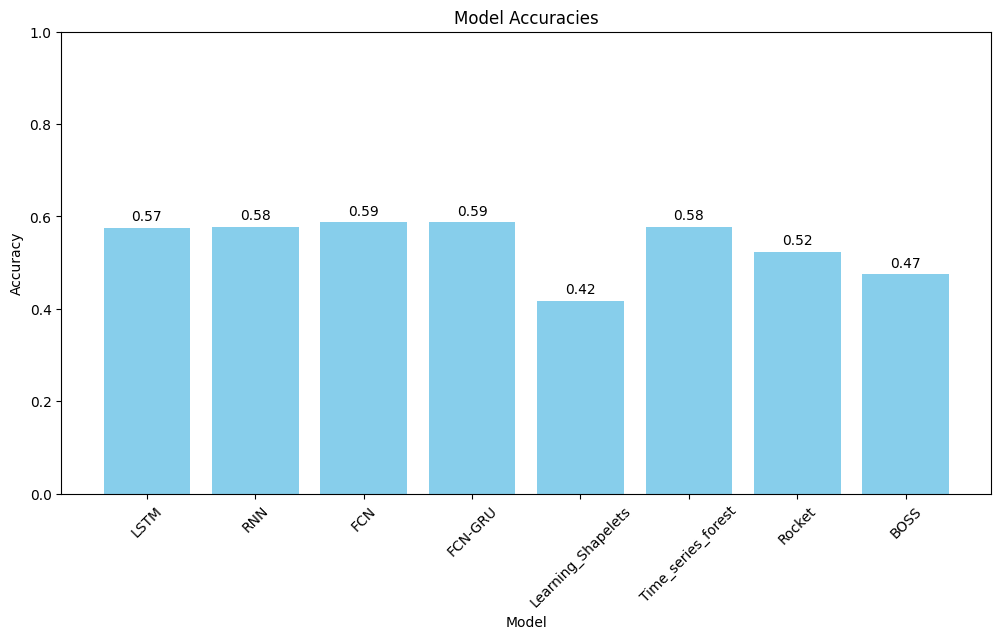

In [ ]:
accuracies = [accuracy_lstm_ts, accuracy_rnn_ts, accuracy_fcn_ts, accuracy_gru_fcn_ts, accuracy_ls_ts, accuracy_tsf_ts, accuracy_rocket_ts, accuracy_boss_ts]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

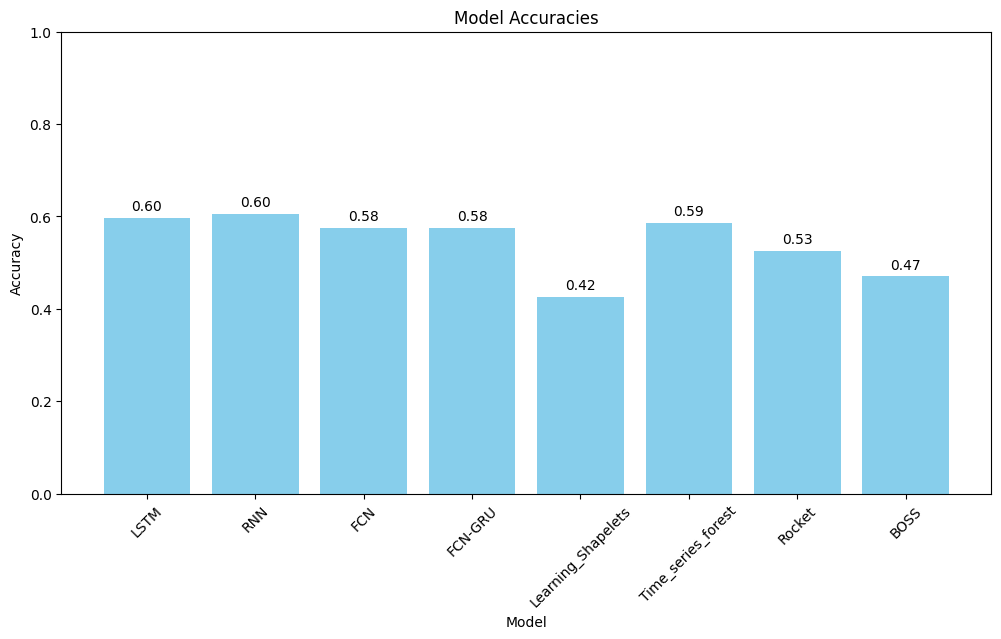

In [ ]:
accuracies = [accuracy_lstm_ts_30m, accuracy_rnn_ts_30m, accuracy_fcn_ts_30m, accuracy_gru_fcn_ts_30m, accuracy_ls_ts_30m, accuracy_tsf_ts_30m, accuracy_rocket_ts_30m, accuracy_boss_ts_30m]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

Microwave

In [13]:
microwave_df = sorted_merged_df
microwave_df['Microwave'] = microwave_df['Microwave'].apply(lambda x: 1 if x != 0 else 0)

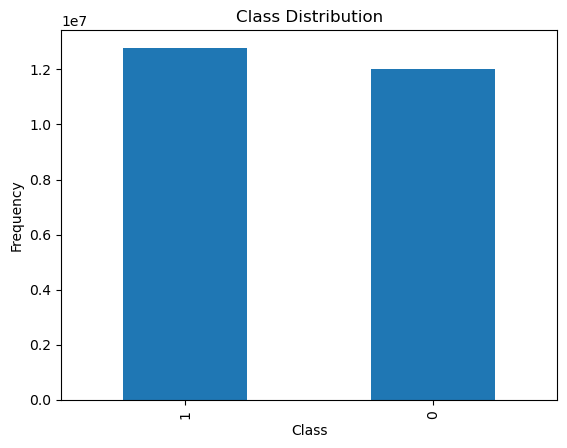

Imbalance Ratio: 1.07
Class distribution is relatively balanced. No need for sampling techniques.


In [14]:
# Check class distribution
class_distribution = microwave_df['Microwave'].value_counts()

# Visualize class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Determine if sampling is needed
majority_class = class_distribution.idxmax()
minority_class = class_distribution.idxmin()
mv_imbalance_ratio = class_distribution[majority_class] / class_distribution[minority_class]
print(f'Imbalance Ratio: {mv_imbalance_ratio:.2f}')

# Generally, if the imbalance ratio is greater than 1.5 or 2, consider sampling techniques
if mv_imbalance_ratio > 2:
    print("Consider using oversampling or undersampling techniques.")
else:
    print("Class distribution is relatively balanced. No need for sampling techniques.")


In [ ]:
# Separate features and target
X = microwave_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y = microwave_df['Microwave']

total_rows = X.shape[0]  # total rows

# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)

# Create the training set (first 80%)
X_train = X[:rows_80_percent]
y_train = y[:rows_80_percent]

# Create the test set (last 20%)
X_test = X[-rows_20_percent:]
y_test = y[-rows_20_percent:]


In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the resampled training features
X_train_resampled_normalized = scaler.fit_transform(X_train)
# Transform the testing features
X_test_normalized = scaler.transform(X_test)

# Convert back to DataFrame for convenience
X_train_resampled_normalized_df = pd.DataFrame(X_train_resampled_normalized, columns=X.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X.columns)

In [ ]:
# Define the sequence length
sequence_length = 10

# Function to create sequences
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# Prepare the sequences for training data
X_train_sequences, y_train_sequences = create_sequences(X_train_resampled_normalized_df.values, y_train.values, sequence_length)

# Prepare the sequences for testing data
X_test_sequences, y_test_sequences = create_sequences(X_test_normalized_df.values, y_test.values, sequence_length)

In [ ]:
# Flatten the 3D array while preserving the order
X_train_sequences_2d = X_train_sequences.reshape(-1, X_train_sequences.shape[1])
X_test_sequences_2d = X_test_sequences.reshape(-1, X_test_sequences.shape[1])

In [ ]:
mv_df = sampled_df
mv_df['Microwave'] = mv_df['Microwave'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_mv = mv_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_mv = mv_df['Microwave']
total_rows = X_mv.shape[0]  # total rows
# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)
# Create the training set (first 80%)
X_mv_train = X_mv[:rows_80_percent]
y_mv_train = y_mv[:rows_80_percent]
# Create the validation set (next 20%)
X_mv_val = X_mv[-rows_20_percent:]
y_mv_val = y_mv[-rows_20_percent:]
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_mv_train_resampled_normalized = scaler.fit_transform(X_mv_train)
X_mv_val_normalized = scaler.fit_transform(X_mv_val)
# Convert back to DataFrame for convenience
X_mv_train_resampled_normalized_df = pd.DataFrame(X_mv_train_resampled_normalized, columns=X.columns)
X_mv_val_normalized_df = pd.DataFrame(X_mv_val_normalized, columns=X.columns)
# Prepare the sequences for training data
X_mv_train_sequences, y_mv_train_sequences = create_sequences(X_mv_train_resampled_normalized_df.values, y_mv_train_resampled.values, sequence_length)
X_mv_val_sequences, y_mv_val_sequences = create_sequences(X_mv_val_normalized_df.values, y_mv_val.values, sequence_length)
# Flatten the 3D array while preserving the order
X_mv_train_sequences_2d = X_mv_train_sequences.reshape(-1, X_mv_train_sequences.shape[1])
X_mv_val_sequences_2d = X_mv_val_sequences.reshape(-1, X_mv_val_sequences.shape[1])

In [ ]:
# Downsample the data to 30-second intervals and take the first appearing value
downsampled_mv_30m_df = sorted_merged_df.resample('30T').first()
# Drop rows with NaN values resulting from downsampling
downsampled_mv_30m_df.dropna(inplace=True)
mv_30m_df = downsampled_mv_30m_df.sort_values(by='Unix', ascending=True)
mv_30m_df['Microwave'] = mv_30m_df['Microwave'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_mv_30m = mv_30m_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_mv_30m = mv_30m_df['Microwave']
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_mv_30m_normalized = scaler.fit_transform(X_mv_30m)
# Convert back to DataFrame for convenience
X_mv_30m_normalized_df = pd.DataFrame(X_mv_30m_normalized, columns=X_mv_30m.columns)
# Prepare the sequences for training data
X_mv_30m_sequences, y_mv_30m_sequences = create_sequences(X_mv_30m_normalized_df.values, y_mv_30m.values, sequence_length)
# Flatten the 3D array while preserving the order
X_mv_30m_sequences_2d = X_mv_30m_sequences.reshape(-1, X_mv_30m_sequences.shape[1])

LSTM

In [ ]:
def create_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
      for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
          # Create and compile the model
          model = create_model(units, dropout_rate)

          # Train the model
          model.fit(X_mv_train_sequences, y_mv_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)
          print("Model training successful")
          # Evaluate the model on the validation set
          val_loss = model.evaluate(X_mv_val_sequences, y_mv_val_sequences, verbose=0)
          val_loss = val_loss[0] if isinstance(val_loss, list) else val_loss
          # Check if this is the best score so far
          if val_loss < best_score:
            best_score = val_loss
            best_params = {
                'units': units,
                'dropout_rate': dropout_rate,
                'batch_size': batch_size,
                'epochs': epochs
            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'units': 150, 'dropout_rate': 0.3, 'batch_size': 32, 'epochs': 30}
Best validation loss: 0.3902845084667206


In [ ]:
# Train the best model on the full training data and evaluate on the test set
lstm_model_mv = create_model(best_params['units'], best_params['dropout_rate'])
lstm_model_mv.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
lstm_model_mv.save('/content/drive/MyDrive/Saved_Models/lstm_model_mv_5a7h.h5')

In [ ]:
lstm_model_mv = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_mv_5a7h.h5') #load the model
y_pred = lstm_model_mv.predict(X_test_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_mv = accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_mv:.2f}')
# Print classification report
print(classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_test_sequences, y_pred_binary))

1080/1080 [==============================] - 5s 4ms/step
Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.46      0.51      0.48     15582
           1       0.56      0.51      0.53     18959

    accuracy                           0.51     34541
   macro avg       0.51      0.51      0.51     34541
weighted avg       0.51      0.51      0.51     34541

[[7942 7640]
 [9358 9601]]


In [ ]:
lstm_model_mv_30m = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_mv_5a7h.h5') #load the model
y_pred = lstm_model_mv_30m.predict(X_mv_30m_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_mv_30m = accuracy_score(y_mv_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_mv_30m:.2f}')
# Print classification report
print(classification_report(y_mv_30m_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_mv_30m_sequences, y_pred_binary))

918/918 [==============================] - 4s 4ms/step
Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.57      0.36      0.44     14620
           1       0.53      0.72      0.62     14731

    accuracy                           0.54     29351
   macro avg       0.55      0.54      0.53     29351
weighted avg       0.55      0.54      0.53     29351

[[ 5322  9298]
 [ 4061 10670]]


RNN

In [ ]:
def create_rnn_model(units, dropout_rate, optimizer, activation):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30],
    'activation': ['tanh', 'relu']
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for optimizer in param_grid['optimizer']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    for activation in param_grid['activation']:
                        # Create and compile the model
                        model = create_rnn_model(units, dropout_rate, optimizer, activation)

                        # Train the model
                        model.fit(X_mv_train_sequences, y_mv_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)
                        print("Model training successful")
                        # Evaluate the model on the validation set
                        val_loss = model.evaluate(X_mv_val_sequences, y_mv_val_sequences, verbose=0)

                        # Extract the loss value if necessary
                        if isinstance(val_loss, list):
                            val_loss = val_loss[0]

                        # Check if this is the best score so far
                        if val_loss < best_score:
                            best_score = val_loss
                            best_params = {
                                'units': units,
                                'dropout_rate': dropout_rate,
                                'optimizer': optimizer,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'activation': activation
                            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model traini

In [ ]:
# Train the best model on the full training data and evaluate on the test set
rnn_model_mv = create_rnn_model(best_params['units'], best_params['dropout_rate'], best_params['optimizer'], best_params['activation'])
rnn_model_mv.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
rnn_model_mv.save('/content/drive/MyDrive/Saved_Models/rnn_model_mv_5a7h.h5')

In [ ]:
rnn_model_mv = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_mv_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_mv.predict(X_test_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_mv = accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_mv:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred_binary))

1080/1080 [==============================] - 2s 2ms/step
Accuracy: 0.47
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.82      0.58     15582
           1       0.56      0.19      0.29     18959

    accuracy                           0.47     34541
   macro avg       0.51      0.50      0.44     34541
weighted avg       0.51      0.47      0.42     34541

Confusion Matrix:
 [[12744  2838]
 [15317  3642]]


In [ ]:
rnn_model_mv_30m = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_mv_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_mv_30m.predict(X_mv_30m_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_mv_30m = accuracy_score(y_mv_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_mv_30m:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_mv_30m_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_mv_30m_sequences, y_pred_binary))

918/918 [==============================] - 2s 2ms/step
Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.61     14620
           1       0.50      0.20      0.28     14731

    accuracy                           0.50     29351
   macro avg       0.50      0.50      0.45     29351
weighted avg       0.50      0.50      0.45     29351

Confusion Matrix:
 [[11714  2906]
 [11801  2930]]


FCN

In [ ]:
def create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer):
    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(GlobalAveragePooling1D())

    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'dropout_rate': [0.3, 0.4],  # Note: dropout isn't used in the base architecture, but you might want to test it
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for dropout_rate in param_grid['dropout_rate']:
                for optimizer_name in param_grid['optimizer']:
                    for batch_size in param_grid['batch_size']:
                        for epochs in param_grid['epochs']:
                            # Create optimizer instance
                            if optimizer_name == 'adam':
                                optimizer = Adam()
                            elif optimizer_name == 'rmsprop':
                                optimizer = RMSprop()

                            # Create and compile the model
                            model = create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer)

                            # Train the model
                            model.fit(X_mv_train_sequences, y_mv_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)
                            print("Model training successful")
                            # Evaluate the model on the validation set
                            val_loss, _ = model.evaluate(X_mv_val_sequences, y_mv_val_sequences, verbose=0)

                            # Check if this is the best score so far
                            if val_loss < best_score:
                                best_score = val_loss
                                best_params = {
                                    'filters1': filters1,
                                    'filters2': filters2,
                                    'filters3': filters3,
                                    'dropout_rate': dropout_rate,
                                    'optimizer': optimizer_name,
                                    'batch_size': batch_size,
                                    'epochs': epochs
                                }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best validation loss: 0.3350491225719452


In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
fcn_model_mv = create_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['dropout_rate'], best_optimizer)
fcn_model_mv.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
fcn_model_mv.save('/content/drive/MyDrive/Saved_Models/fcn_model_mv_5a7h.h5')

In [ ]:
fcn_model_mv = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_mv_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_mv.predict(X_test_sequences) > 0.5).astype(int)
accuracy_fcn_mv = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_mv:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

1080/1080 [==============================] - 3s 3ms/step
Accuracy: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     15582
           1       0.55      1.00      0.71     18959

    accuracy                           0.55     34541
   macro avg       0.27      0.50      0.35     34541
weighted avg       0.30      0.55      0.39     34541

Confusion Matrix:
 [[    0 15582]
 [    0 18959]]


In [ ]:
fcn_model_mv_30m = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_mv_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_mv_30m.predict(X_mv_30m_sequences) > 0.5).astype(int)
accuracy_fcn_mv_30m = accuracy_score(y_mv_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_mv_30m:.2f}')
print("Classification Report:\n", classification_report(y_mv_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_mv_30m_sequences, y_pred))

918/918 [==============================] - 3s 3ms/step
Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     14620
           1       0.50      1.00      0.67     14731

    accuracy                           0.50     29351
   macro avg       0.25      0.50      0.33     29351
weighted avg       0.25      0.50      0.34     29351

Confusion Matrix:
 [[    0 14620]
 [    0 14731]]


GRU-FCN

In [ ]:
input_shape = (X_train_sequences.shape[1], X_train_sequences.shape[2])

def create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Permute layer
    permute_layer = Permute((2, 1))(input_layer)

    # FCN branch
    conv1 = Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1)(permute_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    # GRU branch
    gru = GRU(units=gru_units)(input_layer)
    gru = Dropout(dropout_rate)(gru)

    # Concatenate branches
    concat = Concatenate()([gap, gru])

    # Output layer
    output_layer = Dense(1, activation='softmax')(concat)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'gru_units': [8, 10],
    'dropout_rate': [0.3, 0.8],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for gru_units in param_grid['gru_units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for optimizer_name in param_grid['optimizer']:
                        for batch_size in param_grid['batch_size']:
                            for epochs in param_grid['epochs']:
                                # Create optimizer instance
                                if optimizer_name == 'adam':
                                    optimizer = Adam()
                                elif optimizer_name == 'rmsprop':
                                    optimizer = RMSprop()

                                # Create and compile the model
                                model = create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape)

                                # Train the model
                                model.fit(X_mv_train_sequences, y_mv_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)
                                print("Model training successful")
                                # Evaluate the model on the validation set
                                val_loss, _ = model.evaluate(X_mv_val_sequences, y_mv_val_sequences, verbose=0)

                                # Check if this is the best score so far
                                if val_loss < best_score:
                                    best_score = val_loss
                                    best_params = {
                                        'filters1': filters1,
                                        'filters2': filters2,
                                        'filters3': filters3,
                                        'gru_units': gru_units,
                                        'dropout_rate': dropout_rate,
                                        'optimizer': optimizer_name,
                                        'batch_size': batch_size,
                                        'epochs': epochs
                                    }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")


Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'gru_units': 8, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best vali

In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
gru_fcn_model_mv = create_gru_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['gru_units'], best_params['dropout_rate'], best_optimizer, input_shape)
gru_fcn_model_mv.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
gru_fcn_model_mv.save('/content/drive/MyDrive/Saved_Models/gru_fcn_model_mv_5a7h.h5')

In [ ]:
gru_fcn_model_mv = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_mv_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_mv.predict(X_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_mv = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_mv:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

1080/1080 [==============================] - 3s 2ms/step
Accuracy: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     15582
           1       0.55      1.00      0.71     18959

    accuracy                           0.55     34541
   macro avg       0.27      0.50      0.35     34541
weighted avg       0.30      0.55      0.39     34541

Confusion Matrix:
 [[    0 15582]
 [    0 18959]]


In [ ]:
gru_fcn_model_mv_30m = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_mv_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_mv_30m.predict(X_mv_30m_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_mv_30m = accuracy_score(y_mv_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_mv_30m:.2f}')
print("Classification Report:\n", classification_report(y_mv_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_mv_30m_sequences, y_pred))

918/918 [==============================] - 2s 2ms/step
Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     14620
           1       0.50      1.00      0.67     14731

    accuracy                           0.50     29351
   macro avg       0.25      0.50      0.33     29351
weighted avg       0.25      0.50      0.34     29351

Confusion Matrix:
 [[    0 14620]
 [    0 14731]]


Learning Shapelet

In [ ]:
param_grid = {
    'n_shapelets_per_size': [0.2, 0.3],  # Fraction of the number of timestamps
    'min_shapelet_length': [0.1, 0.2],  # Fraction of the number of timestamps
    'shapelet_scale': [2, 4],              # Different scales for the lengths of the shapelets
    'penalty': ['l2', 'l1']
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    shapelet_clf = LearningShapelets(
        n_shapelets_per_size=params['n_shapelets_per_size'],
        min_shapelet_length=params['min_shapelet_length'],
        shapelet_scale=params['shapelet_scale'],
        penalty=params['penalty']
    )

    # Train the model on the training data
    shapelet_clf.fit(X_mv_train_sequences_2d, y_mv_train_sequences)

    # Predict on the validation set
    y_val_pred = shapelet_clf.predict(X_mv_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_mv_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'n_shapelets_per_size': 0.2, 'min_shapelet_length': 0.1, 'shapelet_scale': 2, 'penalty': 'l2'}
Validation accuracy with best parameters: 0.5313678436750086


In [ ]:
learning_shapelets_mv = LearningShapelets(
        n_shapelets_per_size=best_params['n_shapelets_per_size'],
        min_shapelet_length=best_params['min_shapelet_length'],
        shapelet_scale=best_params['shapelet_scale'],
        penalty=best_params['penalty']
    )
learning_shapelets_mv.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_mv_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(learning_shapelets_mv, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_mv_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_mv = pickle.load(file)

y_pred = learning_shapelets_mv.predict(X_test_sequences_2d)
accuracy_ls_mv = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_mv:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7908
           1       0.54      1.00      0.70      9382

    accuracy                           0.54     17290
   macro avg       0.27      0.50      0.35     17290
weighted avg       0.29      0.54      0.38     17290

Confusion Matrix:
 [[   0 7908]
 [   0 9382]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_mv_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_mv_30m = pickle.load(file)

y_pred = learning_shapelets_mv_30m.predict(X_mv_30m_sequences_2d)
accuracy_ls_mv_30m = accuracy_score(y_mv_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_mv_30m:.2f}')
print("Classification Report:\n", classification_report(y_mv_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_mv_30m_sequences, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     14620
           1       0.50      1.00      0.67     14731

    accuracy                           0.50     29351
   macro avg       0.25      0.50      0.33     29351
weighted avg       0.25      0.50      0.34     29351

Confusion Matrix:
 [[    0 14620]
 [    0 14731]]


Time Series Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'min_interval': [3, 5],
    'n_jobs': [-1]
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    tsf_clf = TimeSeriesForestClassifier(
        n_estimators=params['n_estimators'],
        min_interval=params['min_interval'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    tsf_clf.fit(X_mv_train_sequences_2d, y_mv_train_sequences)

    # Predict on the validation set
    y_val_pred = tsf_clf.predict(X_mv_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_mv_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

In [ ]:
tsf_mv = TimeSeriesForestClassifier(
        n_estimators=best_params['n_estimators'],
        min_interval=best_params['min_interval'],
        n_jobs=best_params['n_jobs']
    )

tsf_mv.fit(X_train_sequences_2d, y_train_sequences)
# Predict on the test set
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_mv_5a7h"
mlflow_sktime.save_model(
    sktime_model=tsf_mv,
    path=model_path)

In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_mv_5a7h"
# Load the model from the specified file path
tsf_mv = mlflow_sktime.load_model(model_uri=model_path)
y_pred = tsf_mv.predict(X_test_sequences_2d)
accuracy_tsf_mv = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_mv:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.57      0.51     15582
           1       0.55      0.44      0.49     18959

    accuracy                           0.50     34541
   macro avg       0.50      0.50      0.50     34541
weighted avg       0.51      0.50      0.50     34541

Confusion Matrix:
 [[ 8877  6705]
 [10665  8294]]


In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_mv_5a7h"
# Load the model from the specified file path
tsf_mv_30m = mlflow_sktime.load_model(model_uri=model_path)
y_pred = tsf_mv_30m.predict(X_mv_30m_sequences_2d)
accuracy_tsf_mv_30m = accuracy_score(y_mv_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_mv_30m:.2f}')
print("Classification Report:\n", classification_report(y_mv_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_mv_30m_sequences, y_pred))

Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.45      0.49     14620
           1       0.54      0.64      0.58     14731

    accuracy                           0.54     29351
   macro avg       0.54      0.54      0.54     29351
weighted avg       0.54      0.54      0.54     29351

Confusion Matrix:
 [[6535 8085]
 [5337 9394]]


Rocket

In [ ]:
param_grid = {
    'num_kernels': [10000,15000],  # Number of kernels for the Rocket transform
    'rocket_transform': ['rocket'],
#    'rocket_transform': ['rocket', 'minirocket', 'multirocket'],  # Type of Rocket transformer to use
    'max_dilations_per_kernel': [32,64],  # Max number of dilations per kernel (MiniRocket and MultiRocket only)
    'n_features_per_kernel': [4,8],  # Number of features per kernel (MultiRocket only)
    'use_multivariate': ['no'],  # Whether to use multivariate Rocket transforms or univariate ones
    'n_jobs': [-1]  # Number of jobs to run in parallel for both fit and predict
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    rocket_clf = RocketClassifier(
        num_kernels=params['num_kernels'],
        rocket_transform=params['rocket_transform'],
        max_dilations_per_kernel=params['max_dilations_per_kernel'],  # Default to 32 if not provided
        n_features_per_kernel=params['n_features_per_kernel'],  # Default to 4 if not provided
        use_multivariate=params['use_multivariate'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    rocket_clf.fit(X_mv_train_sequences_2d, y_mv_train_sequences)

    # Predict on the validation set
    y_val_pred = rocket_clf.predict(X_mv_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_mv_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'num_kernels': 10000, 'rocket_transform': 'rocket', 'max_dilations_per_kernel': 64, 'n_features_per_kernel': 8, 'use_multivariate': 'no', 'n_jobs': -1}
Validation accuracy with best parameters: 0.506342132327734


In [ ]:
rocket_mv = RocketClassifier(
        num_kernels=best_params['num_kernels'],
        rocket_transform=best_params['rocket_transform'],
        max_dilations_per_kernel=best_params['max_dilations_per_kernel'],
        n_features_per_kernel=best_params['n_features_per_kernel'],
        use_multivariate=best_params['use_multivariate'],
        n_jobs=best_params['n_jobs']
    )

rocket_mv.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_mv_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(rocket_mv, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_mv_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    rocket_mv = pickle.load(file)
# Predict on the test set
y_pred = rocket_mv.predict(X_test_sequences_2d)
accuracy_rocket_mv = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_mv:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.51
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.38      0.41      7908
           1       0.54      0.62      0.58      9382

    accuracy                           0.51     17290
   macro avg       0.50      0.50      0.50     17290
weighted avg       0.50      0.51      0.50     17290

Confusion Matrix:
 [[3013 4895]
 [3610 5772]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_mv_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    rocket_mv_30m = pickle.load(file)
# Predict on the test set
y_pred = rocket_mv_30m.predict(X_mv_30m_sequences_2d)
accuracy_rocket_mv_30m = accuracy_score(y_mv_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_mv_30m:.2f}')
print("Classification Report:\n", classification_report(y_mv_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_mv_30m_sequences, y_pred))

Accuracy: 0.52
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.42      0.47     14620
           1       0.52      0.62      0.57     14731

    accuracy                           0.52     29351
   macro avg       0.52      0.52      0.52     29351
weighted avg       0.52      0.52      0.52     29351

Confusion Matrix:
 [[6186 8434]
 [5565 9166]]


BOSS

In [ ]:
param_grid = {
    'alphabet_size': [2, 4],  # Number of possible letters (values) for each word
    'n_jobs': [-1],  # Number of jobs to run in parallel for both fit and predict
    'feature_selection': ['chi2', 'none', 'random']  # Sets the feature selections strategy to be used
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    boss_clf = BOSSEnsemble(
        alphabet_size=params['alphabet_size'],
        n_jobs=params['n_jobs'],
        feature_selection=params['feature_selection']
    )

    # Train the model on the training data
    boss_clf.fit(X_mv_train_sequences_2d, y_mv_train_sequences)

    # Predict on the validation set
    y_val_pred = boss_clf.predict(X_mv_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_mv_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'alphabet_size': 4, 'n_jobs': -1, 'feature_selection': 'chi2'}
Validation accuracy with best parameters: 0.47000342817963664


In [ ]:
boss_mv = BOSSEnsemble(
        alphabet_size=best_params['alphabet_size'],
        n_jobs=best_params['n_jobs'],
        feature_selection=best_params['feature_selection']
    )

boss_mv.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_mv_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(boss_mv, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_mv_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_mv = pickle.load(file)
# Predict on the test set
y_pred = boss_mv.predict(X_test_sequences_2d)
accuracy_boss_mv = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_mv:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.46
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.99      0.63      7908
           1       0.56      0.01      0.03      9382

    accuracy                           0.46     17290
   macro avg       0.51      0.50      0.33     17290
weighted avg       0.51      0.46      0.30     17290

Confusion Matrix:
 [[7808  100]
 [9256  126]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_mv_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_mv_30m = pickle.load(file)
# Predict on the test set
y_pred = boss_mv_30m.predict(X_mv_30m_sequences_2d)
accuracy_boss_mv_30m = accuracy_score(y_mv_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_mv_30m:.2f}')
print("Classification Report:\n", classification_report(y_mv_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_mv_30m_sequences, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.99      0.66     14620
           1       0.53      0.01      0.02     14731

    accuracy                           0.50     29351
   macro avg       0.52      0.50      0.34     29351
weighted avg       0.52      0.50      0.34     29351

Confusion Matrix:
 [[14471   149]
 [14560   171]]


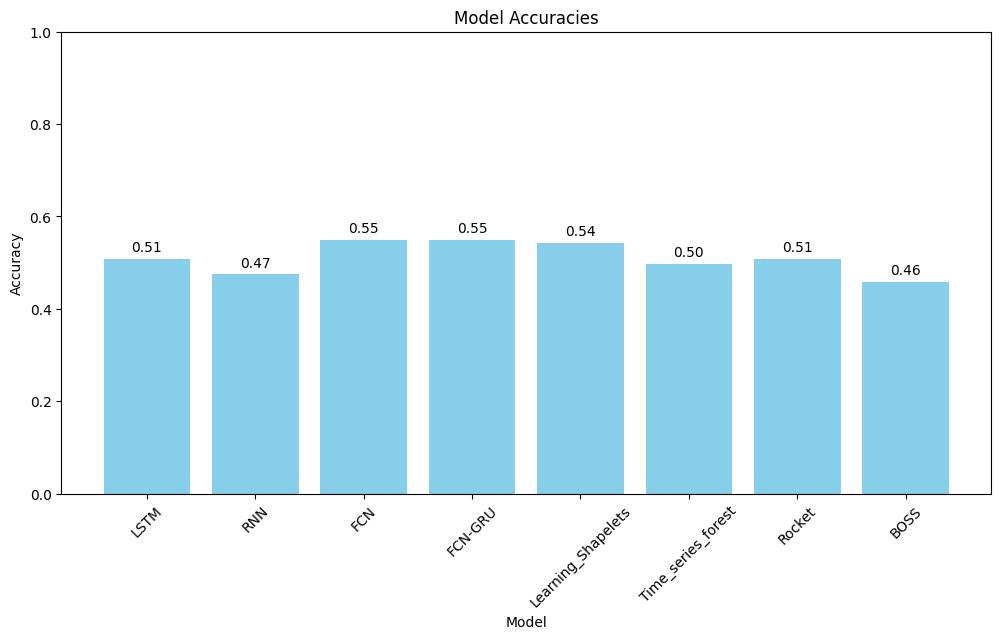

In [ ]:
accuracies = [accuracy_lstm_mv, accuracy_rnn_mv, accuracy_fcn_mv, accuracy_gru_fcn_mv, accuracy_ls_mv, accuracy_tsf_mv, accuracy_rocket_mv, accuracy_boss_mv]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

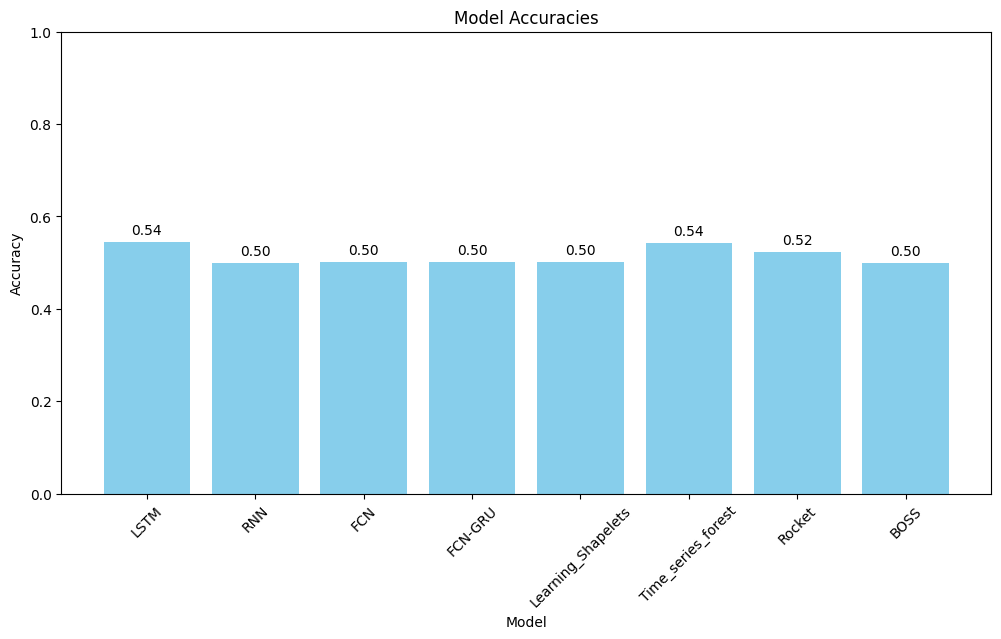

In [ ]:
accuracies = [accuracy_lstm_mv_30m, accuracy_rnn_mv_30m, accuracy_fcn_mv_30m, accuracy_gru_fcn_mv_30m, accuracy_ls_mv_30m, accuracy_tsf_mv_30m, accuracy_rocket_mv_30m, accuracy_boss_mv_30m]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

Dishwasher

In [15]:
dishwasher_df = sorted_merged_df
dishwasher_df['Dishwasher'] = dishwasher_df['Dishwasher'].apply(lambda x: 1 if x != 0 else 0)

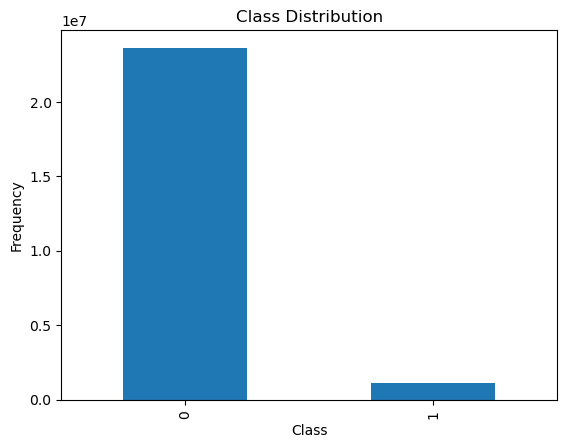

Imbalance Ratio: 20.62
Consider using oversampling or undersampling techniques.


In [16]:
# Check class distribution
class_distribution = dishwasher_df['Dishwasher'].value_counts()

# Visualize class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Determine if sampling is needed
majority_class = class_distribution.idxmax()
minority_class = class_distribution.idxmin()
dw_imbalance_ratio = class_distribution[majority_class] / class_distribution[minority_class]
print(f'Imbalance Ratio: {dw_imbalance_ratio:.2f}')

# Generally, if the imbalance ratio is greater than 1.5 or 2, consider sampling techniques
if dw_imbalance_ratio > 2:
    print("Consider using oversampling or undersampling techniques.")
else:
    print("Class distribution is relatively balanced. No need for sampling techniques.")


In [17]:
# Separate features and target
X = dishwasher_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y = dishwasher_df['Dishwasher']

total_rows = X.shape[0]  # total rows

# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)

# Create the training set (first 60%)
X_train = X[:rows_80_percent]
y_train = y[:rows_80_percent]

# Create the test set (last 20%)
X_test = X[-rows_20_percent:]
y_test = y[-rows_20_percent:]

# Identify the minority and majority classes
minority_class = y_train.value_counts().idxmin()
majority_class = y_train.value_counts().idxmax()

# Separate the data by class
minority_class_indices = y_train[y_train == minority_class].index
majority_class_indices = y_train[y_train == majority_class].index

# Define the desired number of samples from the majority class to balance the dataset
num_minority_samples = len(minority_class_indices)

# Function to under-sample the majority class while maintaining order
def under_sample_majority_class(df, majority_indices, num_samples):
    stride = len(majority_indices) // num_samples
    sampled_indices = majority_indices[::stride][:num_samples]
    return df.loc[sampled_indices]

# Under-sample the majority class
under_sampled_majority_df = under_sample_majority_class(X_train, majority_class_indices, num_minority_samples)
under_sampled_majority_labels = y_train[majority_class_indices][::(len(majority_class_indices) // num_minority_samples)][:num_minority_samples]

# Combine the minority class and under-sampled majority class
X_train_resampled = pd.concat([X_train.loc[minority_class_indices], under_sampled_majority_df])
y_train_resampled = pd.concat([y_train.loc[minority_class_indices], under_sampled_majority_labels])

# Sort the combined data to maintain the time order
X_train_resampled.sort_index(inplace=True)
y_train_resampled.sort_index(inplace=True)

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the resampled training features
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
# Transform the testing features
X_test_normalized = scaler.transform(X_test)

# Convert back to DataFrame for convenience
X_train_resampled_normalized_df = pd.DataFrame(X_train_resampled_normalized, columns=X.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X.columns)

In [ ]:
# Define the sequence length
sequence_length = 10

# Function to create sequences
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# Prepare the sequences for training data
X_train_sequences, y_train_sequences = create_sequences(X_train_resampled_normalized_df.values, y_train_resampled.values, sequence_length)

# Prepare the sequences for testing data
X_test_sequences, y_test_sequences = create_sequences(X_test_normalized_df.values, y_test.values, sequence_length)

In [ ]:
# Flatten the 3D array while preserving the order
X_train_sequences_2d = X_train_sequences.reshape(-1, X_train_sequences.shape[1])
X_test_sequences_2d = X_test_sequences.reshape(-1, X_test_sequences.shape[1])

In [ ]:
dw_df = sampled_df
dw_df['Dishwasher'] = dw_df['Dishwasher'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_dw = dw_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_dw = dw_df['Dishwasher']
total_rows = X_dw.shape[0]  # total rows
# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)
# Create the training set (first 60%)
X_dw_train = X_dw[:rows_80_percent]
y_dw_train = y_dw[:rows_80_percent]
# Create the validation set (next 20%)
X_dw_val = X_dw[-rows_20_percent:]
y_dw_val = y_dw[-rows_20_percent:]
# Identify the minority and majority classes
minority_class = y_dw_train.value_counts().idxmin()
majority_class = y_dw_train.value_counts().idxmax()
# Separate the data by class
minority_class_indices = y_dw_train[y_dw_train == minority_class].index
majority_class_indices = y_dw_train[y_dw_train == majority_class].index
# Define the desired number of samples from the majority class to balance the dataset
num_minority_samples = len(minority_class_indices)
# Under-sample the majority class
under_sampled_majority_df = under_sample_majority_class(X_dw_train, majority_class_indices, num_minority_samples)
under_sampled_majority_labels = y_dw_train[majority_class_indices][::(len(majority_class_indices) // num_minority_samples)][:num_minority_samples]
# Combine the minority class and under-sampled majority class
X_dw_train_resampled = pd.concat([X_dw_train.loc[minority_class_indices], under_sampled_majority_df])
y_dw_train_resampled = pd.concat([y_dw_train.loc[minority_class_indices], under_sampled_majority_labels])
# Sort the combined data to maintain the time order
X_dw_train_resampled.sort_index(inplace=True)
y_dw_train_resampled.sort_index(inplace=True)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_dw_train_resampled_normalized = scaler.fit_transform(X_dw_train_resampled)
X_dw_val_normalized = scaler.fit_transform(X_dw_val)
# Convert back to DataFrame for convenience
X_dw_train_resampled_normalized_df = pd.DataFrame(X_dw_train_resampled_normalized, columns=X.columns)
X_dw_val_normalized_df = pd.DataFrame(X_dw_val_normalized, columns=X.columns)
# Prepare the sequences for training data
X_dw_train_sequences, y_dw_train_sequences = create_sequences(X_dw_train_resampled_normalized_df.values, y_dw_train_resampled.values, sequence_length)
X_dw_val_sequences, y_dw_val_sequences = create_sequences(X_dw_val_normalized_df.values, y_dw_val.values, sequence_length)
# Flatten the 3D array while preserving the order
X_dw_train_sequences_2d = X_dw_train_sequences.reshape(-1, X_dw_train_sequences.shape[1])
X_dw_val_sequences_2d = X_dw_val_sequences.reshape(-1, X_dw_val_sequences.shape[1])

In [ ]:
# Downsample the data to 30-second intervals and take the first appearing value
downsampled_dw_30m_df = sorted_merged_df.resample('30T').first()
# Drop rows with NaN values resulting from downsampling
downsampled_dw_30m_df.dropna(inplace=True)
dw_30m_df = downsampled_dw_30m_df.sort_values(by='Unix', ascending=True)
dw_30m_df['Dishwasher'] = dw_30m_df['Dishwasher'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_dw_30m = dw_30m_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_dw_30m = dw_30m_df['Dishwasher']
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_dw_30m_normalized = scaler.fit_transform(X_dw_30m)
# Convert back to DataFrame for convenience
X_dw_30m_normalized_df = pd.DataFrame(X_dw_30m_normalized, columns=X_dw_30m.columns)
# Prepare the sequences for training data
X_dw_30m_sequences, y_dw_30m_sequences = create_sequences(X_dw_30m_normalized_df.values, y_dw_30m.values, sequence_length)
# Flatten the 3D array while preserving the order
X_dw_30m_sequences_2d = X_dw_30m_sequences.reshape(-1, X_dw_30m_sequences.shape[1])

LSTM

In [ ]:
def create_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
      for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
          # Create and compile the model
          model = create_model(units, dropout_rate)

          # Train the model
          model.fit(X_dw_train_sequences, y_dw_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)
          print("Model training successful")
          # Evaluate the model on the validation set
          val_loss = model.evaluate(X_dw_val_sequences, y_dw_val_sequences, verbose=0)
          val_loss = val_loss[0] if isinstance(val_loss, list) else val_loss
          # Check if this is the best score so far
          if val_loss < best_score:
            best_score = val_loss
            best_params = {
                'units': units,
                'dropout_rate': dropout_rate,
                'batch_size': batch_size,
                'epochs': epochs
            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Model training successful
Best parameters: {'units': 150, 'dropout_rate': 0.3, 'batch_size': 16, 'epochs': 30}
Best validation loss: 0.23248550295829773


In [ ]:
# Train the best model on the full training data and evaluate on the test set
lstm_model_dw = create_model(best_params['units'], best_params['dropout_rate'])
lstm_model_dw.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
lstm_model_dw.save('/content/drive/MyDrive/Saved_Models/lstm_model_dw_5a7h.h5')

In [ ]:
lstm_model_dw = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_dw_5a7h.h5') #load the model
y_pred = lstm_model_dw.predict(X_test_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_dw = balanced_accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_dw:.2f}')
# Print classification report
print(classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_test_sequences, y_pred_binary))

15488/15488 [==============================] - 63s 4ms/step
Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.96      0.88      0.92    472699
           1       0.08      0.21      0.11     22896

    accuracy                           0.85    495595
   macro avg       0.52      0.54      0.51    495595
weighted avg       0.92      0.85      0.88    495595

[[414085  58614]
 [ 18090   4806]]


In [ ]:
lstm_model_dw_30m = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_dw_5a7h.h5') #load the model
y_pred = lstm_model_dw_30m.predict(X_dw_30m_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_dw_30m = balanced_accuracy_score(y_dw_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_dw_30m:.2f}')
# Print classification report
print(classification_report(y_dw_30m_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_dw_30m_sequences, y_pred_binary))

918/918 [==============================] - 4s 4ms/step
Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     27998
           1       0.07      0.19      0.10      1353

    accuracy                           0.85     29351
   macro avg       0.51      0.54      0.51     29351
weighted avg       0.92      0.85      0.88     29351

[[24668  3330]
 [ 1095   258]]


RNN

In [ ]:
def create_rnn_model(units, dropout_rate, optimizer, activation):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30],
    'activation': ['tanh', 'relu']
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for optimizer in param_grid['optimizer']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    for activation in param_grid['activation']:
                        # Create and compile the model
                        model = create_rnn_model(units, dropout_rate, optimizer, activation)

                        # Train the model
                        model.fit(X_dw_train_sequences, y_dw_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                        # Evaluate the model on the validation set
                        val_loss = model.evaluate(X_dw_val_sequences, y_dw_val_sequences, verbose=0)

                        # Extract the loss value if necessary
                        if isinstance(val_loss, list):
                            val_loss = val_loss[0]

                        # Check if this is the best score so far
                        if val_loss < best_score:
                            best_score = val_loss
                            best_params = {
                                'units': units,
                                'dropout_rate': dropout_rate,
                                'optimizer': optimizer,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'activation': activation
                            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Best parameters: {'units': 150, 'dropout_rate': 0.4, 'optimizer': 'adam', 'batch_size': 32, 'epochs': 30, 'activation': 'relu'}
Best validation loss: 0.23842908442020416


In [ ]:
# Train the best model on the full training data and evaluate on the test set
rnn_model_dw = create_rnn_model(best_params['units'], best_params['dropout_rate'], best_params['optimizer'], best_params['activation'])
rnn_model_dw.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
rnn_model_dw.save('/content/drive/MyDrive/Saved_Models/rnn_model_dw_5a7h.h5')

In [ ]:
rnn_model_dw = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_dw_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_dw.predict(X_test_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_dw = balanced_accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_dw:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred_binary))

15488/15488 [==============================] - 27s 2ms/step
Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94    472699
           1       0.09      0.16      0.12     22896

    accuracy                           0.89    495595
   macro avg       0.53      0.54      0.53    495595
weighted avg       0.92      0.89      0.90    495595

Confusion Matrix:
 [[436317  36382]
 [ 19183   3713]]


In [ ]:
rnn_model_dw_30m = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_dw_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_dw_30m.predict(X_dw_30m_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_dw_30m = balanced_accuracy_score(y_dw_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_dw_30m:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_dw_30m_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_dw_30m_sequences, y_pred_binary))

918/918 [==============================] - 2s 2ms/step
Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93     27998
           1       0.08      0.16      0.11      1353

    accuracy                           0.88     29351
   macro avg       0.52      0.54      0.52     29351
weighted avg       0.92      0.88      0.90     29351

Confusion Matrix:
 [[25517  2481]
 [ 1132   221]]


FCN

In [ ]:
def create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer):
    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(GlobalAveragePooling1D())

    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'dropout_rate': [0.3, 0.4],  # Note: dropout isn't used in the base architecture, but you might want to test it
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for dropout_rate in param_grid['dropout_rate']:
                for optimizer_name in param_grid['optimizer']:
                    for batch_size in param_grid['batch_size']:
                        for epochs in param_grid['epochs']:
                            # Create optimizer instance
                            if optimizer_name == 'adam':
                                optimizer = Adam()
                            elif optimizer_name == 'rmsprop':
                                optimizer = RMSprop()

                            # Create and compile the model
                            model = create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer)

                            # Train the model
                            model.fit(X_dw_train_sequences, y_dw_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                            # Evaluate the model on the validation set
                            val_loss, _ = model.evaluate(X_dw_val_sequences, y_dw_val_sequences, verbose=0)

                            # Check if this is the best score so far
                            if val_loss < best_score:
                                best_score = val_loss
                                best_params = {
                                    'filters1': filters1,
                                    'filters2': filters2,
                                    'filters3': filters3,
                                    'dropout_rate': dropout_rate,
                                    'optimizer': optimizer_name,
                                    'batch_size': batch_size,
                                    'epochs': epochs
                                }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best validation loss: 0.9494803547859192


In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
fcn_model_dw = create_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['dropout_rate'], best_optimizer)
fcn_model_dw.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
fcn_model_dw.save('/content/drive/MyDrive/Saved_Models/fcn_model_dw_5a7h.h5')

In [ ]:
fcn_model_dw = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_dw_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_dw.predict(X_test_sequences) > 0.5).astype(int)
accuracy_fcn_dw = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_dw:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

15488/15488 [==============================] - 43s 3ms/step
Accuracy: 0.05
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    472699
           1       0.05      1.00      0.09     22896

    accuracy                           0.05    495595
   macro avg       0.02      0.50      0.04    495595
weighted avg       0.00      0.05      0.00    495595

Confusion Matrix:
 [[     0 472699]
 [     0  22896]]


In [ ]:
fcn_model_dw_30m = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_dw_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_dw_30m.predict(X_dw_30m_sequences) > 0.5).astype(int)
accuracy_fcn_dw_30m = accuracy_score(y_dw_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_dw_30m:.2f}')
print("Classification Report:\n", classification_report(y_dw_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_dw_30m_sequences, y_pred))

918/918 [==============================] - 3s 3ms/step
Accuracy: 0.05
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     27998
           1       0.05      1.00      0.09      1353

    accuracy                           0.05     29351
   macro avg       0.02      0.50      0.04     29351
weighted avg       0.00      0.05      0.00     29351

Confusion Matrix:
 [[    0 27998]
 [    0  1353]]


GRU-FCN

In [ ]:
input_shape = (X_train_sequences.shape[1], X_train_sequences.shape[2])

def create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Permute layer
    permute_layer = Permute((2, 1))(input_layer)

    # FCN branch
    conv1 = Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1)(permute_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    # GRU branch
    gru = GRU(units=gru_units)(input_layer)
    gru = Dropout(dropout_rate)(gru)

    # Concatenate branches
    concat = Concatenate()([gap, gru])

    # Output layer
    output_layer = Dense(1, activation='softmax')(concat)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'gru_units': [8, 10],
    'dropout_rate': [0.3, 0.8],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for gru_units in param_grid['gru_units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for optimizer_name in param_grid['optimizer']:
                        for batch_size in param_grid['batch_size']:
                            for epochs in param_grid['epochs']:
                                # Create optimizer instance
                                if optimizer_name == 'adam':
                                    optimizer = Adam()
                                elif optimizer_name == 'rmsprop':
                                    optimizer = RMSprop()

                                # Create and compile the model
                                model = create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape)

                                # Train the model
                                model.fit(X_dw_train_sequences, y_dw_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                                # Evaluate the model on the validation set
                                val_loss, _ = model.evaluate(X_dw_val_sequences, y_dw_val_sequences, verbose=0)

                                # Check if this is the best score so far
                                if val_loss < best_score:
                                    best_score = val_loss
                                    best_params = {
                                        'filters1': filters1,
                                        'filters2': filters2,
                                        'filters3': filters3,
                                        'gru_units': gru_units,
                                        'dropout_rate': dropout_rate,
                                        'optimizer': optimizer_name,
                                        'batch_size': batch_size,
                                        'epochs': epochs
                                    }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")


Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'gru_units': 8, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best validation loss: 0.9494803547859192


In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
gru_fcn_model_dw = create_gru_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['gru_units'], best_params['dropout_rate'], best_optimizer, input_shape)
gru_fcn_model_dw.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
gru_fcn_model_dw.save('/content/drive/MyDrive/Saved_Models/gru_fcn_model_dw_5a7h.h5')

In [ ]:
gru_fcn_model_dw = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_dw_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_dw.predict(X_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_dw = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_dw:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

15488/15488 [==============================] - 31s 2ms/step
Accuracy: 0.05
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    472699
           1       0.05      1.00      0.09     22896

    accuracy                           0.05    495595
   macro avg       0.02      0.50      0.04    495595
weighted avg       0.00      0.05      0.00    495595

Confusion Matrix:
 [[     0 472699]
 [     0  22896]]


In [ ]:
gru_fcn_model_dw_30m = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_dw_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_dw_30m.predict(X_dw_30m_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_dw_30m = accuracy_score(y_dw_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_dw_30m:.2f}')
print("Classification Report:\n", classification_report(y_dw_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_dw_30m_sequences, y_pred))

918/918 [==============================] - 2s 2ms/step
Accuracy: 0.05
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     27998
           1       0.05      1.00      0.09      1353

    accuracy                           0.05     29351
   macro avg       0.02      0.50      0.04     29351
weighted avg       0.00      0.05      0.00     29351

Confusion Matrix:
 [[    0 27998]
 [    0  1353]]


Learning Shapelet

In [ ]:
param_grid = {
    'n_shapelets_per_size': [0.2, 0.3],  # Fraction of the number of timestamps
    'min_shapelet_length': [0.1, 0.2],  # Fraction of the number of timestamps
    'shapelet_scale': [2, 4],              # Different scales for the lengths of the shapelets
    'penalty': ['l2', 'l1']                  # Norm used in the penalization
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    shapelet_clf = LearningShapelets(
        n_shapelets_per_size=params['n_shapelets_per_size'],
        min_shapelet_length=params['min_shapelet_length'],
        shapelet_scale=params['shapelet_scale'],
        penalty=params['penalty']
    )

    # Train the model on the training data
    shapelet_clf.fit(X_dw_train_sequences_2d, y_dw_train_sequences)

    # Predict on the validation set
    y_val_pred = shapelet_clf.predict(X_dw_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_dw_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'n_shapelets_per_size': 0.2, 'min_shapelet_length': 0.1, 'shapelet_scale': 2, 'penalty': 'l2'}
Validation accuracy with best parameters: 0.9484512251502543


In [ ]:
learning_shapelets_dw = LearningShapelets(
        n_shapelets_per_size=best_params['n_shapelets_per_size'],
        min_shapelet_length=best_params['min_shapelet_length'],
        shapelet_scale=best_params['shapelet_scale'],
        penalty=best_params['penalty']
    )
learning_shapelets_dw.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_dw_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(learning_shapelets_dw, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_dw_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_dw = pickle.load(file)

y_pred = learning_shapelets_dw.predict(X_test_sequences_2d)
accuracy_ls_dw = balanced_accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_dw:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     33024
           1       0.00      0.00      0.00      1517

    accuracy                           0.96     34541
   macro avg       0.48      0.50      0.49     34541
weighted avg       0.91      0.96      0.93     34541

Confusion Matrix:
 [[33024     0]
 [ 1517     0]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_dw_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_dw_30m = pickle.load(file)

y_pred = learning_shapelets_dw_30m.predict(X_dw_30m_sequences_2d)
accuracy_ls_dw_30m = balanced_accuracy_score(y_dw_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_dw_30m:.2f}')
print("Classification Report:\n", classification_report(y_dw_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_dw_30m_sequences, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     27998
           1       0.00      0.00      0.00      1353

    accuracy                           0.95     29351
   macro avg       0.48      0.50      0.49     29351
weighted avg       0.91      0.95      0.93     29351

Confusion Matrix:
 [[27998     0]
 [ 1353     0]]


Time Series Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'min_interval': [3, 5],
    'n_jobs': [-1]
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    tsf_clf = TimeSeriesForestClassifier(
        n_estimators=params['n_estimators'],
        min_interval=params['min_interval'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    tsf_clf.fit(X_dw_train_sequences_2d, y_dw_train_sequences)

    # Predict on the validation set
    y_val_pred = tsf_clf.predict(X_dw_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_dw_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'n_estimators': 100, 'min_interval': 3, 'n_jobs': -1}
Validation accuracy with best parameters: 0.623722532642367


In [ ]:
tsf_dw = TimeSeriesForestClassifier(
        n_estimators=best_params['n_estimators'],
        min_interval=best_params['min_interval'],
        n_jobs=best_params['n_jobs']
    )

tsf_dw.fit(X_train_sequences_2d, y_train_sequences)
# Predict on the test set
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_dw_5a7h"
mlflow_sktime.save_model(
    sktime_model=tsf_dw,
    path=model_path)

In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_dw_5a7h"
# Load the model from the specified file path
tsf_dw = mlflow_sktime.load_model(model_uri=model_path)
y_pred = tsf_dw.predict(X_test_sequences_2d)
accuracy_tsf_dw = balanced_accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_dw:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93    472699
           1       0.09      0.19      0.12     22896

    accuracy                           0.87    495595
   macro avg       0.52      0.55      0.53    495595
weighted avg       0.92      0.87      0.89    495595

Confusion Matrix:
 [[428368  44331]
 [ 18645   4251]]


In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_dw_5a7h"
# Load the model from the specified file path
tsf_dw_30m = mlflow_sktime.load_model(model_uri=model_path)
y_pred = tsf_dw_30m.predict(X_dw_30m_sequences_2d)
accuracy_tsf_dw_30m = balanced_accuracy_score(y_dw_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_dw_30m:.2f}')
print("Classification Report:\n", classification_report(y_dw_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_dw_30m_sequences, y_pred))

Accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92     27998
           1       0.07      0.17      0.10      1353

    accuracy                           0.86     29351
   macro avg       0.52      0.53      0.51     29351
weighted avg       0.92      0.86      0.89     29351

Confusion Matrix:
 [[25000  2998]
 [ 1117   236]]


Rocket

In [ ]:
param_grid = {
    'num_kernels': [10000,15000],  # Number of kernels for the Rocket transform
    'rocket_transform': ['rocket'],
#    'rocket_transform': ['rocket', 'minirocket', 'multirocket'],  # Type of Rocket transformer to use
    'max_dilations_per_kernel': [32,64],  # Max number of dilations per kernel (MiniRocket and MultiRocket only)
    'n_features_per_kernel': [4,8],  # Number of features per kernel (MultiRocket only)
    'use_multivariate': ['no'],  # Whether to use multivariate Rocket transforms or univariate ones
    'n_jobs': [-1]  # Number of jobs to run in parallel for both fit and predict
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    rocket_clf = RocketClassifier(
        num_kernels=params['num_kernels'],
        rocket_transform=params['rocket_transform'],
        max_dilations_per_kernel=params['max_dilations_per_kernel'],  # Default to 32 if not provided
        n_features_per_kernel=params['n_features_per_kernel'],  # Default to 4 if not provided
        use_multivariate=params['use_multivariate'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    rocket_clf.fit(X_dw_train_sequences_2d, y_dw_train_sequences)

    # Predict on the validation set
    y_val_pred = rocket_clf.predict(X_dw_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_dw_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'num_kernels': 15000, 'rocket_transform': 'rocket', 'max_dilations_per_kernel': 64, 'n_features_per_kernel': 8, 'use_multivariate': 'no', 'n_jobs': -1}
Validation accuracy with best parameters: 0.5292076344707923


In [ ]:
rocket_dw = RocketClassifier(
        num_kernels=best_params['num_kernels'],
        rocket_transform=best_params['rocket_transform'],
        max_dilations_per_kernel=best_params['max_dilations_per_kernel'],
        n_features_per_kernel=best_params['n_features_per_kernel'],
        use_multivariate=best_params['use_multivariate'],
        n_jobs=best_params['n_jobs']
    )

rocket_dw.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_dw_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(rocket_dw, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_dw_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    rocket_dw = pickle.load(file)
# Predict on the test set
y_pred = rocket_dw.predict(X_test_sequences_2d)
accuracy_rocket_dw = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_dw:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.56      0.70     33024
           1       0.04      0.43      0.08      1517

    accuracy                           0.55     34541
   macro avg       0.50      0.49      0.39     34541
weighted avg       0.92      0.55      0.68     34541

Confusion Matrix:
 [[18430 14594]
 [  865   652]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_dw_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    rocket_dw_30m = pickle.load(file)
# Predict on the test set
y_pred = rocket_dw_30m.predict(X_dw_30m_sequences_2d)
accuracy_rocket_dw_30m = accuracy_score(y_dw_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_dw_30m:.2f}')
print("Classification Report:\n", classification_report(y_dw_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_dw_30m_sequences, y_pred))

Accuracy: 0.56
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.57      0.71     27998
           1       0.05      0.46      0.09      1353

    accuracy                           0.56     29351
   macro avg       0.50      0.51      0.40     29351
weighted avg       0.91      0.56      0.68     29351

Confusion Matrix:
 [[15864 12134]
 [  728   625]]


BOSS

In [ ]:
param_grid = {
    'alphabet_size': [2, 4],  # Number of possible letters (values) for each word
    'n_jobs': [-1],  # Number of jobs to run in parallel for both fit and predict
    'feature_selection': ['chi2', 'none', 'random']  # Sets the feature selections strategy to be used
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    boss_clf = BOSSEnsemble(
        alphabet_size=params['alphabet_size'],
        n_jobs=params['n_jobs'],
        feature_selection=params['feature_selection']
    )

    # Train the model on the training data
    boss_clf.fit(X_dw_train_sequences_2d, y_dw_train_sequences)

    # Predict on the validation set
    y_val_pred = boss_clf.predict(X_dw_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_dw_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'alphabet_size': 2, 'n_jobs': -1, 'feature_selection': 'none'}
Validation accuracy with best parameters: 0.39496818970503184


In [ ]:
boss_dw = BOSSEnsemble(
        alphabet_size=best_params['alphabet_size'],
        n_jobs=best_params['n_jobs'],
        feature_selection=best_params['feature_selection']
    )

boss_dw.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_dw_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(boss_dw, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_dw_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_dw = pickle.load(file)
# Predict on the test set
y_pred = boss_dw.predict(X_test_sequences_2d)
accuracy_boss_dw = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_dw:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.36
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.35      0.51     33024
           1       0.05      0.67      0.08      1517

    accuracy                           0.36     34541
   macro avg       0.50      0.51      0.30     34541
weighted avg       0.92      0.36      0.49     34541

Confusion Matrix:
 [[11468 21556]
 [  494  1023]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_dw_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_dw_30m = pickle.load(file)
# Predict on the test set
y_pred = boss_dw_30m.predict(X_dw_30m_sequences_2d)
accuracy_boss_dw_30m = accuracy_score(y_dw_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_dw_30m:.2f}')
print("Classification Report:\n", classification_report(y_dw_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_dw_30m_sequences, y_pred))

Accuracy: 0.37
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.35      0.51     27998
           1       0.05      0.71      0.09      1353

    accuracy                           0.37     29351
   macro avg       0.51      0.53      0.30     29351
weighted avg       0.92      0.37      0.49     29351

Confusion Matrix:
 [[ 9756 18242]
 [  387   966]]


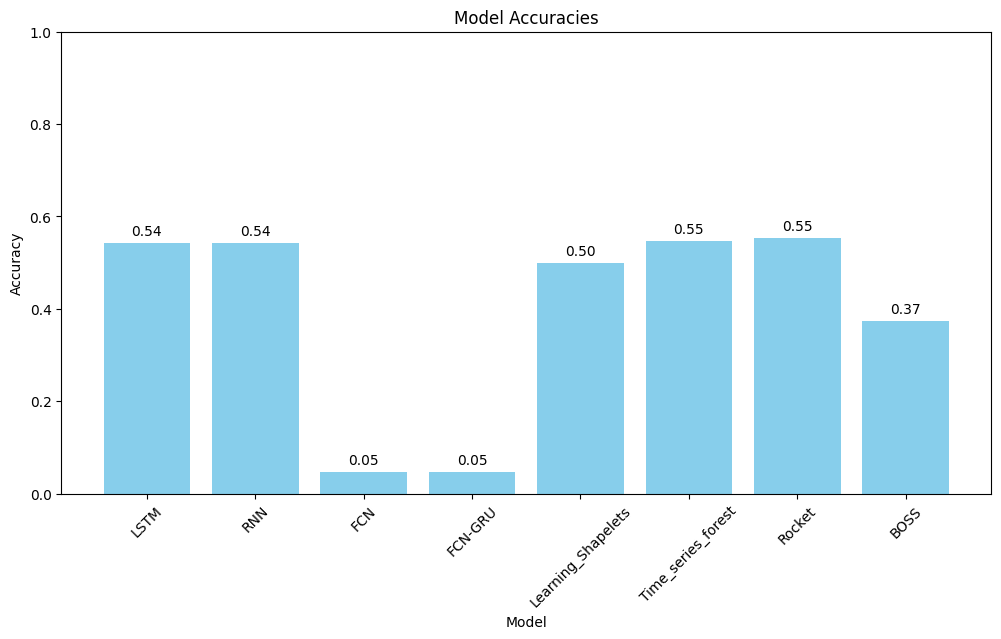

In [ ]:
accuracies = [accuracy_lstm_dw, accuracy_rnn_dw, accuracy_fcn_dw, accuracy_gru_fcn_dw, accuracy_ls_dw, accuracy_tsf_dw, accuracy_rocket_dw, accuracy_boss_dw]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

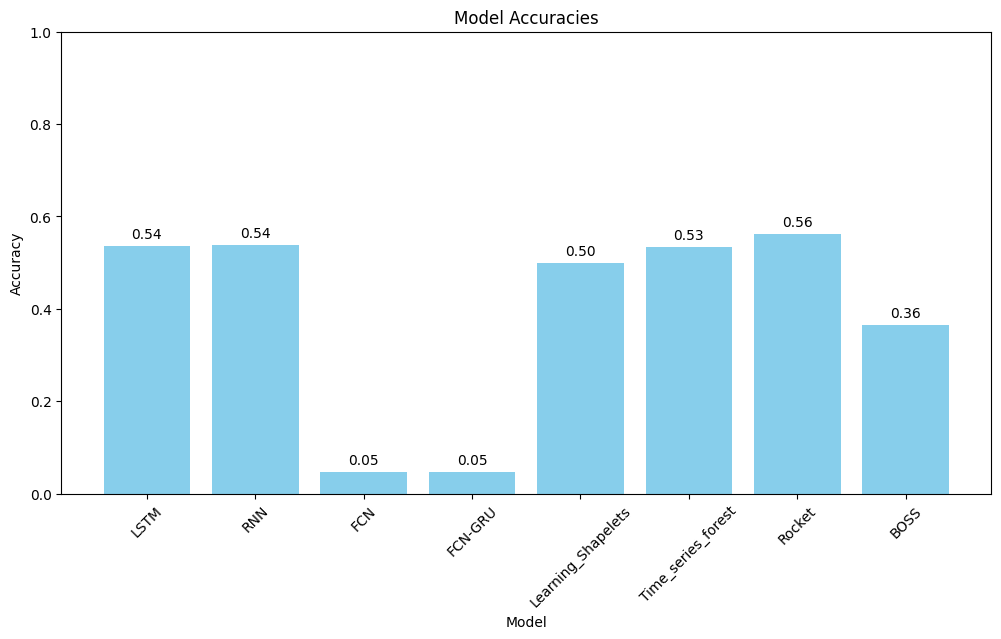

In [ ]:
accuracies = [accuracy_lstm_dw_30m, accuracy_rnn_dw_30m, accuracy_fcn_dw_30m, accuracy_gru_fcn_dw_30m, accuracy_ls_dw_30m, accuracy_tsf_dw_30m, accuracy_rocket_dw_30m, accuracy_boss_dw_30m]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

Kettle

In [18]:
kettle_df = sorted_merged_df
kettle_df['Kettle'] = kettle_df['Kettle'].apply(lambda x: 1 if x != 0 else 0)

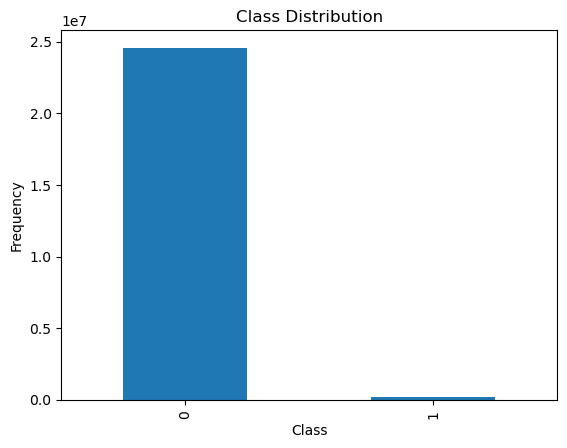

Imbalance Ratio: 115.95
Consider using oversampling or undersampling techniques.


In [19]:
# Check class distribution
class_distribution = kettle_df['Kettle'].value_counts()

# Visualize class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Determine if sampling is needed
majority_class = class_distribution.idxmax()
minority_class = class_distribution.idxmin()
kt_imbalance_ratio = class_distribution[majority_class] / class_distribution[minority_class]
print(f'Imbalance Ratio: {kt_imbalance_ratio:.2f}')

# Generally, if the imbalance ratio is greater than 1.5 or 2, consider sampling techniques
if kt_imbalance_ratio > 2:
    print("Consider using oversampling or undersampling techniques.")
else:
    print("Class distribution is relatively balanced. No need for sampling techniques.")


In [21]:
# Separate features and target
X = kettle_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y = kettle_df['Kettle']

total_rows = X.shape[0]  # total rows

# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)

# Create the training set (first 60%)
X_train = X[:rows_80_percent]
y_train = y[:rows_80_percent]

# Create the test set (last 20%)
X_test = X[-rows_20_percent:]
y_test = y[-rows_20_percent:]

# Identify the minority and majority classes
minority_class = y_train.value_counts().idxmin()
majority_class = y_train.value_counts().idxmax()

# Separate the data by class
minority_class_indices = y_train[y_train == minority_class].index
majority_class_indices = y_train[y_train == majority_class].index

# Define the desired number of samples from the majority class to balance the dataset
num_minority_samples = len(minority_class_indices)

# Function to under-sample the majority class while maintaining order
def under_sample_majority_class(df, majority_indices, num_samples):
    stride = len(majority_indices) // num_samples
    sampled_indices = majority_indices[::stride][:num_samples]
    return df.loc[sampled_indices]

# Under-sample the majority class
under_sampled_majority_df = under_sample_majority_class(X_train, majority_class_indices, num_minority_samples)
under_sampled_majority_labels = y_train[majority_class_indices][::(len(majority_class_indices) // num_minority_samples)][:num_minority_samples]

# Combine the minority class and under-sampled majority class
X_train_resampled = pd.concat([X_train.loc[minority_class_indices], under_sampled_majority_df])
y_train_resampled = pd.concat([y_train.loc[minority_class_indices], under_sampled_majority_labels])

# Sort the combined data to maintain the time order
X_train_resampled.sort_index(inplace=True)
y_train_resampled.sort_index(inplace=True)

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the resampled training features
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
# Transform the testing features
X_test_normalized = scaler.transform(X_test)

# Convert back to DataFrame for convenience
X_train_resampled_normalized_df = pd.DataFrame(X_train_resampled_normalized, columns=X.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X.columns)

In [ ]:
# Define the sequence length
sequence_length = 10

# Function to create sequences
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# Prepare the sequences for training data
X_train_sequences, y_train_sequences = create_sequences(X_train_resampled_normalized_df.values, y_train_resampled.values, sequence_length)

# Prepare the sequences for testing data
X_test_sequences, y_test_sequences = create_sequences(X_test_normalized_df.values, y_test.values, sequence_length)

In [ ]:
# Flatten the 3D array while preserving the order
X_train_sequences_2d = X_train_sequences.reshape(-1, X_train_sequences.shape[1])
X_test_sequences_2d = X_test_sequences.reshape(-1, X_test_sequences.shape[1])

In [ ]:
kt_df = sampled_df
kt_df['Kettle'] = kt_df['Kettle'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_kt = kt_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_kt = kt_df['Kettle']
total_rows = X_kt.shape[0]  # total rows
# Calculate the number of rows for each subset
rows_80_percent = int(total_rows * 0.8)
rows_20_percent = int(total_rows * 0.2)
# Create the training set (first 80%)
X_kt_train = X_kt[:rows_80_percent]
y_kt_train = y_kt[:rows_80_percent]
# Create the validation set (next 20%)
X_kt_val = X_kt[-rows_20_percent:]
y_kt_val = y_kt[-rows_20_percent:]
# Identify the minority and majority classes
minority_class = y_kt_train.value_counts().idxmin()
majority_class = y_kt_train.value_counts().idxmax()
# Separate the data by class
minority_class_indices = y_kt_train[y_kt_train == minority_class].index
majority_class_indices = y_kt_train[y_kt_train == majority_class].index
# Define the desired number of samples from the majority class to balance the dataset
num_minority_samples = len(minority_class_indices)
# Under-sample the majority class
under_sampled_majority_df = under_sample_majority_class(X_kt_train, majority_class_indices, num_minority_samples)
under_sampled_majority_labels = y_kt_train[majority_class_indices][::(len(majority_class_indices) // num_minority_samples)][:num_minority_samples]
# Combine the minority class and under-sampled majority class
X_kt_train_resampled = pd.concat([X_kt_train.loc[minority_class_indices], under_sampled_majority_df])
y_kt_train_resampled = pd.concat([y_kt_train.loc[minority_class_indices], under_sampled_majority_labels])
# Sort the combined data to maintain the time order
X_kt_train_resampled.sort_index(inplace=True)
y_kt_train_resampled.sort_index(inplace=True)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_kt_train_resampled_normalized = scaler.fit_transform(X_kt_train_resampled)
X_kt_val_normalized = scaler.fit_transform(X_kt_val)
# Convert back to DataFrame for convenience
X_kt_train_resampled_normalized_df = pd.DataFrame(X_kt_train_resampled_normalized, columns=X.columns)
X_kt_val_normalized_df = pd.DataFrame(X_kt_val_normalized, columns=X.columns)
# Prepare the sequences for training data
X_kt_train_sequences, y_kt_train_sequences = create_sequences(X_kt_train_resampled_normalized_df.values, y_kt_train_resampled.values, sequence_length)
X_kt_val_sequences, y_kt_val_sequences = create_sequences(X_kt_val_normalized_df.values, y_kt_val.values, sequence_length)
# Flatten the 3D array while preserving the order
X_kt_train_sequences_2d = X_kt_train_sequences.reshape(-1, X_kt_train_sequences.shape[1])
X_kt_val_sequences_2d = X_kt_val_sequences.reshape(-1, X_kt_val_sequences.shape[1])

In [ ]:
# Downsample the data to 30-second intervals and take the first appearing value
downsampled_kt_30m_df = sorted_merged_df.resample('30T').first()
# Drop rows with NaN values resulting from downsampling
downsampled_kt_30m_df.dropna(inplace=True)
kt_30m_df = downsampled_kt_30m_df.sort_values(by='Unix', ascending=True)
kt_30m_df['Kettle'] = kt_30m_df['Kettle'].apply(lambda x: 1 if x != 0 else 0)
# Separate features and target
X_kt_30m = kt_30m_df.drop(['Washing_Machine','Unix','Television_Site', 'Microwave', 'Dishwasher', 'Kettle'], axis=1)
y_kt_30m = kt_30m_df['Kettle']
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the resampled training features
X_kt_30m_normalized = scaler.fit_transform(X_kt_30m)
# Convert back to DataFrame for convenience
X_kt_30m_normalized_df = pd.DataFrame(X_kt_30m_normalized, columns=X_kt_30m.columns)
# Prepare the sequences for training data
X_kt_30m_sequences, y_kt_30m_sequences = create_sequences(X_kt_30m_normalized_df.values, y_kt_30m.values, sequence_length)
# Flatten the 3D array while preserving the order
X_kt_30m_sequences_2d = X_kt_30m_sequences.reshape(-1, X_kt_30m_sequences.shape[1])

LSTM

In [ ]:
def create_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
      for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
          # Create and compile the model
          model = create_model(units, dropout_rate)

          # Train the model
          model.fit(X_kt_train_sequences, y_kt_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

          # Evaluate the model on the validation set
          val_loss = model.evaluate(X_kt_val_sequences, y_kt_val_sequences, verbose=0)
          val_loss = val_loss[0] if isinstance(val_loss, list) else val_loss
          # Check if this is the best score so far
          if val_loss < best_score:
            best_score = val_loss
            best_params = {
                'units': units,
                'dropout_rate': dropout_rate,
                'batch_size': batch_size,
                'epochs': epochs
            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Best parameters: {'units': 150, 'dropout_rate': 0.4, 'batch_size': 16, 'epochs': 30}
Best validation loss: 0.157542884349823


In [ ]:
# Train the best model on the full training data and evaluate on the test set
lstm_model_kt = create_model(best_params['units'], best_params['dropout_rate'])
lstm_model_kt.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
lstm_model_kt.save('/content/drive/MyDrive/Saved_Models/lstm_model_kt_5a7h.h5')

In [ ]:
lstm_model_kt = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_kt_5a7h.h5') #load the model
y_pred = lstm_model_kt.predict(X_test_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_kt = accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_kt:.2f}')
# Print classification report
print(classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_test_sequences, y_pred_binary))

15488/15488 [==============================] - 60s 4ms/step
Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.99      0.69      0.81    492023
           1       0.01      0.29      0.01      3572

    accuracy                           0.68    495595
   macro avg       0.50      0.49      0.41    495595
weighted avg       0.99      0.68      0.81    495595

[[337649 154374]
 [  2530   1042]]


In [ ]:
lstm_model_kt_30m = load_model('/content/drive/MyDrive/Saved_Models/lstm_model_kt_5a7h.h5') #load the model
y_pred = lstm_model_kt_30m.predict(X_kt_30m_sequences)
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_lstm_kt_30m = accuracy_score(y_kt_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_lstm_kt_30m:.2f}')
# Print classification report
print(classification_report(y_kt_30m_sequences, y_pred_binary))
# Print confusion matrix
print(confusion_matrix(y_kt_30m_sequences, y_pred_binary))

918/918 [==============================] - 4s 4ms/step
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     29079
           1       0.01      0.45      0.02       272

    accuracy                           0.65     29351
   macro avg       0.50      0.55      0.41     29351
weighted avg       0.98      0.65      0.78     29351

[[19067 10012]
 [  150   122]]


RNN

In [ ]:
def create_rnn_model(units, dropout_rate, optimizer, activation):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units': [100, 150],
    'dropout_rate': [0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30],
    'activation': ['tanh', 'relu']
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for optimizer in param_grid['optimizer']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    for activation in param_grid['activation']:
                        # Create and compile the model
                        model = create_rnn_model(units, dropout_rate, optimizer, activation)

                        # Train the model
                        model.fit(X_kt_train_sequences, y_kt_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                        # Evaluate the model on the validation set
                        val_loss = model.evaluate(X_kt_val_sequences, y_kt_val_sequences, verbose=0)

                        # Extract the loss value if necessary
                        if isinstance(val_loss, list):
                            val_loss = val_loss[0]

                        # Check if this is the best score so far
                        if val_loss < best_score:
                            best_score = val_loss
                            best_params = {
                                'units': units,
                                'dropout_rate': dropout_rate,
                                'optimizer': optimizer,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'activation': activation
                            }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Best parameters: {'units': 150, 'dropout_rate': 0.4, 'optimizer': 'rmsprop', 'batch_size': 32, 'epochs': 30, 'activation': 'tanh'}
Best validation loss: 0.22316822409629822


In [ ]:
# Train the best model on the full training data and evaluate on the test set
rnn_model_kt = create_rnn_model(best_params['units'], best_params['dropout_rate'], best_params['optimizer'], best_params['activation'])
rnn_model_kt.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
rnn_model_kt.save('/content/drive/MyDrive/Saved_Models/rnn_model_kt_5a7h.h5')

In [ ]:
rnn_model_kt = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_kt_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_kt.predict(X_test_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_kt = accuracy_score(y_test_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_kt:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_test_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred_binary))

15488/15488 [==============================] - 28s 2ms/step
Accuracy: 0.17
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.17      0.28    492023
           1       0.01      0.74      0.01      3572

    accuracy                           0.17    495595
   macro avg       0.50      0.45      0.15    495595
weighted avg       0.98      0.17      0.28    495595

Confusion Matrix:
 [[ 81570 410453]
 [   918   2654]]


In [ ]:
rnn_model_kt_30m = load_model('/content/drive/MyDrive/Saved_Models/rnn_model_kt_5a7h.h5') #load the model
# Make predictions
y_pred = rnn_model_kt_30m.predict(X_kt_30m_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)
# Evaluate the model
accuracy_rnn_kt_30m = accuracy_score(y_kt_30m_sequences, y_pred_binary)
print(f'Accuracy: {accuracy_rnn_kt_30m:.2f}')
# Print classification report
print("Classification Report:\n", classification_report(y_kt_30m_sequences, y_pred_binary))
# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_kt_30m_sequences, y_pred_binary))

918/918 [==============================] - 2s 2ms/step
Accuracy: 0.23
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.22      0.36     29079
           1       0.01      0.81      0.02       272

    accuracy                           0.23     29351
   macro avg       0.50      0.52      0.19     29351
weighted avg       0.98      0.23      0.36     29351

Confusion Matrix:
 [[ 6432 22647]
 [   52   220]]


FCN

In [ ]:
def create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer):
    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(GlobalAveragePooling1D())

    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'dropout_rate': [0.3, 0.4],  # Note: dropout isn't used in the base architecture, but you might want to test it
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for dropout_rate in param_grid['dropout_rate']:
                for optimizer_name in param_grid['optimizer']:
                    for batch_size in param_grid['batch_size']:
                        for epochs in param_grid['epochs']:
                            # Create optimizer instance
                            if optimizer_name == 'adam':
                                optimizer = Adam()
                            elif optimizer_name == 'rmsprop':
                                optimizer = RMSprop()

                            # Create and compile the model
                            model = create_fcn_model(filters1, filters2, filters3, dropout_rate, optimizer)

                            # Train the model
                            model.fit(X_kt_train_sequences, y_kt_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                            # Evaluate the model on the validation set
                            val_loss, _ = model.evaluate(X_kt_val_sequences, y_kt_val_sequences, verbose=0)

                            # Check if this is the best score so far
                            if val_loss < best_score:
                                best_score = val_loss
                                best_params = {
                                    'filters1': filters1,
                                    'filters2': filters2,
                                    'filters3': filters3,
                                    'dropout_rate': dropout_rate,
                                    'optimizer': optimizer_name,
                                    'batch_size': batch_size,
                                    'epochs': epochs
                                }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best validation loss: 0.9893170595169067


In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
fcn_model_kt = create_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['dropout_rate'], best_optimizer)
fcn_model_kt.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
fcn_model_kt.save('/content/drive/MyDrive/Saved_Models/fcn_model_kt_5a7h.h5')

In [ ]:
fcn_model_kt = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_kt_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_kt.predict(X_test_sequences) > 0.5).astype(int)
accuracy_fcn_kt = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_kt:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

15488/15488 [==============================] - 42s 3ms/step
Accuracy: 0.01
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    492023
           1       0.01      1.00      0.01      3572

    accuracy                           0.01    495595
   macro avg       0.00      0.50      0.01    495595
weighted avg       0.00      0.01      0.00    495595

Confusion Matrix:
 [[     0 492023]
 [     0   3572]]


In [ ]:
fcn_model_kt_30m = load_model('/content/drive/MyDrive/Saved_Models/fcn_model_kt_5a7h.h5') #load the model
# Make predictions
y_pred = (fcn_model_kt_30m.predict(X_kt_30m_sequences) > 0.5).astype(int)
accuracy_fcn_kt_30m = accuracy_score(y_kt_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_fcn_kt_30m:.2f}')
print("Classification Report:\n", classification_report(y_kt_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_kt_30m_sequences, y_pred))

918/918 [==============================] - 3s 3ms/step
Accuracy: 0.01
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     29079
           1       0.01      1.00      0.02       272

    accuracy                           0.01     29351
   macro avg       0.00      0.50      0.01     29351
weighted avg       0.00      0.01      0.00     29351

Confusion Matrix:
 [[    0 29079]
 [    0   272]]


GRU-FCN

In [ ]:
input_shape = (X_train_sequences.shape[1], X_train_sequences.shape[2])

def create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Permute layer
    permute_layer = Permute((2, 1))(input_layer)

    # FCN branch
    conv1 = Conv1D(filters=filters1, kernel_size=8, padding='same', strides=1)(permute_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=filters2, kernel_size=5, padding='same', strides=1)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=filters3, kernel_size=3, padding='same', strides=1)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    # GRU branch
    gru = GRU(units=gru_units)(input_layer)
    gru = Dropout(dropout_rate)(gru)

    # Concatenate branches
    concat = Concatenate()([gap, gru])

    # Output layer
    output_layer = Dense(1, activation='softmax')(concat)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [128],
    'filters2': [256],
    'filters3': [128],
    'gru_units': [8, 10],
    'dropout_rate': [0.3, 0.8],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [20, 30]
}

# Initialize variables to store the best configuration
best_score = float('inf')
best_params = {}

# Iterate over all possible combinations of hyperparameters
for filters1 in param_grid['filters1']:
    for filters2 in param_grid['filters2']:
        for filters3 in param_grid['filters3']:
            for gru_units in param_grid['gru_units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for optimizer_name in param_grid['optimizer']:
                        for batch_size in param_grid['batch_size']:
                            for epochs in param_grid['epochs']:
                                # Create optimizer instance
                                if optimizer_name == 'adam':
                                    optimizer = Adam()
                                elif optimizer_name == 'rmsprop':
                                    optimizer = RMSprop()

                                # Create and compile the model
                                model = create_gru_fcn_model(filters1, filters2, filters3, gru_units, dropout_rate, optimizer, input_shape)

                                # Train the model
                                model.fit(X_kt_train_sequences, y_kt_train_sequences, epochs=epochs, batch_size=batch_size, verbose=0)

                                # Evaluate the model on the validation set
                                val_loss, _ = model.evaluate(X_kt_val_sequences, y_kt_val_sequences, verbose=0)

                                # Check if this is the best score so far
                                if val_loss < best_score:
                                    best_score = val_loss
                                    best_params = {
                                        'filters1': filters1,
                                        'filters2': filters2,
                                        'filters3': filters3,
                                        'gru_units': gru_units,
                                        'dropout_rate': dropout_rate,
                                        'optimizer': optimizer_name,
                                        'batch_size': batch_size,
                                        'epochs': epochs
                                    }

# Print the best hyperparameters and the corresponding score
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")


Best parameters: {'filters1': 128, 'filters2': 256, 'filters3': 128, 'gru_units': 8, 'dropout_rate': 0.3, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 20}
Best validation loss: 0.9893170595169067


In [ ]:
# Train the best model on the full training data and evaluate on the test set
best_optimizer = Adam() if best_params['optimizer'] == 'adam' else RMSprop()
gru_fcn_model_kt = create_gru_fcn_model(best_params['filters1'], best_params['filters2'], best_params['filters3'], best_params['gru_units'], best_params['dropout_rate'], best_optimizer, input_shape)
gru_fcn_model_kt.fit(X_train_sequences, y_train_sequences, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
gru_fcn_model_kt.save('/content/drive/MyDrive/Saved_Models/gru_fcn_model_kt_5a7h.h5')

In [ ]:
gru_fcn_model_kt = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_kt_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_kt.predict(X_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_kt = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_kt:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

15488/15488 [==============================] - 31s 2ms/step
Accuracy: 0.01
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    492023
           1       0.01      1.00      0.01      3572

    accuracy                           0.01    495595
   macro avg       0.00      0.50      0.01    495595
weighted avg       0.00      0.01      0.00    495595

Confusion Matrix:
 [[     0 492023]
 [     0   3572]]


In [ ]:
gru_fcn_model_kt_30m = load_model('/content/drive/MyDrive/Saved_Models/gru_fcn_model_kt_5a7h.h5') #load the model
y_pred_prob = gru_fcn_model_kt_30m.predict(X_kt_30m_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)
# Evaluate the model
accuracy_gru_fcn_kt_30m = accuracy_score(y_kt_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_gru_fcn_kt_30m:.2f}')
print("Classification Report:\n", classification_report(y_kt_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_kt_30m_sequences, y_pred))

918/918 [==============================] - 2s 2ms/step
Accuracy: 0.01
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     29079
           1       0.01      1.00      0.02       272

    accuracy                           0.01     29351
   macro avg       0.00      0.50      0.01     29351
weighted avg       0.00      0.01      0.00     29351

Confusion Matrix:
 [[    0 29079]
 [    0   272]]


Learning Shapelet

In [ ]:
param_grid = {
    'n_shapelets_per_size': [0.2, 0.3],  # Fraction of the number of timestamps
    'min_shapelet_length': [0.1, 0.2],  # Fraction of the number of timestamps
    'shapelet_scale': [2, 4],              # Different scales for the lengths of the shapelets
    'penalty': ['l2', 'l1']
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    shapelet_clf = LearningShapelets(
        n_shapelets_per_size=params['n_shapelets_per_size'],
        min_shapelet_length=params['min_shapelet_length'],
        shapelet_scale=params['shapelet_scale'],
        penalty=params['penalty']
    )

    # Train the model on the training data
    shapelet_clf.fit(X_kt_train_sequences_2d, y_kt_train_sequences)

    # Predict on the validation set
    y_val_pred = shapelet_clf.predict(X_kt_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_kt_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'n_shapelets_per_size': 0.2, 'min_shapelet_length': 0.1, 'shapelet_scale': 2, 'penalty': 'l1'}
Validation accuracy with best parameters: 0.9876807403123192


In [ ]:
learning_shapelets_kt = LearningShapelets(
        n_shapelets_per_size=best_params['n_shapelets_per_size'],
        min_shapelet_length=best_params['min_shapelet_length'],
        shapelet_scale=best_params['shapelet_scale'],
        penalty=best_params['penalty']
    )
learning_shapelets_kt.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_kt_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(learning_shapelets_kt, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_kt_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_kt = pickle.load(file)

y_pred = learning_shapelets_kt.predict(X_test_sequences_2d)
accuracy_ls_kt = balanced_accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_kt:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     34285
           1       0.00      0.00      0.00       256

    accuracy                           0.99     34541
   macro avg       0.50      0.50      0.50     34541
weighted avg       0.99      0.99      0.99     34541

Confusion Matrix:
 [[34285     0]
 [  256     0]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/learning_shapelet_model_kt_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    learning_shapelets_kt_30m = pickle.load(file)

y_pred = learning_shapelets_kt_30m.predict(X_kt_30m_sequences_2d)
accuracy_ls_kt_30m = balanced_accuracy_score(y_kt_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_ls_kt_30m:.2f}')
print("Classification Report:\n", classification_report(y_kt_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_kt_30m_sequences, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     29079
           1       0.00      0.00      0.00       272

    accuracy                           0.99     29351
   macro avg       0.50      0.50      0.50     29351
weighted avg       0.98      0.99      0.99     29351

Confusion Matrix:
 [[29079     0]
 [  272     0]]


Time Series Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'min_interval': [3, 5],
    'n_jobs': [-1]
}

# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    tsf_clf = TimeSeriesForestClassifier(
        n_estimators=params['n_estimators'],
        min_interval=params['min_interval'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    tsf_clf.fit(X_kt_train_sequences_2d, y_kt_train_sequences)

    # Predict on the validation set
    y_val_pred = tsf_clf.predict(X_kt_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_kt_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'n_estimators': 200, 'min_interval': 5, 'n_jobs': -1}
Validation accuracy with best parameters: 0.2766567267884543


In [ ]:
tsf_kt = TimeSeriesForestClassifier(
        n_estimators=best_params['n_estimators'],
        min_interval=best_params['min_interval'],
        n_jobs=best_params['n_jobs']
    )

tsf_kt.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_kt_5a7h"
mlflow_sktime.save_model(
    sktime_model=tsf_kt,
    path=model_path)

In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_kt_5a7h"
# Load the model from the specified file path
tsf_kt = mlflow_sktime.load_model(model_uri=model_path)
y_pred = tsf_kt.predict(X_test_sequences_2d)
accuracy_tsf_kt = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_kt:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.60
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.60      0.75    492023
           1       0.01      0.39      0.01      3572

    accuracy                           0.60    495595
   macro avg       0.50      0.50      0.38    495595
weighted avg       0.99      0.60      0.74    495595

Confusion Matrix:
 [[296292 195731]
 [  2163   1409]]


In [ ]:
model_path = "/content/drive/MyDrive/sktime_models/tsf_model_kt_5a7h"
# Load the model from the specified file path
tsf_kt_30m = mlflow_sktime.load_model(model_uri=model_path)
y_pred = tsf_kt_30m.predict(X_kt_30m_sequences_2d)
accuracy_tsf_kt_30m = accuracy_score(y_kt_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_tsf_kt_30m:.2f}')
print("Classification Report:\n", classification_report(y_kt_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_kt_30m_sequences, y_pred))

Accuracy: 0.60
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.61      0.75     29079
           1       0.01      0.46      0.02       272

    accuracy                           0.60     29351
   macro avg       0.50      0.53      0.39     29351
weighted avg       0.98      0.60      0.75     29351

Confusion Matrix:
 [[17624 11455]
 [  146   126]]


Rocket

In [ ]:
param_grid = {
    'num_kernels': [10000,15000],  # Number of kernels for the Rocket transform
    'rocket_transform': ['rocket'],
#    'rocket_transform': ['rocket', 'minirocket', 'multirocket'],  # Type of Rocket transformer to use
    'max_dilations_per_kernel': [32,64],  # Max number of dilations per kernel (MiniRocket and MultiRocket only)
    'n_features_per_kernel': [4,8],  # Number of features per kernel (MultiRocket only)
    'use_multivariate': ['no'],  # Whether to use multivariate Rocket transforms or univariate ones
    'n_jobs': [-1]  # Number of jobs to run in parallel for both fit and predict
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    rocket_clf = RocketClassifier(
        num_kernels=params['num_kernels'],
        rocket_transform=params['rocket_transform'],
        max_dilations_per_kernel=params['max_dilations_per_kernel'],  # Default to 32 if not provided
        n_features_per_kernel=params['n_features_per_kernel'],  # Default to 4 if not provided
        use_multivariate=params['use_multivariate'],
        n_jobs=params['n_jobs']
    )

    # Train the model on the training data
    rocket_clf.fit(X_kt_train_sequences_2d, y_kt_train_sequences)

    # Predict on the validation set
    y_val_pred = rocket_clf.predict(X_kt_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_kt_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'num_kernels': 10000, 'rocket_transform': 'rocket', 'max_dilations_per_kernel': 64, 'n_features_per_kernel': 8, 'use_multivariate': 'no', 'n_jobs': -1}
Validation accuracy with best parameters: 0.376769636084653


In [ ]:
rocket_kt = RocketClassifier(
        num_kernels=best_params['num_kernels'],
        rocket_transform=best_params['rocket_transform'],
        max_dilations_per_kernel=best_params['max_dilations_per_kernel'],
        n_features_per_kernel=best_params['n_features_per_kernel'],
        use_multivariate=best_params['use_multivariate'],
        n_jobs=best_params['n_jobs']
    )

rocket_kt.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_kt_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(rocket_kt, file)

In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_kt_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    rocket_kt = pickle.load(file)
# Predict on the test set
y_pred = rocket_kt.predict(X_test_sequences_2d)
accuracy_rocket_kt = accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_kt:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.38
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.37      0.54     34285
           1       0.01      0.66      0.02       256

    accuracy                           0.38     34541
   macro avg       0.50      0.52      0.28     34541
weighted avg       0.99      0.38      0.54     34541

Confusion Matrix:
 [[12846 21439]
 [   86   170]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/rocket_model_kt_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    rocket_kt_30m = pickle.load(file)
# Predict on the test set
y_pred = rocket_kt_30m.predict(X_kt_30m_sequences_2d)
accuracy_rocket_kt_30m = accuracy_score(y_kt_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_rocket_kt_30m:.2f}')
print("Classification Report:\n", classification_report(y_kt_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_kt_30m_sequences, y_pred))

Accuracy: 0.34
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.34      0.51     29079
           1       0.01      0.65      0.02       272

    accuracy                           0.34     29351
   macro avg       0.50      0.49      0.26     29351
weighted avg       0.98      0.34      0.50     29351

Confusion Matrix:
 [[ 9862 19217]
 [   95   177]]


BOSS

In [ ]:
param_grid = {
    'alphabet_size': [2, 4],  # Number of possible letters (values) for each word
    'n_jobs': [-1],  # Number of jobs to run in parallel for both fit and predict
    'feature_selection': ['chi2', 'none', 'random']  # Sets the feature selections strategy to be used
}


# Convert the hyperparameter grid to a list of parameter combinations
from itertools import product
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# Initialize variables to store the best parameters and the best score
best_params = None
best_score = 0

# Manually iterate over each combination of hyperparameters
for params in param_combinations:
    # Initialize the model with the current set of parameters
    boss_clf = BOSSEnsemble(
        alphabet_size=params['alphabet_size'],
        n_jobs=params['n_jobs'],
        feature_selection=params['feature_selection']
    )

    # Train the model on the training data
    boss_clf.fit(X_kt_train_sequences_2d, y_kt_train_sequences)

    # Predict on the validation set
    y_val_pred = boss_clf.predict(X_kt_val_sequences_2d)

    # Evaluate the accuracy on the validation set
    val_accuracy = accuracy_score(y_kt_val_sequences, y_val_pred)

    # Update the best parameters if the current model performs better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = params

# Print the best parameters and validation accuracy
print(f"Best parameters: {best_params}")
print(f"Validation accuracy with best parameters: {best_score}")

Best parameters: {'alphabet_size': 4, 'n_jobs': -1, 'feature_selection': 'chi2'}
Validation accuracy with best parameters: 0.9814712949827741


In [ ]:
boss_kt = BOSSEnsemble(
        alphabet_size=best_params['alphabet_size'],
        n_jobs=best_params['n_jobs'],
        feature_selection=best_params['feature_selection']
    )

boss_kt.fit(X_train_sequences_2d, y_train_sequences)
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_kt_5a7h.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(boss_kt, file)


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_kt_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_kt = pickle.load(file)
# Predict on the test set
y_pred = boss_kt.predict(X_test_sequences_2d)
accuracy_boss_kt = balanced_accuracy_score(y_test_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_kt:.2f}')
print("Classification Report:\n", classification_report(y_test_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sequences, y_pred))

Accuracy: 0.51
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     34285
           1       0.02      0.02      0.02       256

    accuracy                           0.98     34541
   macro avg       0.50      0.51      0.50     34541
weighted avg       0.99      0.98      0.98     34541

Confusion Matrix:
 [[33983   302]
 [  251     5]]


In [ ]:
model_path = "/content/drive/MyDrive/Saved_Models/boss_model_kt_5a7h.pkl"
# Load the model from the specified file path
with open(model_path, 'rb') as file:
    boss_kt_30m = pickle.load(file)
# Predict on the test set
y_pred = boss_kt_30m.predict(X_kt_30m_sequences_2d)
accuracy_boss_kt_30m = balanced_accuracy_score(y_kt_30m_sequences, y_pred)
print(f'Accuracy: {accuracy_boss_kt_30m:.2f}')
print("Classification Report:\n", classification_report(y_kt_30m_sequences, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_kt_30m_sequences, y_pred))

Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     29079
           1       0.01      0.01      0.01       272

    accuracy                           0.98     29351
   macro avg       0.50      0.50      0.50     29351
weighted avg       0.98      0.98      0.98     29351

Confusion Matrix:
 [[28830   249]
 [  269     3]]


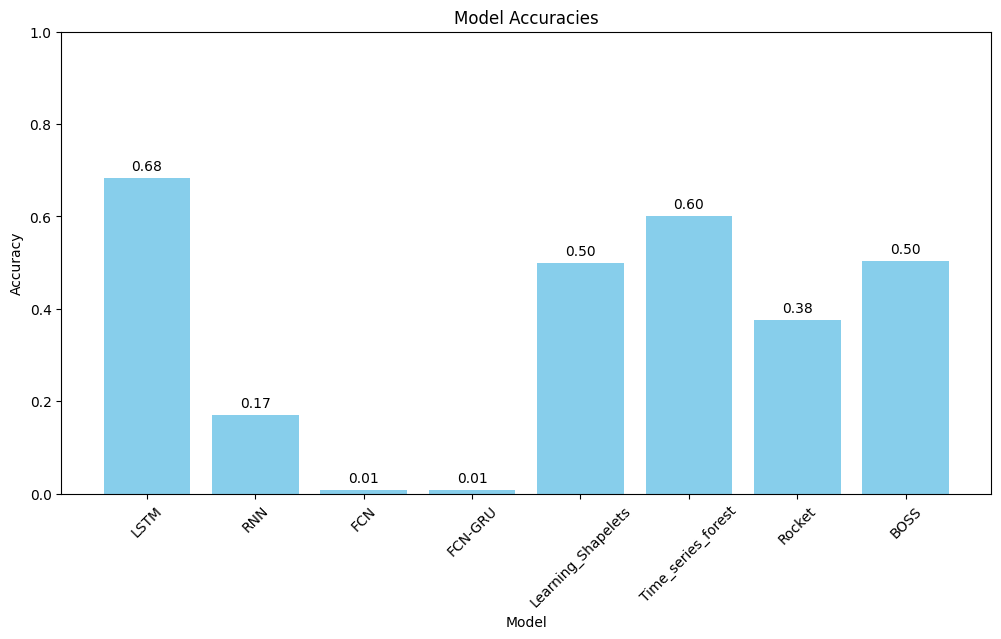

In [ ]:
accuracies = [accuracy_lstm_kt, accuracy_rnn_kt, accuracy_fcn_kt, accuracy_gru_fcn_kt, accuracy_ls_kt, accuracy_tsf_kt, accuracy_rocket_kt, accuracy_boss_kt]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

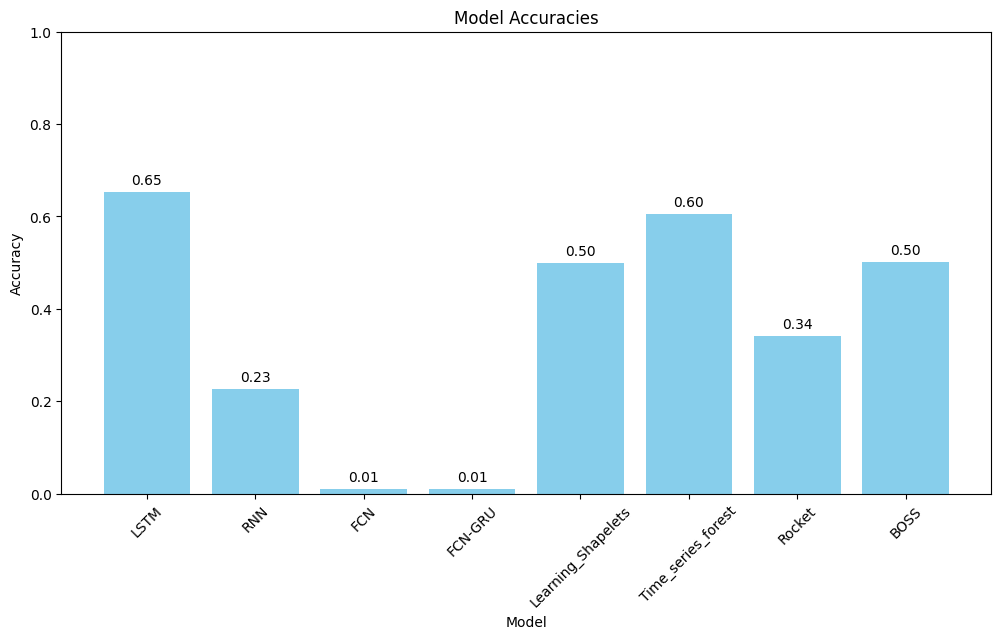

In [ ]:
accuracies = [accuracy_lstm_kt_30m, accuracy_rnn_kt_30m, accuracy_fcn_kt_30m, accuracy_gru_fcn_kt_30m, accuracy_ls_kt_30m, accuracy_tsf_kt_30m, accuracy_rocket_kt_30m, accuracy_boss_kt_30m]
model_name = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(model_name, accuracies, color='skyblue')

# Add titles and labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the accuracy values on the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
# Define the model names
model_names = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Define the accuracies for each appliance
Washing_Machine = [accuracy_lstm_wm, accuracy_rnn_wm, accuracy_fcn_wm, accuracy_gru_fcn_wm, accuracy_ls_wm, accuracy_tsf_wm, accuracy_rocket_wm, accuracy_boss_wm]
Television_Site = [accuracy_lstm_ts, accuracy_rnn_ts, accuracy_fcn_ts, accuracy_gru_fcn_ts, accuracy_ls_ts, accuracy_tsf_ts, accuracy_rocket_ts, accuracy_boss_ts]
Microwave = [accuracy_lstm_mv, accuracy_rnn_mv, accuracy_fcn_mv, accuracy_gru_fcn_mv, accuracy_ls_mv, accuracy_tsf_mv, accuracy_rocket_mv, accuracy_boss_mv]
Dishwasher = [accuracy_lstm_dw, accuracy_rnn_dw, accuracy_fcn_dw, accuracy_gru_fcn_dw, accuracy_ls_dw, accuracy_tsf_dw, accuracy_rocket_dw, accuracy_boss_dw]
Kettle = [accuracy_lstm_kt, accuracy_rnn_kt, accuracy_fcn_kt, accuracy_gru_fcn_kt, accuracy_ls_kt, accuracy_tsf_kt, accuracy_rocket_kt, accuracy_boss_kt]

# Create a DataFrame
data = {
    'Washing_Machine': Washing_Machine,
    'Television_Site': Television_Site,
    'Microwave': Microwave,
    'Dishwasher': Dishwasher,
    'Kettle': Kettle
}

df = pd.DataFrame(data, index=model_names).T

# Print the DataFrame using tabulate with a title
print("Accuracy metric table: individual appliance predictions on high frequency data\n")
print(tabulate(df, headers='keys', tablefmt='grid'))

Accuracy metric table: individual appliance predictions on high frequency data

+-----------------+----------+----------+-----------+-----------+----------------------+----------------------+----------+----------+
|                 |     LSTM |      RNN |       FCN |   FCN-GRU |   Learning_Shapelets |   Time_series_forest |   Rocket |     BOSS |
+=================+==========+==========+===========+===========+======================+======================+==========+==========+
| Washing_Machine | 0.76635  | 0.527578 | 0.0613787 | 0.0613787 |            0.0596393 |             0.777546 | 0.517993 | 0.504482 |
+-----------------+----------+----------+-----------+-----------+----------------------+----------------------+----------+----------+
| Television_Site | 0.5741   | 0.576561 | 0.587041  | 0.587041  |            0.417938  |             0.577719 | 0.522885 | 0.473417 |
+-----------------+----------+----------+-----------+-----------+----------------------+----------------------+-----

In [ ]:
# Define the model names
model_names = ['LSTM', 'RNN', 'FCN', 'FCN-GRU', 'Learning_Shapelets', 'Time_series_forest', 'Rocket', 'BOSS']

# Define the accuracies for each appliance
Washing_Machine = [accuracy_lstm_wm_30m, accuracy_rnn_wm_30m, accuracy_fcn_wm_30m, accuracy_gru_fcn_wm_30m, accuracy_ls_wm_30m, accuracy_tsf_wm_30m, accuracy_rocket_wm_30m, accuracy_boss_wm_30m]
Television_Site = [accuracy_lstm_ts_30m, accuracy_rnn_ts_30m, accuracy_fcn_ts_30m, accuracy_gru_fcn_ts_30m, accuracy_ls_ts_30m, accuracy_tsf_ts_30m, accuracy_rocket_ts_30m, accuracy_boss_ts_30m]
Microwave = [accuracy_lstm_mv_30m, accuracy_rnn_mv_30m, accuracy_fcn_mv_30m, accuracy_gru_fcn_mv_30m, accuracy_ls_mv_30m, accuracy_tsf_mv_30m, accuracy_rocket_mv_30m, accuracy_boss_mv_30m]
Dishwasher = [accuracy_lstm_dw_30m, accuracy_rnn_dw_30m, accuracy_fcn_dw_30m, accuracy_gru_fcn_dw_30m, accuracy_ls_dw_30m, accuracy_tsf_dw_30m, accuracy_rocket_dw_30m, accuracy_boss_dw_30m]
Kettle = [accuracy_lstm_kt_30m, accuracy_rnn_kt_30m, accuracy_fcn_kt_30m, accuracy_gru_fcn_kt_30m, accuracy_ls_kt_30m, accuracy_tsf_kt_30m, accuracy_rocket_kt_30m, accuracy_boss_kt_30m]

# Create a DataFrame
data = {
    'Washing_Machine': Washing_Machine,
    'Television_Site': Television_Site,
    'Microwave': Microwave,
    'Dishwasher': Dishwasher,
    'Kettle': Kettle
}

df = pd.DataFrame(data, index=model_names).T

# Print the DataFrame using tabulate with a title
print("Accuracy metric table: individual appliance predictions on 30 minute sampled low frequency data\n")
print(tabulate(df, headers='keys', tablefmt='grid'))

Accuracy metric table: individual appliance predictions on 30 minute sampled low frequency data

+-----------------+----------+----------+------------+------------+----------------------+----------------------+----------+----------+
|                 |     LSTM |      RNN |        FCN |    FCN-GRU |   Learning_Shapelets |   Time_series_forest |   Rocket |     BOSS |
+=================+==========+==========+============+============+======================+======================+==========+==========+
| Washing_Machine | 0.711662 | 0.543226 | 0.0555688  | 0.0555688  |            0.0555688 |             0.735035 | 0.533781 | 0.50842  |
+-----------------+----------+----------+------------+------------+----------------------+----------------------+----------+----------+
| Television_Site | 0.595823 | 0.604511 | 0.57521    | 0.57521    |            0.42479   |             0.58642  | 0.525672 | 0.472556 |
+-----------------+----------+----------+------------+------------+--------------------

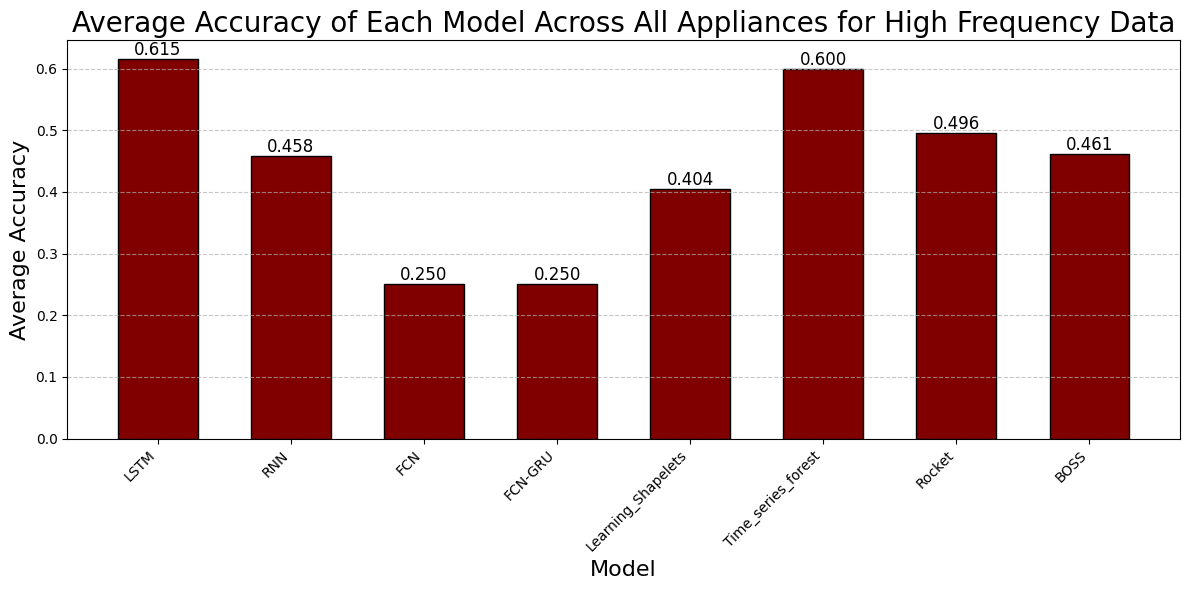

In [71]:
# Data
accuracy_data = {
    "Washing_Machine": {
        "LSTM": 0.76635,
        "RNN": 0.527578,
        "FCN": 0.0613787,
        "FCN-GRU": 0.0613787,
        "Learning_Shapelets": 0.0596393,
        "Time_series_forest": 0.777546,
        "Rocket": 0.517993,
        "BOSS": 0.504482
    },
    "Television_Site": {
        "LSTM": 0.5741,
        "RNN": 0.576561,
        "FCN": 0.587041,
        "FCN-GRU": 0.587041,
        "Learning_Shapelets": 0.417938,
        "Time_series_forest": 0.577719,
        "Rocket": 0.522885,
        "BOSS": 0.473417
    },
    "Microwave": {
        "LSTM": 0.507889,
        "RNN": 0.474393,
        "FCN": 0.548884,
        "FCN-GRU": 0.548884,
        "Learning_Shapelets": 0.542626,
        "Time_series_forest": 0.497119,
        "Rocket": 0.508097,
        "BOSS": 0.458878
    },
    "Dishwasher": {
        "LSTM": 0.542954,
        "RNN": 0.542601,
        "FCN": 0.046199,
        "FCN-GRU": 0.046199,
        "Learning_Shapelets": 0.5,
        "Time_series_forest": 0.545941,
        "Rocket": 0.552445,
        "BOSS": 0.361628
    },
    "Kettle": {
        "LSTM": 0.683403,
        "RNN": 0.169945,
        "FCN": 0.0072075,
        "FCN-GRU": 0.0072075,
        "Learning_Shapelets": 0.5,
        "Time_series_forest": 0.600694,
        "Rocket": 0.376828,
        "BOSS": 0.505361
    }
}

# Convert to DataFrame
df = pd.DataFrame(accuracy_data).T

# Calculate the average accuracy for each model
average_accuracies = df.mean(axis=0)

# Plotting the average accuracies
plt.figure(figsize=(12, 6))

# Define bar width and positions
bar_width = 0.6  # Fixed width for bars
positions = range(len(average_accuracies))  # Bar positions

bars = plt.bar(positions, average_accuracies, width=bar_width, color='maroon', edgecolor='black')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position (center of the bar)
        yval,  # y position (top of the bar)
        f'{yval:.3f}',  # Value formatted to 3 decimal places
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=12,  # Font size for the labels
        color='black'  # Color of the text
    )

# Set x-ticks with model names
plt.title('Average Accuracy of Each Model Across All Appliances for High Frequency Data', fontsize=20)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Average Accuracy', fontsize=16)
plt.xticks(positions, average_accuracies.index, rotation=45, ha='right')  # Ensure model names are readable
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

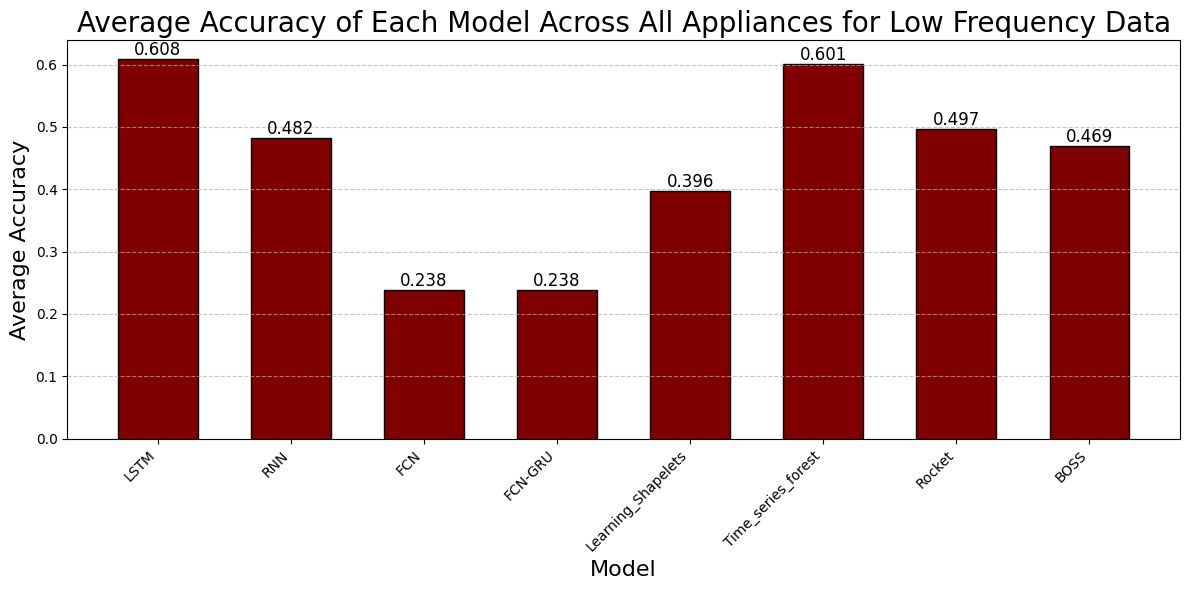

In [72]:
accuracy_data = {
    "Washing_Machine": {
        "LSTM": 0.711662,
        "RNN": 0.543226,
        "FCN": 0.0555688,
        "FCN-GRU": 0.0555688,
        "Learning_Shapelets": 0.0555688,
        "Time_series_forest": 0.735035,
        "Rocket": 0.533781,
        "BOSS": 0.50842
    },
    "Television_Site": {
        "LSTM": 0.595823,
        "RNN": 0.604511,
        "FCN": 0.57521,
        "FCN-GRU": 0.57521,
        "Learning_Shapelets": 0.42479,
        "Time_series_forest": 0.58642,
        "Rocket": 0.525672,
        "BOSS": 0.472556
    },
    "Microwave": {
        "LSTM": 0.544854,
        "RNN": 0.498927,
        "FCN": 0.501891,
        "FCN-GRU": 0.501891,
        "Learning_Shapelets": 0.501891,
        "Time_series_forest": 0.542707,
        "Rocket": 0.523049,
        "BOSS": 0.498859
    },
    "Dishwasher": {
        "LSTM": 0.535875,
        "RNN": 0.537364,
        "FCN": 0.0460972,
        "FCN-GRU": 0.0460972,
        "Learning_Shapelets": 0.5,
        "Time_series_forest": 0.533674,
        "Rocket": 0.561787,
        "BOSS": 0.365303
    },
    "Kettle": {
        "LSTM": 0.653777,
        "RNN": 0.226636,
        "FCN": 0.00926715,
        "FCN-GRU": 0.00926715,
        "Learning_Shapelets": 0.5,
        "Time_series_forest": 0.604749,
        "Rocket": 0.342033,
        "BOSS": 0.501233
    }
}

# Convert to DataFrame
df = pd.DataFrame(accuracy_data).T

# Calculate the average accuracy for each model
average_accuracies = df.mean(axis=0)

# Plotting the average accuracies
plt.figure(figsize=(12, 6))

# Define bar width and positions
bar_width = 0.6  # Fixed width for bars
positions = range(len(average_accuracies))  # Bar positions

bars = plt.bar(positions, average_accuracies, width=bar_width, color='maroon', edgecolor='black')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position (center of the bar)
        yval,  # y position (top of the bar)
        f'{yval:.3f}',  # Value formatted to 3 decimal places
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=12,  # Font size for the labels
        color='black'  # Color of the text
    )

# Set x-ticks with model names
plt.title('Average Accuracy of Each Model Across All Appliances for Low Frequency Data', fontsize=20)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Average Accuracy', fontsize=16)
plt.xticks(positions, average_accuracies.index, rotation=45, ha='right')  # Ensure model names are readable
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Real Time Prediction Pipeline

In [ ]:

# Kafka producer configuration
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

# Send the single numeric value as a message to Kafka
aggregate_value = 0.003419 #random number as input
producer.send('final_topic_14', value=aggregate_value)
producer.flush()  # Ensure all messages are sent

# Measure start time
start_time = time.time()

def predict_appliance_usage(model, data):
    df = pd.DataFrame([data], columns=['Aggregate'])
    if model.__class__.__name__ == 'Sequential':
        pred = (model.predict(df) > 0.5).astype(int)
    else:
        array = df.to_numpy()
        reshaped_array = array.reshape(-1, df.shape[1])
        pred = model.predict(reshaped_array)
    return pred

# Kafka consumer configuration
conf = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'test_group'
}

consumer = Consumer(conf)
consumer.subscribe(['final_topic_14'])

def process_message(message):
    try:
        aggregate_value = json.loads(message.value().decode('utf-8'))  # Directly get the aggregate value
        #select models based on best macro f1-scores
        models = {
            'washing_machine': rnn_model_wm_30m,
            'television_site': rnn_model_ts_30m,
            'microwave': tsf_mv_30m,
            'dishwasher': rnn_model_dw_30m,
            'kettle': boss_kt_30m
        }
        
        predictions = {}
        for appliance, model in models.items():
            pred = predict_appliance_usage(model, aggregate_value)
            predictions[appliance] = pred
            status = 'not detected' if pred[0] == 0 else 'detected'
            print(f"{appliance.replace('_', ' ').title()}: {status}")
            
        print()  # Print a blank line for better readability

        # Measure end time and calculate the time taken
        end_time = time.time()
        time_taken = end_time - start_time
        print(f"Time taken from message production to prediction: {time_taken:.4f} seconds")

        return predictions
    
    except Exception as e:
        print(f"Error processing message: {e}")

if __name__ == '__main__':
    try:
        while True:
            msg = consumer.poll(timeout=1.0)
            if msg is None:
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    continue
                else:
                    raise KafkaException(msg.error())
            process_message(msg)
    finally:
        consumer.close()


1/1 [==============================] - 0s 23ms/step
Washing Machine: not detected
1/1 [==============================] - 0s 22ms/step
Television Site: detected
Microwave: not detected
1/1 [==============================] - 0s 29ms/step
Dishwasher: not detected
Kettle: not detected

Time taken from message production to prediction: 9.0813 seconds
